# Import

In [1]:
import pandas as pd
from scipy import stats
import numpy as np
from statsmodels.stats import multitest
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import math
import os
import ast

from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, Normalizer, PowerTransformer, RobustScaler, MaxAbsScaler
from imblearn.combine import SMOTEENN
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report
from scipy.stats import ttest_ind
#MODEL SELECTION
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score, KFold, StratifiedKFold
#EVALUATION METRICS
from sklearn.metrics import make_scorer, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, explained_variance_score, mean_squared_error, r2_score, max_error, mean_absolute_error
from scipy.stats import pearsonr, t  
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter("ignore", ConvergenceWarning)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

Selecionar o tipo de cancro mais frequente em todos os CDGs. 
Shuffle com o modo random do numpy -> Baralhar os valores por coluna. Não é necessário

In [2]:
def remove_hipermutated_patients(maf, mutations_per_patient):
    mutations_per_patient_count = list(mutations_per_patient.values())
    q1 = np.quantile(mutations_per_patient_count, .25)
    q2 = np.quantile(mutations_per_patient_count, .50)
    q3 = np.quantile(mutations_per_patient_count, .75)
    iqr = q3 - q1
    threshold_hm = q3 + 4.5*iqr
    mutations_per_patient_filtered = dict(filter(lambda elem: elem[1] <= threshold_hm, mutations_per_patient.items()))
    maf = maf[maf.Tumor_Sample_Barcode.isin(list(mutations_per_patient_filtered))]
    return maf


In [3]:
def count_outliers(s, k_inner=1.5, k_outer=3):
    """
    Counts the number of outliers in a sample using both inner and outer fences.
    
    Parameters
    ----------
    s : numpy 1D array or Series
        Sample where Tukey's fences method is applied.
        
    k_inner : float, default 1.5
        Factor to determine the inner fence.
        
    k_outer : float, default 3
        Factor to determine the outer fence.
        
    Returns
    -------
    inner_outliers : int
        Number of inner outliers in the sample.
    
    outer_outliers : int
        Number of outer outliers in the sample.
    """
    
    # Calculating inner fences
    IQR = np.quantile(s, .75) - np.quantile(s, .25)
    lower_inner_fence = np.quantile(s, .25) - k_inner * IQR
    upper_inner_fence = np.quantile(s, .75) + k_inner * IQR

    # Calculating outer fences
    lower_outer_fence = np.quantile(s, .25) - k_outer * IQR
    upper_outer_fence = np.quantile(s, .75) + k_outer * IQR

    # Counting inner and outer outliers
    inner_outliers = np.sum((s < lower_inner_fence) | (s > upper_inner_fence))
    outer_outliers = np.sum((s < lower_outer_fence) | (s > upper_outer_fence))
    
    return inner_outliers, outer_outliers

In [3]:
def gapmine(X, y, module, train_size=0.8, beta=1, oversample=False, false_annotations=False, shortest_paths=None, graph=None, random_state=None):
    cv_results = {'best_score': 0, 'best_C': 0, 'n_iter': 0, 'n_features': 0, 'fs': 0}
    clf = LogisticRegressionCV(
                    Cs=np.logspace(-4, 4, 15),
                    scoring=scorer,
                    penalty='l2',
                    solver='lbfgs',
                    cv=10,
                    n_jobs=None,
                    verbose=0,
                    refit=True,
                    )
                
    if not sys.warnoptions:
        warnings.simplefilter("ignore", category=ConvergenceWarning)
        warnings.simplefilter("ignore", category=FitFailedWarning)
        os.environ["PYTHONWARNINGS"] = "ignore"
        clf.fit(X_train_fs, y_train)

    mean_scores = np.mean(clf.scores_[1.0], axis=0)
    mean_iter = np.mean(clf.n_iter_[0], axis=0)

    best_index = np.argmax(mean_scores)
    best_score = np.amax(mean_scores)
    best_C = clf.C_[0]
    n_iter = mean_iter[best_index]
                
    # choose fs that generates the best model
    if best_score > cv_results['best_score']:

        cv_results['best_score'] = best_score
        cv_results['best_C'] = best_C
        cv_results['n_iter'] = n_iter
        cv_results['n_features'] = n_features
        cv_results['fs'] = fs
        best_clf = clf
        X_train_best = X_train_fs
        X_test_best = X_test_fs

    # if cv results are identical, choose the model 
    # with fewer predictors
    elif (best_score == cv_results['best_score']) & (n_features < cv_results['n_features']):
        
        cv_results['best_score'] = best_score
        cv_results['best_C'] = best_C
        cv_results['n_iter'] = n_iter
        cv_results['n_features'] = n_features
        cv_results['fs'] = fs
        best_clf = clf
        X_train_best = X_train_fs
        X_test_best = X_test_fs

    threshold = db_calibration(X_train_best, y_train, best_clf, beta=beta, cv=5)
    y_pred_proba = best_clf.predict_proba(X_test_best)[:, 1]
    y_pred = db_classifier(y_pred_proba, threshold)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    precision_at_k = top_k_precision(y_test, y_pred_proba)
    
    clf_results = dict(
        threshold = threshold,
        tn = tn, fp = fp, fn = fn, tp = tp,
        precision = precision_score(y_test, y_pred, zero_division=0),
        recall = recall_score(y_test, y_pred, zero_division=0),
        f_beta = fbeta_score(y_test, y_pred, beta=beta),
        f1 = fbeta_score(y_test, y_pred, beta=1),
        phi_coef = matthews_corrcoef(y_test, y_pred),
        p4 = 4*tp*tn/(4*tp*tn+(tp+tn)*(fp+fn)),
        avg_precision = average_precision_score(y_test, y_pred_proba),
        precision_at_k = precision_at_k,
        random_precision = (tp+fn)/(tp+fp+tn+fn)
    )

    return cv_results, clf_results, best_clf

def compute_db(y_test, y_pred_proba, beta=1):
    """
    Calculates the decision boundary that maximizes the f_beta score using the precision-recall
    curve.
    """
    precision, recall, thresholds_ = precision_recall_curve(y_test, y_pred_proba)
    
    f_beta = (1+beta**2)*precision*recall/((beta**2)*precision+recall)
    threshold = thresholds_[np.nanargmax(f_beta)]
    
    return threshold


def baseline(X, y, beta=1, false_annotations=False, shortest_paths=None, graph=None, random_state=None):
    """
    
    """
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=random_state)
    
    if false_annotations:

        if shortest_paths is None:

            raise ValueError('Array with shortest paths needed to compute false annotations.')
        elif graph is None:

            raise ValueError('Graph is needed to compute false annotations.')
        else:
            
            y_train = add_false_annotations(y_train, graph, shortest_paths, random_state=random_state)

    ############ Train model & set threshold ####################
    
    threshold = compute_db(y_train, X_train, beta=beta)

    ############ Metrics ################################
    y_pred = db_classifier(X_test, threshold)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    precision_scores, recall_scores, _ = precision_recall_curve(y_test, X_test)
    precision_at_k = top_k_precision(y_test, X_test)

    clf_results = dict(
        threshold = threshold,
        tn = tn, fp = fp, fn = fn, tp = tp,
        precision = precision_score(y_test, y_pred, zero_division=0),
        recall = recall_score(y_test, y_pred, zero_division=0),
        f_beta = fbeta_score(y_test, y_pred, beta=beta),
        f1 = fbeta_score(y_test, y_pred, beta=1),
        phi_coef = matthews_corrcoef(y_test, y_pred),
        p4 = 4*tp*tn/(4*tp*tn+(tp+tn)*(fp+fn)),
        auprc = auc(recall_scores, precision_scores),
        precision_at_k = precision_at_k,
        random_precision = (tp+fn)/(tp+fp+tn+fn)
    )

    return clf_results


#####################################################################################################################################
def compute_db(y_test, y_pred_proba, beta=1):
    """
    Calculates the decision boundary that maximizes the f_beta score using the precision-recall
    curve.
    """
    precision, recall, thresholds_ = precision_recall_curve(y_test, y_pred_proba)
    
    f_beta = (1+beta**2)*precision*recall/((beta**2)*precision+recall)
    threshold = thresholds_[np.nanargmax(f_beta)]
    
    return threshold
    
    
def db_calibration(X, y, clf, beta=1, cv=5):
    """
    Calibrates the decision boundary of a logistic regression classifier using cross-validation.
    """
    skf = StratifiedKFold(n_splits=cv)
    split = skf.split(X, y)

    thresholds = []
    for train_index, test_index in split:
        X_train,  y_train = X[train_index], y[train_index]
        X_test, y_test = X[test_index], y[test_index]
        
        log_reg = LogisticRegression(C=clf.C_[0])
        log_reg.fit(X_train, y_train)
        y_pred_proba = log_reg.predict_proba(X_test)[:, 1]
        
        threshold = compute_db(y_test, y_pred_proba, beta=beta)
                
        thresholds.append(threshold)

    return np.mean(thresholds)


def top_k_precision(y_true, y_pred_proba):
    """
    Calculates the precision at (P@K) where K is the number of positives
    in the test set.
    """
    k = np.sum(y_true) # n_positives
    
    top_k = y_true[np.argsort(y_pred_proba)[::-1]][:k]

    # TP/(TP+FP)
    precision = np.sum(top_k)/k

    return precision


def db_classifier(y_pred_proba, threshold, neg_class=0):
    """
    
    """
    
    y_pred = np.ones_like(y_pred_proba)
    y_pred[np.flatnonzero(y_pred_proba<threshold)] = neg_class
    
    return y_pred


##############################TO MODIFY##############################################################################
def whole_clf(data, labels, models, fs, n_fs, threshold):
    # Predicts whether a protein is associated with a process/disease in the whole dataset using the previously trained model.
    #
    # INPUT:
    #   - dataframe with metrics.
    #   - dataframe with labels
    #   - list with trained models.
    #   - dataframe with VIP scores.
    #   - list with number of selected modules.
    #   - list with probability thresholds.
    #
    # RETURNS: dataframe with a collection of performance metrics.

    clf_results = []
    for i in tqdm(range(data.shape[0])):
        module_fs = fs.iloc[:, i]
        y_true = labels.iloc[:, i]
        module_data = data[list(module_fs.sort_values(
            ascending=False)[:n_fs[i]].index)].transpose()
        module_threshold = threshold[i]
        module_model = models[i]
        module_model.fit(module_data, y_true.values)
        y_pred = module_model.predict_proba(module_data)[:, 1]
        y_pred[y_pred < module_threshold] = 0
        y_pred[y_pred >= module_threshold] = 1
        true_pred_df = pd.DataFrame({'true': y_true.values, 'pred': y_pred})
        true_pred_df.index = y_true.index
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()


        clf_results.append({
                    #'module': module,
                    'f_measure': f1_score(y_true, y_pred, zero_division=0),
                    'precision': precision_score(y_true, y_pred),
                    'recall': recall_score(y_true, y_pred),
                    'mcc': matthews_corrcoef(y_true, y_pred),
                    'tp': tp,
                    'fp': fp,
                    'fn': fn,
                    'tn': tn,
                    'new_proteins': list(
            true_pred_df[(true_pred_df['true'] == 0) & (true_pred_df['pred'] == 1)].index
            ),
            })

        
    return pd.DataFrame(clf_results)

In [4]:
def classification_plot(y_test_clf, predictions, model_name, driver_name):
    cm = confusion_matrix(y_test_clf, predictions)
    labels = ['Positive', 'Negative']
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(cm, annot=True, fmt="d", cmap='Greens', xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix for {model_name} - {driver_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


def classification_evaluation(y_test_clf, predictions):

    accuracy = accuracy_score(y_test_clf, predictions)
    precision = precision_score(y_test_clf, predictions)
    recall = recall_score(y_test_clf, predictions)
    f1 = f1_score(y_test_clf, predictions)
    mcc = matthews_corrcoef(y_test_clf, predictions)

    results = {'Test Accuracy': [accuracy], 'Test Precision': [precision], 'Test Recall': [recall], 'Test F1': [f1], 'Test MCC': [mcc]} 
    results_df = pd.DataFrame(results)
    
    return results_df

""" def classification_scores(classifier_name, classifier, parameters, X_train, y_train, metric="mcc"):
    
    mcc_scorer = make_scorer(matthews_corrcoef)
    
    if metric == "mcc": #mcc is not a valid scoring metric in GridSearchCV, therefore it is treated individually
        gs = GridSearchCV(classifier, parameters, cv=5, scoring=mcc_scorer)
    else:
        gs = GridSearchCV(classifier, parameters, cv=5, scoring=metric)
        
    gs.fit(X_train, y_train)
    
    best_params, best_score = gs.best_params_, gs.best_score_
      
    dict_scorers = {'accuracy': make_scorer(accuracy_score), 'precision': make_scorer(precision_score), 'recall': make_scorer(precision_score),
                    'f1': make_scorer(f1_score), 'mcc': make_scorer(matthews_corrcoef)}
                                            
    scores = cross_validate(gs, X_train, y_train, cv=5, scoring=dict_scorers, n_jobs=-1)
          
    eval_dict = {'Model': [classifier_name], 'CV Accuracy': [np.mean(scores['test_accuracy'])], 'CV Precision': [np.mean(scores['test_precision'])],
                 'CV Recall': [np.mean(scores['test_recall'])], 'CV F1': [np.mean(scores['test_f1'])], 'CV MCC': [np.mean(scores['test_mcc'])]}
    eval_df = pd.DataFrame(eval_dict) 
    
    return gs.best_estimator_, eval_df, best_params  """

' def classification_scores(classifier_name, classifier, parameters, X_train, y_train, metric="mcc"):\n    \n    mcc_scorer = make_scorer(matthews_corrcoef)\n    \n    if metric == "mcc": #mcc is not a valid scoring metric in GridSearchCV, therefore it is treated individually\n        gs = GridSearchCV(classifier, parameters, cv=5, scoring=mcc_scorer)\n    else:\n        gs = GridSearchCV(classifier, parameters, cv=5, scoring=metric)\n        \n    gs.fit(X_train, y_train)\n    \n    best_params, best_score = gs.best_params_, gs.best_score_\n      \n    dict_scorers = {\'accuracy\': make_scorer(accuracy_score), \'precision\': make_scorer(precision_score), \'recall\': make_scorer(precision_score),\n                    \'f1\': make_scorer(f1_score), \'mcc\': make_scorer(matthews_corrcoef)}\n                                            \n    scores = cross_validate(gs, X_train, y_train, cv=5, scoring=dict_scorers, n_jobs=-1)\n          \n    eval_dict = {\'Model\': [classifier_name], \'CV 

In [5]:
def classification_scores(classifier_name, classifier, parameters, X_train, y_train, metric="f1"):
    # Define the scorer for MCC
    mcc_scorer = make_scorer(matthews_corrcoef)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Choose the scoring method
    if metric == "mcc":
        gs = GridSearchCV(classifier, parameters, cv=skf, scoring=mcc_scorer, n_jobs=-1)
    else:
        gs = GridSearchCV(classifier, parameters, cv=skf, scoring=metric, n_jobs=-1)
        
    gs.fit(X_train, y_train)
    
    best_params, best_score = gs.best_params_, gs.best_score_
    
    # Define scorers for cross-validation
    dict_scorers = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score, average='weighted'),
        'recall': make_scorer(recall_score, average='weighted'),
        'f1': make_scorer(f1_score, average='weighted'),
        'mcc': make_scorer(matthews_corrcoef)
    }
    
    # Evaluate the best model using cross-validation
    scores = cross_validate(gs.best_estimator_, X_train, y_train, cv=skf, scoring=dict_scorers, n_jobs=-1)
    
    eval_dict = {
        'Model': [classifier_name],
        'CV Accuracy': [np.mean(scores['test_accuracy'])],
        'CV Precision': [np.mean(scores['test_precision'])],
        'CV Recall': [np.mean(scores['test_recall'])],
        'CV F1': [np.mean(scores['test_f1'])],
        'CV MCC': [np.mean(scores['test_mcc'])]
    }
    
    eval_df = pd.DataFrame(eval_dict)
    
    return gs.best_estimator_, eval_df, best_params

In [6]:
def results_confidence(model1, model2, type, X_train, X_IVS, y_train, y_IVS, runs=100, confidence=0.95):
    
    scores1, scores2 = [], []
    model1, model2 = model1, model2
    runs = runs

    for _ in range(runs):
    
        model1, model2 = model1.fit(X_train, y_train), model2.fit(X_train, y_train)
        preds_model1, preds_model2 = model1.predict(X_IVS), model2.predict(X_IVS)
        
        if type == "regression":
            scores1.append(mean_absolute_error(y_IVS, preds_model1))
            scores2.append(mean_absolute_error(y_IVS, preds_model2))
            metric = "MAE"
            
        elif type == "classification":
            scores1.append(matthews_corrcoef(y_IVS, preds_model1))
            scores2.append(matthews_corrcoef(y_IVS, preds_model2))
            metric = "MCC"

    mean_scores1, mean_scores2 = np.mean(scores1), np.mean(scores2)
    std_error1, std_error2 = np.std(scores1) / np.sqrt(len(scores1)), np.std(scores2) / np.sqrt(len(scores2))
    confidence = confidence
    df = len(scores1) - 1
    margin_error1, margin_error2 = t.ppf(1 - (1 - confidence) / 2, df) * std_error1, t.ppf(1 - (1 - confidence) / 2, df) * std_error2
    lower_bound1, lower_bound2 = mean_scores1 - margin_error1, mean_scores2 - margin_error2
    upper_bound1, upper_bound2 = mean_scores1 + margin_error1, mean_scores2 + margin_error2
    
    classifier_name1, classifier_name2 = str(model1), str(model2)
    
    print("Model 1: " + classifier_name1)
    print(str(math.floor(confidence * 100)) + "% Confidence Interval for " + metric + ":", (lower_bound1, upper_bound1))
    print()
    print("Model 2: " + classifier_name2)
    print(str(math.floor(confidence * 100)) + "% Confidence Interval for " + metric + ":", (lower_bound2, upper_bound2))
    print()
    
    if type == "regression": #proportion of runs where score1 is less than score 2 (lower values of MAE are better)
        proportion_better = sum(score1 < score2 for score1, score2 in zip(scores1, scores2)) / len(scores1)
        
    elif type == "classification": #the other way around (greater values of MCC are better)
        proportion_better = sum(score1 > score2 for score1, score2 in zip(scores1, scores2)) / len(scores1)
    
    print("Model 1 is better than Model 2 in " + str(proportion_better * 100) + "% of runs.")

In [4]:
""" string_info_df_final = pd.read_csv('string_all_drivers_info_final.csv')
apid_info_df_final = pd.read_csv('apid_all_drivers_info_final.csv')
huri_info_df_final = pd.read_csv('huri_all_drivers_info_final.csv')
omnipath_info_df_final = pd.read_csv('omnipath_all_drivers_info_final.csv')
biogrid_info_df_final = pd.read_csv('biogrid_all_drivers_info_final.csv') """

In [5]:
""" info_df = pd.read_csv('sum_all_drivers_info_final.csv', index_col=0, converters={'Significant_Spearman_Drivers': eval, 'Significant_OLS_Drivers': eval, 'Positive_Spearman_Drivers': eval, 'Negative_Spearman_Drivers': eval, 'Positive_OLS_Drivers': eval, 'Negative_OLS_Drivers': eval}) """

In [6]:
""" columns_to_analyze = ["Significant_Spearman_Drivers", "Significant_OLS_Drivers"] """

In [7]:
""" def string_tolist(x):
    if pd.notna(x):
        return eval(x)[0].split(', ')
    else:
        return [] """

In [8]:
""" networks = [
    'string',
    'apid',
    'huri',
    'biogrid',
    'omnipath'
] 
columns_to_analyze_neib = ["Significant_Spearman_Neighbors", "Significant_OLS_Neighbors"]
list_neib = []
for network in networks:
    drivers_info_df = pd.read_csv(network + '_all_drivers_info_final.csv')
    for column in columns_to_analyze_neib:
        drivers_info_df[column] = drivers_info_df[column].apply(lambda x: string_tolist(x))
        

    significant_drivers = set(info_df.loc[network, columns_to_analyze[0]]) | set(info_df.loc[network, columns_to_analyze[1]])
    filtered_df = drivers_info_df[drivers_info_df['Driver'].isin(significant_drivers)].copy()
    filtered_df['Network'] = network    
    list_neib.append(filtered_df[['Driver', 'Network'] + columns_to_analyze_neib])
all_drivers_info = pd.concat(list_neib) """
    


In [9]:
""" all_drivers_info """

Driver   Network                     Significant_Spearman_Neighbors  \
0       DDX3X    string  [AIM2, CASP1, EIF4A1, EIF4A3, EIF6, GSDMD, IKB...   
6       TRPA1    string                                                 []   
8        PMS2    string  [BRCA1, BRCA2, EXO1, FANCD2, FANCI, MSH2, PCNA...   
10    TSC22D1    string                                                 []   
11      SLIT2    string  [CAP1, CAP2, EVL, PAK1, PAK2, PAK3, PFN1, ROBO...   
...       ...       ...                                                ...   
1864   ABLIM2  omnipath                                                 []   
1867     NOX4  omnipath                                                 []   
1870    PTPRB  omnipath                                         [GHR, TEK]   
1873    USP16  omnipath                                  [CDK1, PLK1, TTK]   
1874   MAP3K4  omnipath            [CDC42, GADD45B, MAP2K4, MAPK10, MAPK9]   

                              Significant_OLS_Neighbors  
0     [AIM2, ALKBH5, CASP1, CASP5, DDX3Y, EIF2S1, EI...  
6                                          [FGFR2, NGF]  
8     [BRCA1, BRCA2, BRIP1, ERCC1, ERCC8, EXO1, FANC...  
10                                   [TSC22D3, TSC22D4]  
11    [ABL1, CLASP1, CXCL12, DCC, ENAH, GPC1, PAK3, ...  
...                                                 ...  
1864                                                 []  
1867                                             [NCF1]  
1870                  [GHR, INSR, KDR, MAPK1, PTN, TEK]  
1873                                                 []  
1874                              [MAP2K4, MAPK9, RAC1]  

[3322 rows x 4 columns]

In [118]:
""" drivers_info_copy = all_drivers_info.copy()
drivers_info_copy['Significant_Spearman_Neighbors'] = drivers_info_copy['Significant_Spearman_Neighbors'].apply(lambda x: len(x))
drivers_info_copy['Significant_OLS_Neighbors'] = drivers_info_copy['Significant_OLS_Neighbors'].apply(lambda x: len(x))
drivers_info_copy['Total_Significant_Neighbors'] = drivers_info_copy['Significant_Spearman_Neighbors'] 
#drivers_info_copy['Total_Significant_Neighbors'] = drivers_info_copy['Total_Significant_Neighbors'].combine_first(drivers_info_copy['Significant_OLS_Neighbors'])
drivers_info_copy['Total_Significant_Neighbors'] = drivers_info_copy['Significant_Spearman_Neighbors'] + drivers_info_copy['Significant_OLS_Neighbors']

drivers_info_copy = drivers_info_copy.sort_values(by='Total_Significant_Neighbors', ascending=False)
drivers_info_copy """

Driver   Network  Significant_Spearman_Neighbors  \
1131     KRAS   biogrid                             533   
2959     BRD4   biogrid                             476   
1539    FBXW7   biogrid                             430   
553     EP300   biogrid                             333   
3108    NTRK1   biogrid                             311   
...       ...       ...                             ...   
532     MAST1  omnipath                               0   
1737   TSPEAR      apid                               0   
320    SORCS1   biogrid                               0   
1707  LDHAL6A      apid                               0   
157    SAMHD1  omnipath                               0   

      Significant_OLS_Neighbors  Total_Significant_Neighbors  
1131                       1268                         1801  
2959                        541                         1017  
1539                        534                          964  
553                         480                          813  
3108                        435                          746  
...                         ...                          ...  
532                           0                            0  
1737                          0                            0  
320                           0                            0  
1707                          0                            0  
157                           0                            0  

[3777 rows x 5 columns]

In [9]:
""" all_drivers_info.info() """

<class 'pandas.core.frame.DataFrame'>
Index: 3777 entries, 0 to 1874
Data columns (total 4 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Driver                          3777 non-null   object
 1   Network                         3777 non-null   object
 2   Significant_Spearman_Neighbors  3777 non-null   object
 3   Significant_OLS_Neighbors       3777 non-null   object
dtypes: object(4)
memory usage: 147.5+ KB


In [10]:
""" results = []
for network in all_drivers_info['Network'].unique():
    drivers_in_network = all_drivers_info[all_drivers_info['Network'] == network]['Driver']
    
    for driver in drivers_in_network:
        file_path = f'{network}_output/{driver}_output.csv'
        
        try:
            df = pd.read_csv(file_path)
            
            num_mutated = df['mutated'].sum()
            
            # Find the most frequent cancer type
            most_frequent_cancer = df['cancer_type'].mode().iloc[0] if not df['cancer_type'].empty else 'N/A'
            
            results.append({
                'Network': network,
                'Driver': driver,
                'Num_Mutated': num_mutated,
                'Most_Frequent_Cancer': most_frequent_cancer
            })
        
        except FileNotFoundError:
            print(f"Arquivo não encontrado: {file_path}")
        except pd.errors.EmptyDataError:
            print(f"Arquivo vazio: {file_path}")
        except Exception as e:
            print(f"Erro ao processar {file_path}: {e}")

results_df = pd.DataFrame(results)
results_df_sorted = results_df.sort_values(by='Num_Mutated', ascending=False)
print(results_df_sorted)
#ver os drivers com maior número de mutações """

Erro ao processar biogrid_output/ZWINT_output.csv: 'mutated'
Arquivo não encontrado: biogrid_output/SOHLH2_output.csv
Arquivo não encontrado: biogrid_output/BTBD11_output.csv
Arquivo não encontrado: omnipath_output/KMT2C_output.csv
Arquivo não encontrado: omnipath_output/MKRN3_output.csv
Arquivo não encontrado: omnipath_output/NRXN3_output.csv
Arquivo não encontrado: omnipath_output/CCNB1IP1_output.csv
Arquivo não encontrado: omnipath_output/CUX1_output.csv
Arquivo não encontrado: omnipath_output/RNF103_output.csv
Arquivo não encontrado: omnipath_output/NRXN2_output.csv
Arquivo não encontrado: omnipath_output/CDKN2A_output.csv
Arquivo não encontrado: omnipath_output/TRIM48_output.csv
Arquivo não encontrado: omnipath_output/LONRF3_output.csv
Arquivo não encontrado: omnipath_output/PDZRN4_output.csv
Erro ao processar omnipath_output/LAMA4_output.csv: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.
Arquivo não encontrado: omnipath_output/RNF207_

In [71]:
""" pd.set_option('display.max_rows', None)

results = []

# Iterar por cada rede no DataFrame all_drivers_info
for network in all_drivers_info['Network'].unique():
    # Filtrar os drivers associados à rede atual
    drivers_in_network = all_drivers_info[all_drivers_info['Network'] == network]['Driver']
    
    # Para cada driver, processar o arquivo CSV correspondente
    for driver in drivers_in_network:
        file_path = f'{network}_output/{driver}_output.csv'
        
        try:
            # Ler o arquivo CSV
            df = pd.read_csv(file_path)
            
            # Contar o número de 1's na coluna 'mutated'
            num_mutated = df['mutated'].sum()
            
            # Armazenar o resultado
            results.append({'Network': network, 'Driver': driver, 'Num_Mutated': num_mutated})
        
        except FileNotFoundError:
            print(f"Arquivo não encontrado: {file_path}")
        except pd.errors.EmptyDataError:
            print(f"Arquivo vazio: {file_path}")
        except Exception as e:
            print(f"Erro ao processar {file_path}: {e}")

# Converter os resultados em um DataFrame
results_df = pd.DataFrame(results)

# Ordenar os resultados em ordem decrescente pelo número de mutações
results_df_sorted = results_df.sort_values(by='Num_Mutated', ascending=False)

# Exibir os resultados
print(results_df_sorted)

# Resetar as configurações de exibição para o padrão
pd.reset_option('display.max_rows')
 """

       Network     Driver  Num_Mutated
3526  omnipath       TP53         3134
2284   biogrid      MUC16         1763
1062      apid      MUC16         1763
2592   biogrid      CSMD3         1198
3601  omnipath      LRP1B         1149
1590      apid      LRP1B         1149
2857   biogrid      LRP1B         1149
2447   biogrid      SYNE1         1067
2610   biogrid        FLG          990
3438  omnipath        FLG          990
1787      apid      USH2A          972
3079   biogrid      USH2A          972
746     string      ZFHX4          894
2922   biogrid      ZFHX4          894
30      string      KMT2D          862
3168  omnipath      KMT2D          862
2207   biogrid      KMT2D          862
3690  omnipath      OBSCN          846
850     string      OBSCN          846
3028   biogrid      OBSCN          846
1380      apid      SPTA1          820
449     string      SPTA1          820
1992      huri      SPTA1          820
2633   biogrid      SPTA1          820
2537   biogrid       FAT3

In [72]:
""" # Configurações de exibição do pandas para mostrar todas as linhas
pd.set_option('display.max_rows', None)

# Supondo que all_drivers_info já esteja carregado como um DataFrame

# DataFrame para armazenar os resultados
results = []

# Iterar por cada rede no DataFrame all_drivers_info
for network in all_drivers_info['Network'].unique():
    # Filtrar os drivers associados à rede atual
    drivers_in_network = all_drivers_info[all_drivers_info['Network'] == network]['Driver']
    
    # Para cada driver, processar o arquivo CSV correspondente
    for driver in drivers_in_network:
        file_path = f'{network}_output/{driver}_output.csv'
        
        try:
            # Ler o arquivo CSV
            df = pd.read_csv(file_path)
            
            # Supondo que o tipo de câncer está na coluna 'cancer_type' e o status de mutação na coluna 'mutated'
            mutated_counts_by_cancer = df.groupby('cancer_type')['mutated'].sum()
            
            # Armazenar os resultados
            for cancer_type, num_mutated in mutated_counts_by_cancer.items():
                results.append({'Network': network, 'Driver': driver, 'Cancer_Type': cancer_type, 'Num_Mutated': num_mutated})
        
        except FileNotFoundError:
            print(f"Arquivo não encontrado: {file_path}")
        except pd.errors.EmptyDataError:
            print(f"Arquivo vazio: {file_path}")
        except Exception as e:
            print(f"Erro ao processar {file_path}: {e}")

# Converter os resultados em um DataFrame
results_df = pd.DataFrame(results)

# Ordenar os resultados em ordem decrescente pelo número de mutações
results_df_sorted = results_df.sort_values(by='Num_Mutated', ascending=False)

# Exibir os resultados
print(results_df_sorted)
pd.reset_option('display.max_rows') """


        Network     Driver Cancer_Type  Num_Mutated
70872  omnipath       TP53        LUSC          399
30268      apid       IDH1         LGG          396
71109  omnipath       IDH1         LGG          396
55059   biogrid       IDH1         LGG          396
70865  omnipath       TP53        HNSC          352
21527      apid      MUC16        SKCM          317
45627   biogrid      MUC16        SKCM          317
8217     string       BRAF        THCA          290
24034      apid       PTEN        UCEC          278
70858  omnipath       TP53        BRCA          264
70871  omnipath       TP53        LUAD          257
70869  omnipath       TP53         LGG          247
8215     string       BRAF        SKCM          240
21519      apid      MUC16        LUAD          212
48349   biogrid        APC        COAD          212
45619   biogrid      MUC16        LUAD          212
24295      apid        APC        COAD          212
66595  omnipath        APC        COAD          212
4881     str

In [ ]:
""" def get_significant_neighbors(row):
    neighbors = set()
    if not pd.isna(row['Significant_Spearman_Neighbors']):
        neighbors.update(eval(row['Significant_Spearman_Neighbors'])) 
    if not pd.isna(row['Significant_OLS_Neighbors']):
        neighbors.update(eval(row['Significant_OLS_Neighbors']))  
    return list(neighbors) """
""" def get_significant_neighbors(row):
    neighbors_list = row['Significant_Spearman_Neighbors'] if not pd.isna(row['Significant_Spearman_Neighbors']) else []
    neighbors_list += row['Significant_OLS_Neighbors'] if not pd.isna(row['Significant_OLS_Neighbors']) else []
    neighbors = [neighbor.strip().replace("'", '') for neighbor in neighbors_list.strip("[]").split(",") if neighbor.strip() != 'nan']
    return neighbors """

""" import ast
 """
""" def get_significant_neighbors(row):
    neighbors = set()
    if not pd.isna(row['Significant_Spearman_Neighbors']):
        neighbors.update(ast.literal_eval(row['Significant_Spearman_Neighbors']))  # Convert string representation of list to actual list
    if not pd.isna(row['Significant_OLS_Neighbors']):
        neighbors.update(ast.literal_eval(row['Significant_OLS_Neighbors']))  # Convert string representation of list to actual list
    return list(neighbors) """
""" def get_significant_neighbors(row):
    return list(set(row['Significant_Spearman_Neighbors'] + row['Significant_OLS_Neighbors']))

result_dataframes = {}
for network in all_drivers_info['Network'].unique():
    network_drivers_info = all_drivers_info[all_drivers_info['Network'] == network]
    drivers = network_drivers_info['Driver'].unique()
    driver_dataframes = []
    for driver in drivers:
        file_path = f'{network}_output/{driver}_output.csv'
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            driver_info = network_drivers_info[network_drivers_info['Driver'] == driver].iloc[0]
            significant_neighbors = get_significant_neighbors(driver_info)
            if len(significant_neighbors) == 0:
                continue 
            columns_to_select = ['patient', 'driver', 'mutated', 'cancer_type', 'sum_expression'] + significant_neighbors
            selected_columns = [col for col in columns_to_select if col in df.columns]

            filtered_df = df[selected_columns].copy()  
            filtered_df.loc[:, 'Network'] = network
            driver_dataframes.append(filtered_df)
    if driver_dataframes:
        network_df = pd.concat(driver_dataframes, ignore_index=True)
        result_dataframes[network] = network_df

string_info_df_final_filtered = result_dataframes.get('string', pd.DataFrame()) """

In [ ]:
""" apid_info_df_final_filtered = result_dataframes.get('apid', pd.DataFrame())
huri_info_df_final_filtered = result_dataframes.get('huri', pd.DataFrame())
biogrid_info_df_final_filtered = result_dataframes.get('biogrid', pd.DataFrame())
omnipath_info_df_final_filtered = result_dataframes.get('omnipath', pd.DataFrame()) """

In [2]:
""" info_df = pd.read_csv('final_significant_neighbors.csv', converters={
    'Neg_OLS_Neighbors': eval, 
    'Pos_OLS_Neighbors': eval, 
    'Neg_Spear_Neighbors': eval, 
    'Pos_Spear_Neighbors': eval
}) """

In [242]:
""" info_df = pd.read_csv('final_significant_neighbors.csv', converters={
    'Neg_OLS_Neighbors': ast.literal_eval, 
    'Pos_OLS_Neighbors': ast.literal_eval, 
    'Neg_Spear_Neighbors': ast.literal_eval, 
    'Pos_Spear_Neighbors': ast.literal_eval
}) """

In [248]:
""" Mutation = pd.read_csv('mc3.v0.2.8.PUBLIC.nonsilentGene.xena', sep='\t')
NCG = pd.read_csv('NCG_cancerdrivers_annotation_supporting_evidence.tsv', sep='\t')
Normal_tissue =  pd.read_csv('TCGA_phenotype_denseDataOnlyDownload.tsv', sep='\t')
mRNA = pd.read_csv('EB++AdjustPANCAN_IlluminaHiSeq_RNASeqV2.geneExp.xena', sep='\t')
ClinicalData = pd.read_csv('Survival_SupplementalTable_S1_20171025_xena_sp', sep='\t')
mRNA = mRNA.drop(index=16302) """

In [ ]:
""" common_samples = set(Normal_tissue[Normal_tissue['sample_type'] == 'Solid Tissue Normal']['sample'])
common_samples_trimmed = {sample[:-3] for sample in common_samples if sample in mRNA.columns.difference(['sample'])}

primary_tumor_samples = set(Normal_tissue[Normal_tissue['sample_type'] == 'Primary Tumor']['sample'])
primary_tumor_samples_trimmed = {sample[:-3] for sample in primary_tumor_samples if sample in mRNA.columns.difference(['sample'])}

matching_samples_trimmed = common_samples_trimmed.intersection(primary_tumor_samples_trimmed)
print(matching_samples_trimmed)

matching_samples_full_primary_tumor = {sample for sample in primary_tumor_samples if sample[:-3] in matching_samples_trimmed}
print(matching_samples_full_primary_tumor)

matching_samples_full_common_samples = {sample for sample in common_samples if sample[:-3] in matching_samples_trimmed}
print(matching_samples_full_common_samples)

print(len(matching_samples_full_common_samples))
print(len(matching_samples_full_primary_tumor))   """ 

In [7]:
""" datadir = "data/"
results = pd.read_csv(datadir+"results.csv")
results = results.dropna()
print(len(results))  # Total number of interactions initially
resultsfiltered = pd.read_csv(datadir + "DINTs.csv")
print(len(resultsfiltered))  # Number of significant interactions after the initial filter
def count_significant_interactions(df):
    significant = df[(df['rho_pval'] < 0.05) & (df['coef_pval'] < 0.05)]
    positive = significant[significant['rho'] > 0]
    negative = significant[significant['rho'] < 0]
    return len(significant), len(positive), len(negative)

# Count for interactions in `results`
total_sig, total_pos, total_neg = count_significant_interactions(resultsfiltered)
print(total_sig, total_pos, total_neg)  # Total count, positive and negative
# Count unique drivers per neighbour
neighbour_driver_counts = resultsfiltered.groupby('neighbour')['driver'].nunique().reset_index()
neighbour_driver_counts.columns = ['neighbour', 'unique_drivers_count']

# Filtrar vizinhos com pelo menos 2 interações significativas
neighbours_with_sufficient_interactions = neighbour_driver_counts[neighbour_driver_counts['unique_drivers_count'] >= 2]
print(len(neighbours_with_sufficient_interactions))  # Número de vizinhos após o filtro

# Filtrar resultados de interações com vizinhos suficientes
filtered_resultsfiltered = resultsfiltered[resultsfiltered['neighbour'].isin(neighbours_with_sufficient_interactions['neighbour'])]

# Contar vizinhos únicos por driver
driver_neighbour_counts = filtered_resultsfiltered.groupby('driver')['neighbour'].nunique().reset_index()
driver_neighbour_counts.columns = ['driver', 'unique_neighbours_count']

# Filtrar drivers com mais de uma interação significativa
drivers_with_multiple_neighbours = driver_neighbour_counts[driver_neighbour_counts['unique_neighbours_count'] > 1]
print(len(drivers_with_multiple_neighbours))  # Número de drivers após o filtro

# Aplicar o filtro final
filtered_resultsfiltered = filtered_resultsfiltered[filtered_resultsfiltered['driver'].isin(drivers_with_multiple_neighbours['driver'])]

# Contagem final de interações
filtered_sig, filtered_pos, filtered_neg = count_significant_interactions(filtered_resultsfiltered)
print(filtered_sig, filtered_pos, filtered_neg)  # Interações significativas, positivas e negativas após o filtro
nonsignificant = results[(results['rho_pval'] >= 0.05) | (results['coef_pval'] >= 0.05)]
print(len(nonsignificant))  # Número de interações não significativas
combined_results = pd.concat([filtered_resultsfiltered, nonsignificant], ignore_index=True)
print(len(combined_results))  # Número total de interações combinadas
significant_neighbours = filtered_resultsfiltered['neighbour'].unique()
nonsignificant_neighbours = nonsignificant['neighbour'].unique()
# Contagem de drivers e vizinhos em `results`
initial_drivers = results['driver'].nunique()
initial_neighbours = results['neighbour'].nunique()

# Contagem de drivers e vizinhos no conjunto filtrado
final_drivers = filtered_resultsfiltered['driver'].nunique()
final_neighbours = filtered_resultsfiltered['neighbour'].nunique()

print(f"Initial Drivers: {initial_drivers}, Final Drivers: {final_drivers}")
print(f"Initial Neighbours: {initial_neighbours}, Final Neighbours: {final_neighbours}")
 """

361705
14129
14129 10168 3961
1618
1209
12268 9242 3026
342205
354473
Initial Drivers: 2565, Final Drivers: 1209
Initial Neighbours: 13064, Final Neighbours: 1615


In [7]:
def drivergroups(x):
    if x.n_dints == 0:
        return "non_sign"
    else:
        if x.neg_dints == 0:
            return "pos"
        elif x.pos_dints == 0:
            return "neg"
        else:
            if x.neg_dints > x.pos_dints:
                return "more_neg"
            elif x.pos_dints > x.neg_dints:
                return "more_pos"
            else:
                return "neutral"


def labeldrivers(
    df: pd.DataFrame,
    output=None
):
    if output is None:
        output = []

    if len(output) == len(df):
        return output
    else:
        x = df.iloc[len(output)]
        return labeldrivers(df, output=output+[drivergroups(x)])


def labelneighbours(df):
    labels = []
    for i in range(len(df)):
        x = df.iloc[i]
        if x.n_dints == 0:
            labels.append("non_sign")
        else:
            if x.neg_dints == 0:
                labels.append("pos")
            elif x.pos_dints == 0:
                labels.append("neg")
            else:
                labels.append("neutral")
    return labels


In [8]:
datadir = "data/"


In [9]:
mutationtab = pd.read_feather(datadir+"mutation.feather").sort_index(axis=1).sort_index(axis=0, level=0)
print(mutationtab.shape)
display(mutationtab.head(2))
neighbourtab = pd.read_feather(datadir+"neighbours.feather").sort_index(axis=1).sort_index(axis=0, level=0)
print(neighbourtab.shape)
display(neighbourtab.head(2))

(8404, 2570)


A1CF  A2ML1  ABCA10  ABCA13  ABCA7  ABCB1  ABCB5  \
patient      cancer_type                                                     
TCGA-02-0047 GBM             0      0       0       0      0      0      0   
TCGA-02-0055 GBM             0      0       0       0      0      0      0   

                          ABCC3  ABCC5  ABCC9  ...  ZPBP2  ZRANB3  ZRSR2  \
patient      cancer_type                       ...                         
TCGA-02-0047 GBM              0      0      0  ...      0       0      0   
TCGA-02-0055 GBM              0      0      0  ...      0       0      0   

                          ZSCAN31  ZSCAN4  ZSWIM3  ZSWIM6  ZWILCH  ZWINT  \
patient      cancer_type                                                   
TCGA-02-0047 GBM                0       0       0       0       0      0   
TCGA-02-0055 GBM                0       0       0       0       0      0   

                          ZZEF1  
patient      cancer_type         
TCGA-02-0047 GBM              0  
TCGA-02-0055 GBM              0  

[2 rows x 2570 columns]

(15206, 2570)


driver      A1CF  A2ML1  ABCA10  ABCA13  ABCA7  ABCB1  ABCB5  ABCC3  ABCC5  \
neighbour                                                                    
A1BG       False  False   False   False  False  False  False  False  False   
A1CF       False  False   False   False  False  False  False  False  False   

driver     ABCC9  ...  ZPBP2  ZRANB3  ZRSR2  ZSCAN31  ZSCAN4  ZSWIM3  ZSWIM6  \
neighbour         ...                                                          
A1BG       False  ...  False   False  False    False   False   False   False   
A1CF       False  ...  False   False  False    False   False   False   False   

driver     ZWILCH  ZWINT  ZZEF1  
neighbour                        
A1BG        False  False  False  
A1CF        False  False  False  

[2 rows x 2570 columns]

In [10]:
tumourexp = pd.read_feather(datadir+"tumour_expression.feather").sort_index(axis=1).sort_index(axis=0, level=0)
print(tumourexp.shape)
display(tumourexp.head(2))
normalexp = pd.read_feather(datadir+"normal_expression.feather").sort_index(axis=1).sort_index(axis=0, level=0)
print(normalexp.shape)
display(normalexp.head(2))

(8404, 15206)


A1BG  A1CF    A2M  A2ML1  A4GALT  A4GNT  AAAS  AACS  \
patient      cancer_type                                                        
TCGA-02-0047 GBM          6.98   0.0  15.05   5.40    5.22   1.16  8.87  8.92   
TCGA-02-0055 GBM          8.62   0.0  15.39   1.42    8.93   0.64  9.22  8.31   

                          AADAT  AAGAB  ...  ZWILCH  ZWINT  ZXDA  ZXDB   ZXDC  \
patient      cancer_type                ...                                     
TCGA-02-0047 GBM           7.87  10.01  ...    8.03   8.66  6.05  8.48  10.12   
TCGA-02-0055 GBM           6.66  10.41  ...    8.87   7.95  5.45  8.14   9.25   

                          ZYG11A  ZYG11B    ZYX  ZZEF1  ZZZ3  
patient      cancer_type                                      
TCGA-02-0047 GBM            0.69   10.24  11.92  10.45  9.24  
TCGA-02-0055 GBM            2.60    9.85  13.49   9.25  9.49  

[2 rows x 15206 columns]

(665, 15206)


A1BG  A1CF    A2M  A2ML1  A4GALT  A4GNT  AAAS  AACS  \
patient      cancer_type                                                        
TCGA-22-4593 LUSC         5.66   0.0  17.08   0.00    8.60   1.62  9.13  9.96   
TCGA-22-4609 LUSC         6.12   0.0  16.80   2.28    8.59   0.76  8.83  9.60   

                          AADAT  AAGAB  ...  ZWILCH  ZWINT  ZXDA  ZXDB   ZXDC  \
patient      cancer_type                ...                                     
TCGA-22-4593 LUSC          7.28   9.97  ...    7.60   7.19  5.22  8.32   9.63   
TCGA-22-4609 LUSC          6.89   9.41  ...    7.29   5.59  6.04  9.02  10.24   

                          ZYG11A  ZYG11B    ZYX  ZZEF1  ZZZ3  
patient      cancer_type                                      
TCGA-22-4593 LUSC           0.83    9.89  12.92  10.51  8.83  
TCGA-22-4609 LUSC           1.03    9.87  12.66  11.12  9.19  

[2 rows x 15206 columns]

In [11]:
results = pd.read_csv(datadir + "results.csv")
print("# of interactions in maingraph:", len(results))
print("# of drivers in maingraph:", results.driver.nunique())
print("# of neighbours in maingraph:", results.neighbour.nunique())
results.dropna(inplace=True)
print("# of interactions with results:", len(results))
print("# of drivers with results:", results.driver.nunique())
print("# of neighbours with results:", results.neighbour.nunique())

# of interactions in maingraph: 383337
# of drivers in maingraph: 2570
# of neighbours in maingraph: 15206
# of interactions with results: 361705
# of drivers with results: 2565
# of neighbours with results: 13064


In [12]:
dints = pd.read_csv(datadir + "DINTs.csv")
print(len(dints))  # Number of significant interactions after the initial filter


14197


In [13]:
n_neighbours = results.groupby(["driver"]).size().rename("n_neighbours")
alldints = dints[["driver", "neighbour"]].assign(significant=[1]*len(dints))
drivers = (
    results[["driver", "neighbour"]]
    # add signal column
    .assign(signal=results.coef/results.coef.abs())
    # add significant column
    .merge(alldints, how="left")
    # fill non significant interactions with 0
    .fillna(0)
    .drop(columns="neighbour")
    # compute number of positive and negative DINTs by driver
    .groupby(["driver", "signal"], as_index=False).sum()
    # add total number of interactions by driver
    .merge(n_neighbours, left_on="driver", right_index=True)
    # calculate percentage of positive and negative DINTs per driver
    .pivot(index=["driver", "n_neighbours"], columns="signal",
           values="significant")
    # fill 0 in drivers that have neighbours with only one signal
    .fillna(0).astype(int)
    .rename(columns={1: "pos_dints", -1: "neg_dints"})
    .reset_index().rename_axis(None, axis=1)
    .assign(
        n_dints=lambda x: x.neg_dints+x.pos_dints,
        neg_pct=lambda x: x.neg_dints/x.n_neighbours,
        pos_pct=lambda x: x.pos_dints/x.n_neighbours,
    )
    .fillna(0)
)
drivers = drivers.assign(group=labeldrivers(drivers))

filt_drivers = drivers.copy()
filt_drivers.loc[(filt_drivers.n_dints == 1), "group"] = "non_sign"
filt_drivers

driver  n_neighbours  neg_dints  pos_dints  n_dints   neg_pct   pos_pct  \
0       A1CF            39          0          0        0  0.000000  0.000000   
1      A2ML1            91          3          4        7  0.032967  0.043956   
2     ABCA10             5          0          0        0  0.000000  0.000000   
3     ABCA13             9          1          3        4  0.111111  0.333333   
4      ABCA7            16          0          0        0  0.000000  0.000000   
...      ...           ...        ...        ...      ...       ...       ...   
2560  ZSWIM3             6          0          0        0  0.000000  0.000000   
2561  ZSWIM6            22          0          0        0  0.000000  0.000000   
2562  ZWILCH            22          0          1        1  0.000000  0.045455   
2563   ZWINT           136          0         22       22  0.000000  0.161765   
2564   ZZEF1            89          2          8       10  0.022472  0.089888   

         group  
0     non_sign  
1     more_pos  
2     non_sign  
3     more_pos  
4     non_sign  
...        ...  
2560  non_sign  
2561  non_sign  
2562  non_sign  
2563       pos  
2564  more_pos  

[2565 rows x 8 columns]

In [14]:
meanexp = tumourexp.reset_index(drop=True).median().rename("expression")
meanexp.head()

A1BG       6.25
A1CF       0.00
A2M       13.21
A2ML1      2.39
A4GALT     8.67
Name: expression, dtype: float64

In [15]:
n_inters = results.groupby(["neighbour"]).size().rename("n_inters")
alldints = dints[["driver", "neighbour"]].assign(significant=[1]*len(dints))
neighbours = (
    results[["driver", "neighbour"]]
    # add signal column
    .assign(signal=results.coef/results.coef.abs())
    # add significant column
    .merge(alldints, how="left")
    # fill non significant interactions with 0
    .fillna(0)
    .drop(columns="driver")
    # compute number of positive and negative DINTs by neighbour
    .groupby(["neighbour", "signal"], as_index=False).sum()
    # add total number of interactions by driver
    .merge(n_inters, left_on="neighbour", right_index=True)
    # calculate percentage of positive and negative DINTs per neighbour
    .pivot(index=["neighbour", "n_inters"], columns="signal",
           values="significant")
    # fill 0 in neighbours that have DINTs with only one signal
    .fillna(0).astype(int)
    .rename(columns={1: "pos_dints", -1: "neg_dints"})
    .reset_index().rename_axis(None, axis=1)
    .assign(
        n_dints=lambda x: x.neg_dints+x.pos_dints,
    )
)

neighbours = (
    neighbours
    .assign(group=labelneighbours(neighbours))
    .merge(meanexp, how="left", left_on="neighbour", right_index=True)
)

filt_neighbours = neighbours.copy()
filt_neighbours.loc[(filt_neighbours.n_dints == 1), "group"] = "non_sign"
filt_neighbours

neighbour  n_inters  neg_dints  pos_dints  n_dints     group  expression
0          A1BG        13          0          0        0  non_sign        6.25
1           A2M        51          1          0        1  non_sign       13.21
2         A2ML1        18          0          0        0  non_sign        2.39
3        A4GALT         3          0          0        0  non_sign        8.67
4          AAAS        49          0          0        0  non_sign        9.63
...         ...       ...        ...        ...      ...       ...         ...
13059    ZYG11A         3          0          0        0  non_sign        3.75
13060    ZYG11B        14          0          0        0  non_sign        9.69
13061       ZYX       109          0          0        0  non_sign       11.93
13062     ZZEF1        15          0          0        0  non_sign       10.19
13063      ZZZ3        36          0          0        0  non_sign        9.46

[13064 rows x 7 columns]

In [9]:
""" results = pd.read_csv(datadir+"results.csv")
results = results.dropna()
resultsfiltered = pd.read_csv(datadir+"DINTs.csv")
print(len(resultsfiltered))
nonsignificant = results[(results['rho_pval'] >= 0.05) | (results['coef_pval'] >= 0.05)]
print(len(nonsignificant))
neighbour_driver_counts = resultsfiltered.groupby('neighbour')['driver'].nunique().reset_index()
neighbour_driver_counts.columns = ['neighbour', 'unique_drivers_count']
print(len(neighbour_driver_counts))
neighbours_with_sufficient_interactions = neighbour_driver_counts[neighbour_driver_counts['unique_drivers_count'] >= 2]
print(len(neighbours_with_sufficient_interactions))
filtered_resultsfiltered = resultsfiltered[resultsfiltered['neighbour'].isin(neighbours_with_sufficient_interactions['neighbour'])]
driver_neighbour_counts = filtered_resultsfiltered.groupby('driver')['neighbour'].nunique().reset_index()
driver_neighbour_counts.columns = ['driver', 'unique_neighbours_count']
drivers_with_multiple_neighbours = driver_neighbour_counts[driver_neighbour_counts['unique_neighbours_count'] > 1]
print(len(drivers_with_multiple_neighbours))
filtered_resultsfiltered = filtered_resultsfiltered[filtered_resultsfiltered['driver'].isin(drivers_with_multiple_neighbours['driver'])]
combined_results = pd.concat([filtered_resultsfiltered, nonsignificant], ignore_index=True)
combined_results """

13511
323145
3008
1569
1176


driver neighbour       rho  rho_pval      coef  coef_pval  coef_diff  \
0        A1CF     APBA1 -0.492321  0.032248 -0.241853   0.026148  -0.237682   
1        A1CF      FHL1 -0.563405  0.012006 -0.310601   0.035318  -0.402233   
2        A1CF     GFRA1 -0.537078  0.017731 -0.643762   0.004779   0.041729   
3        A1CF     PDZD2 -0.551119  0.014457 -0.544993   0.000053  -0.133851   
4        A1CF     RRP12  0.525669  0.020804  0.117029   0.035077   0.326014   
...       ...       ...       ...       ...       ...        ...        ...   
334828  ZZEF1   TMEM41B  0.145016  0.470480  0.038778   0.259142   0.243301   
334829  ZZEF1     TOP3B  0.340711  0.082020  0.004586   0.909138   0.097823   
334830  ZZEF1    TRIM67 -0.256144  0.197180 -0.317035   0.001493  -0.065829   
334831  ZZEF1     XRCC5  0.452450  0.017807  0.037177   0.156104  -0.032418   
334832  ZZEF1    ZRANB1 -0.567852  0.002004 -0.026263   0.391077   0.026213   

        coef_diff_pval  
0             0.588965  
1             0.583157  
2             0.966531  
3             0.832984  
4             0.284135  
...                ...  
334828        0.130278  
334829        0.476153  
334830        0.852978  
334831        0.720573  
334832        0.801445  

[334833 rows x 8 columns]

In [11]:
""" # Passo 1: Encontrar o driver com mais neighbours
# Agrupar por driver e contar o número de neighbours
driver_neighbours_count = combined_results.groupby('driver')['neighbour'].count()

# Encontrar o driver com o máximo de neighbours
max_neighbours_driver = driver_neighbours_count.idxmax()
max_neighbours_count = driver_neighbours_count.max()

# Exibir o driver com mais neighbours
print(f'Driver com mais neighbours: {max_neighbours_driver} ({max_neighbours_count} neighbours)') """

Driver com mais neighbours: MYC (3045 neighbours)


In [16]:
#retirar cancer_type do index mutationtab
mutationtab = mutationtab.reset_index()
tumourexp = tumourexp.reset_index()

In [13]:
""" import pandas as pd
from collections import Counter

# Supondo que você já tenha os DataFrames combined_results e mutationtab
# Passo 1: Contar os vizinhos para cada driver
driver_neighbours = Counter(combined_results['driver'])

# Passo 2: Encontrar os drivers com mais vizinhos
top_drivers = sorted(driver_neighbours.items(), key=lambda x: x[1], reverse=True)

# Passo 3: Contar as mutações por driver e tipo de câncer
mutation_counts = {}
for driver in mutationtab.columns[2:]:  # Assumindo que as duas primeiras colunas são os índices
    mutation_counts[driver] = {}
    for cancer_type in mutationtab['cancer_type'].unique():
        count = mutationtab[(mutationtab['cancer_type'] == cancer_type) & (mutationtab[driver] == 1)].shape[0]
        if count > 0:
            mutation_counts[driver][cancer_type] = count

# Passo 4: Encontrar o tipo de câncer mais frequente para cada driver
most_frequent_cancers = {}
for driver, counts in mutation_counts.items():
    if counts:
        total_mutated = sum(counts.values())
        cancer_type_counts = {cancer: count / total_mutated for cancer, count in counts.items()}
        most_frequent_cancer = max(cancer_type_counts, key=cancer_type_counts.get)
        frequency = cancer_type_counts[most_frequent_cancer]
        most_frequent_cancers[driver] = {'Most_Frequent_Cancer': most_frequent_cancer, 'Frequency': frequency}

# Passo 5: Combinar os resultados
final_results = []
for driver, neighbour_count in top_drivers:
    if driver in most_frequent_cancers:
        final_results.append({
            'Driver': driver,
            'Neighbour_Count': neighbour_count,
            'Most_Frequent_Cancer': most_frequent_cancers[driver]['Most_Frequent_Cancer'],
            'Cancer_Frequency': most_frequent_cancers[driver]['Frequency']
        })

# Criar o DataFrame final
final_df = pd.DataFrame(final_results)

# Ordenar o DataFrame final por número de vizinhos (decrescente)
final_df = final_df.sort_values('Neighbour_Count', ascending=False)

print(final_df)
 """

        Driver  Neighbour_Count Most_Frequent_Cancer  Cancer_Frequency
0          MYC             3045                 UCEC          0.246154
1         EGFR             2882                 LUAD          0.233449
2         KRAS             2419                 LUAD          0.229102
3         CUL3             2310                 UCEC          0.245161
4         ESR1             2164                 UCEC          0.223301
...        ...              ...                  ...               ...
2534    CCDC63                1                 UCEC          0.302083
2533  ADAMTSL3                1                 LUAD          0.160920
2532  ADAMTS20                1                 LUAD          0.163142
2531    ACSM2A                1                 LUSC          0.163121
2563    ZNF814                1                 UCEC          0.309091

[2564 rows x 4 columns]


In [14]:
""" #ordenar final_df tendo em conta Cancer_Frequency e Neighbour_Count, sendo que Neighbour_Count tem que ser maior que 1000
final_df = final_df[(final_df['Neighbour_Count'] > 1000)]
final_df = final_df.sort_values(by=['Cancer_Frequency', 'Neighbour_Count'], ascending=[False, False])
print(final_df)
 """

      Driver  Neighbour_Count Most_Frequent_Cancer  Cancer_Frequency
26      CANX             1073                 UCEC          0.338028
16     BIRC3             1258                 UCEC          0.318182
25  HSP90AB1             1081                 UCEC          0.316239
9       RAF1             1546                 UCEC          0.303030
27    CTNNB1             1056                 UCEC          0.299419
7     ELAVL1             1774                 UCEC          0.292308
10    TRIM28             1417                 UCEC          0.283951
15      XPO1             1296                 UCEC          0.276190
29        AR             1013                 UCEC          0.271318
8     HNRNPL             1571                 UCEC          0.271186
22      RAC1             1131                 HNSC          0.260870
19      NXF1             1177                 UCEC          0.257732
14    EFTUD2             1297                 UCEC          0.254902
28   CSNK2A1             1020     

In [1]:
""" final_df['Cancer_Frequency'].sort_values(ascending=False).head(10) """

" final_df['Cancer_Frequency'].sort_values(ascending=False).head(10) "

In [16]:
""" import pandas as pd
import numpy as np
from collections import Counter

# Supondo que você já tenha os DataFrames combined_results e mutationtab

# Passo 1: Contar os vizinhos para cada driver
driver_neighbours = Counter(combined_results['driver'])

# Passo 2: Contar as mutações por driver e tipo de câncer
mutation_counts = {}
for driver in mutationtab.columns[2:]:  # Assumindo que as duas primeiras colunas são os índices
    mutation_counts[driver] = {}
    for cancer_type in mutationtab['cancer_type'].unique():
        ones_count = mutationtab[(mutationtab['cancer_type'] == cancer_type) & (mutationtab[driver] == 1)].shape[0]
        zeros_count = mutationtab[(mutationtab['cancer_type'] == cancer_type) & (mutationtab[driver] == 0)].shape[0]
        mutation_counts[driver][cancer_type] = {'ones': ones_count, 'zeros': zeros_count}

# Passo 3: Encontrar o tipo de câncer mais frequente e calcular o equilíbrio para cada driver
driver_balance = {}
for driver, counts in mutation_counts.items():
    if counts:
        total_ones = sum(cancer['ones'] for cancer in counts.values())
        total_zeros = sum(cancer['zeros'] for cancer in counts.values())
        most_frequent_cancer = max(counts, key=lambda x: counts[x]['ones'] + counts[x]['zeros'])
        
        ones_ratio = counts[most_frequent_cancer]['ones'] / total_ones if total_ones > 0 else 0
        zeros_ratio = counts[most_frequent_cancer]['zeros'] / total_zeros if total_zeros > 0 else 0
        
        # Calcular o equilíbrio
        balance_score = 1 - abs(ones_ratio - zeros_ratio)
        
        driver_balance[driver] = {
            'Neighbour_Count': driver_neighbours[driver],
            'Most_Frequent_Cancer': most_frequent_cancer,
            'Balance_Score': balance_score,
            'Ones_Count': counts[most_frequent_cancer]['ones'],
            'Zeros_Count': counts[most_frequent_cancer]['zeros']
        }

# Passo 4: Criar o DataFrame final
final_df = pd.DataFrame.from_dict(driver_balance, orient='index')
final_df.reset_index(inplace=True)
final_df.rename(columns={'index': 'Driver'}, inplace=True)

# Passo 5: Normalizar os scores
final_df['Normalized_Neighbour_Count'] = (final_df['Neighbour_Count'] - final_df['Neighbour_Count'].min()) / (final_df['Neighbour_Count'].max() - final_df['Neighbour_Count'].min())
final_df['Normalized_Balance_Score'] = final_df['Balance_Score']

# Passo 6: Calcular o score final
final_df['Final_Score'] = (final_df['Normalized_Neighbour_Count'] + final_df['Normalized_Balance_Score']) / 2

# Ordenar o DataFrame final pelo score final (decrescente)
final_df = final_df.sort_values('Final_Score', ascending=False)

print(final_df) """

      Driver  Neighbour_Count Most_Frequent_Cancer  Balance_Score  Ones_Count  \
1382     MYC             3045                 BRCA       0.936393           2   
671     EGFR             2882                 BRCA       0.953302          14   
1159    KRAS             2419                 BRCA       0.906683           5   
515     CUL3             2310                 BRCA       0.937216           5   
734     ESR1             2164                 BRCA       0.963926           6   
...      ...              ...                  ...            ...         ...   
1528   OR2A2                1                 BRCA       0.905225           0   
1264  MAP3K1              334                 BRCA       0.789711          66   
1933   RUNX1              308                 BRCA       0.767918          32   
1262  MAP2K4              138                 BRCA       0.810613          32   
880    GATA3              205                 BRCA       0.620775          96   

      Zeros_Count  Normaliz

In [12]:
import pandas as pd
import numpy as np
from collections import Counter

# Passo 1: Contar os vizinhos para cada driver
driver_neighbours = Counter(combined_results['driver'])

# Passo 2: Contar as mutações por driver e tipo de câncer
mutation_counts = {}
for driver in mutationtab.columns[2:]:  # Assumindo que as duas primeiras colunas são os índices
    mutation_counts[driver] = {}
    for cancer_type in mutationtab['cancer_type'].unique():
        ones_count = mutationtab[(mutationtab['cancer_type'] == cancer_type) & (mutationtab[driver] == 1)].shape[0]
        zeros_count = mutationtab[(mutationtab['cancer_type'] == cancer_type) & (mutationtab[driver] == 0)].shape[0]
        mutation_counts[driver][cancer_type] = {'ones': ones_count, 'zeros': zeros_count}

# Passo 3: Calcular o equilíbrio e a proporção de 1's para cada driver
driver_balance = {}
for driver, counts in mutation_counts.items():
    if counts:
        total_ones = sum(cancer['ones'] for cancer in counts.values())
        total_zeros = sum(cancer['zeros'] for cancer in counts.values())
        most_frequent_cancer = max(counts, key=lambda x: counts[x]['ones'] + counts[x]['zeros'])
        
        ones_ratio = counts[most_frequent_cancer]['ones'] / (counts[most_frequent_cancer]['ones'] + counts[most_frequent_cancer]['zeros'])
        
        balance_score = 1 - abs(0.5 - ones_ratio)  
        
        # Calcular a proporção total de 1's
        total_ratio = total_ones / (total_ones + total_zeros) if (total_ones + total_zeros) > 0 else 0
        
        driver_balance[driver] = {
            'Neighbour_Count': driver_neighbours[driver],
            'Most_Frequent_Cancer': most_frequent_cancer,
            'Balance_Score': balance_score,
            'Ones_Ratio': ones_ratio,
            'Total_Ones_Ratio': total_ratio,
            'Ones_Count': counts[most_frequent_cancer]['ones'],
            'Zeros_Count': counts[most_frequent_cancer]['zeros'],
            'Total_Ones': total_ones,
            'Total_Zeros': total_zeros
        }

# Passo 4: Criar o DataFrame final
final_df = pd.DataFrame.from_dict(driver_balance, orient='index')
final_df.reset_index(inplace=True)
final_df.rename(columns={'index': 'Driver'}, inplace=True)

# Passo 5: Normalizar os scores
final_df['Normalized_Neighbour_Count'] = (final_df['Neighbour_Count'] - final_df['Neighbour_Count'].min()) / (final_df['Neighbour_Count'].max() - final_df['Neighbour_Count'].min())
final_df['Normalized_Balance_Score'] = final_df['Balance_Score']
final_df['Normalized_Total_Ones_Ratio'] = final_df['Total_Ones_Ratio']

# Passo 6: Calcular o score final
final_df['Final_Score'] = (final_df['Normalized_Neighbour_Count'] + final_df['Normalized_Balance_Score'] + final_df['Normalized_Total_Ones_Ratio']) / 3

# Ordenar o DataFrame final pelo score final (decrescente)
final_df = final_df.sort_values('Final_Score', ascending=False)

print(final_df)

         Driver  Neighbour_Count Most_Frequent_Cancer  Balance_Score  \
2297       TP53             1864                 BRCA       0.834601   
1382        MYC             3045                 BRCA       0.502535   
671        EGFR             2882                 BRCA       0.517744   
1159       KRAS             2419                 BRCA       0.506337   
515        CUL3             2310                 BRCA       0.506337   
...         ...              ...                  ...            ...   
2281  TNFAIP8L3                2                 BRCA       0.501267   
1019     IFITM2                7                 BRCA       0.501267   
264    C1orf159                8                 BRCA       0.500000   
1531     OR2T35                2                 BRCA       0.501267   
2537     ZNF605                2                 BRCA       0.500000   

      Ones_Ratio  Total_Ones_Ratio  Ones_Count  Zeros_Count  Total_Ones  \
2297    0.334601          0.365778         264          525 

In [24]:
import pandas as pd
import numpy as np
from collections import Counter

# Passo 1: Contar os vizinhos para cada driver
driver_neighbours = Counter(combined_results['driver'])

# Passo 2: Contar as mutações por driver e tipo de câncer
mutation_counts = {}
for driver in mutationtab.columns[2:]:
    mutation_counts[driver] = {}
    for cancer_type in mutationtab['cancer_type'].unique():
        ones_count = mutationtab[(mutationtab['cancer_type'] == cancer_type) & (mutationtab[driver] == 1)].shape[0]
        zeros_count = mutationtab[(mutationtab['cancer_type'] == cancer_type) & (mutationtab[driver] == 0)].shape[0]
        mutation_counts[driver][cancer_type] = {'ones': ones_count, 'zeros': zeros_count}

# Passo 3: Filtrar e Calcular o Equilíbrio para Drivers com Proporção Adequada de 1's
driver_balance = {}
for driver, counts in mutation_counts.items():
    if counts:
        total_ones = sum(cancer['ones'] for cancer in counts.values())
        total_zeros = sum(cancer['zeros'] for cancer in counts.values())
        most_frequent_cancer = max(counts, key=lambda x: counts[x]['ones'] + counts[x]['zeros'])
        
        ones_ratio = counts[most_frequent_cancer]['ones'] / (counts[most_frequent_cancer]['ones'] + counts[most_frequent_cancer]['zeros'])
        
        if 0.3 <= ones_ratio <= 0.7:
            balance_score = 1 - abs(0.5 - ones_ratio) 
            total_ratio = total_ones / (total_ones + total_zeros) if (total_ones + total_zeros) > 0 else 0
            
            driver_balance[driver] = {
                'Neighbour_Count': driver_neighbours[driver],
                'Most_Frequent_Cancer': most_frequent_cancer,
                'Balance_Score': balance_score,
                'Ones_Ratio': ones_ratio,
                'Total_Ones_Ratio': total_ratio,
                'Ones_Count': counts[most_frequent_cancer]['ones'],
                'Zeros_Count': counts[most_frequent_cancer]['zeros'],
                'Total_Ones': total_ones,
                'Total_Zeros': total_zeros
            }

# Passo 4: Criar o DataFrame final
final_df = pd.DataFrame.from_dict(driver_balance, orient='index')
final_df.reset_index(inplace=True)
final_df.rename(columns={'index': 'Driver'}, inplace=True)

# Passo 5: Normalizar os scores
final_df['Normalized_Neighbour_Count'] = (final_df['Neighbour_Count'] - final_df['Neighbour_Count'].min()) / (final_df['Neighbour_Count'].max() - final_df['Neighbour_Count'].min())
final_df['Normalized_Balance_Score'] = final_df['Balance_Score']
final_df['Normalized_Total_Ones_Ratio'] = final_df['Total_Ones_Ratio']

# Passo 6: Calcular o score final
final_df['Final_Score'] = (final_df['Normalized_Neighbour_Count'] + final_df['Normalized_Balance_Score'] + final_df['Normalized_Total_Ones_Ratio']) / 3

# Ordenar o DataFrame final pelo score final (decrescente)
final_df = final_df.sort_values('Final_Score', ascending=False)

print(final_df)


   Driver  Neighbour_Count Most_Frequent_Cancer  Balance_Score  Ones_Ratio  \
1    TP53             1864                 BRCA       0.834601    0.334601   
0  PIK3CA              466                 BRCA       0.846008    0.346008   

   Total_Ones_Ratio  Ones_Count  Zeros_Count  Total_Ones  Total_Zeros  \
1          0.365778         264          525        3074         5330   
0          0.136245         273          516        1145         7259   

   Normalized_Neighbour_Count  Normalized_Balance_Score  \
1                         1.0                  0.834601   
0                         0.0                  0.846008   

   Normalized_Total_Ones_Ratio  Final_Score  
1                     0.365778     0.733460  
0                     0.136245     0.327417  


In [18]:
final_df['Ones_Count'].value_counts()

Ones_Count
3      341
4      311
2      307
1      266
5      242
6      206
7      179
0      113
8      103
9       94
10      72
11      54
12      43
13      33
14      33
16      27
15      25
18      17
17      17
20      10
23       9
24       8
19       7
21       6
27       6
25       6
22       5
30       3
32       3
38       3
29       2
26       2
43       2
40       1
28       1
41       1
42       1
35       1
264      1
50       1
96       1
66       1
77       1
78       1
48       1
102      1
273      1
39       1
Name: count, dtype: int64

In [57]:
""" import pandas as pd
from collections import Counter

# Supondo que você já tenha os DataFrames combined_results e mutationtab

# Passo 1: Contar os vizinhos para cada driver
driver_neighbours = Counter(combined_results['driver'])

# Passo 2: Contar as mutações por driver e tipo de câncer
mutation_counts = {}
for driver in mutationtab.columns[2:]:  # Assumindo que as duas primeiras colunas são os índices
    mutation_counts[driver] = {}
    for cancer_type in mutationtab['cancer_type'].unique():
        ones_count = mutationtab[(mutationtab['cancer_type'] == cancer_type) & (mutationtab[driver] == 1)].shape[0]
        zeros_count = mutationtab[(mutationtab['cancer_type'] == cancer_type) & (mutationtab[driver] == 0)].shape[0]
        mutation_counts[driver][cancer_type] = {'ones': ones_count, 'zeros': zeros_count}

# Passo 3: Encontrar o tipo de câncer mais frequente e calcular o equilíbrio para cada driver
driver_balance = {}
for driver, counts in mutation_counts.items():
    if counts:
        total_ones = sum(cancer['ones'] for cancer in counts.values())
        total_zeros = sum(cancer['zeros'] for cancer in counts.values())
        most_frequent_cancer = max(counts, key=lambda x: counts[x]['ones'] + counts[x]['zeros'])
        
        ones_ratio = counts[most_frequent_cancer]['ones'] / (counts[most_frequent_cancer]['ones'] + counts[most_frequent_cancer]['zeros'])
        
        # Calcular o equilíbrio favorecendo mais 1's
        #balance_score = 1 - abs(0.4 - ones_ratio)  # Favorece uma proporção de 40% de 1's
        
        # Calcular a proporção total de 1's
        #total_ratio = total_ones / (total_ones + total_zeros) if (total_ones + total_zeros) > 0 else 0
        if 0.1 <= ones_ratio <= 0.9:
            balance_score = 1 - abs(0.5 - ones_ratio)  # Aqui favorecendo uma proporção de 50% de 1's
            total_ratio = total_ones / (total_ones + total_zeros) if (total_ones + total_zeros) > 0 else 0
            
            driver_balance[driver] = {
                'Neighbour_Count': driver_neighbours[driver],
                'Most_Frequent_Cancer': most_frequent_cancer,
                'Balance_Score': balance_score,
                'Ones_Ratio': ones_ratio,
                'Total_Ones_Ratio': total_ratio,
                'Ones_Count': counts[most_frequent_cancer]['ones'],
                'Zeros_Count': counts[most_frequent_cancer]['zeros'],
                'Total_Ones': total_ones,
                'Total_Zeros': total_zeros
            }
        
# Passo 4: Criar o DataFrame final
final_df = pd.DataFrame.from_dict(driver_balance, orient='index')
final_df.reset_index(inplace=True)
final_df.rename(columns={'index': 'Driver'}, inplace=True)

# Ordenar o DataFrame final pelo score final (decrescente)
final_df = final_df.sort_values(['Balance_Score', 'Neighbour_Count'], ascending=[False, False])

# Passo 5: Selecionar os drivers com melhor equilíbrio e maior número de vizinhos
selected_drivers = final_df.head(5)['Driver'].tolist() """

KeyboardInterrupt: 

In [17]:
import pandas as pd
import numpy as np

# Criar um dicionário para facilitar a busca de 'n_neighbours' para cada driver
neighbour_count_dict = drivers.set_index('driver')['n_neighbours'].to_dict()

# Passo 2: Contar as mutações por driver e tipo de câncer
mutation_counts = {}
cancer_types = mutationtab['cancer_type'].unique()

# Otimizar iteração sobre drivers
for driver in mutationtab.columns[2:]:
    mutation_counts[driver] = {}
    driver_series = mutationtab[driver]
    
    for cancer_type in cancer_types:
        cancer_filter = mutationtab['cancer_type'] == cancer_type
        ones_count = np.sum(driver_series[cancer_filter] == 1)
        zeros_count = np.sum(driver_series[cancer_filter] == 0)
        mutation_counts[driver][cancer_type] = {'ones': ones_count, 'zeros': zeros_count}

# Passo 3: Encontrar o tipo de câncer mais frequente e calcular o equilíbrio para cada driver
driver_balance = {}

for driver, counts in mutation_counts.items():
    if counts:
        total_ones = sum(cancer['ones'] for cancer in counts.values())
        total_zeros = sum(cancer['zeros'] for cancer in counts.values())
        
        # Usar argmax para encontrar o tipo de câncer mais frequente
        most_frequent_cancer = max(counts, key=lambda x: counts[x]['ones'] + counts[x]['zeros'])
        
        ones_ratio = counts[most_frequent_cancer]['ones'] / (counts[most_frequent_cancer]['ones'] + counts[most_frequent_cancer]['zeros'])
        
        if 0.1 <= ones_ratio <= 0.9:
            balance_score = 1 - abs(0.5 - ones_ratio)
            total_ratio = total_ones / (total_ones + total_zeros) if (total_ones + total_zeros) > 0 else 0
            
            # Usar o dicionário 'neighbour_count_dict' para obter 'n_neighbours'
            driver_balance[driver] = {
                'Neighbour_Count': neighbour_count_dict.get(driver, 0),  # Pega o valor ou retorna 0 se o driver não estiver no dicionário
                'Most_Frequent_Cancer': most_frequent_cancer,
                'Balance_Score': balance_score,
                'Ones_Ratio': ones_ratio,
                'Total_Ones_Ratio': total_ratio,
                'Ones_Count': counts[most_frequent_cancer]['ones'],
                'Zeros_Count': counts[most_frequent_cancer]['zeros'],
                'Total_Ones': total_ones,
                'Total_Zeros': total_zeros
            }

# Passo 4: Criar o DataFrame final
final_df = pd.DataFrame.from_dict(driver_balance, orient='index').reset_index().rename(columns={'index': 'Driver'})

# Ordenar o DataFrame final pelo score final (decrescente)
final_df = final_df.sort_values(['Balance_Score', 'Neighbour_Count'], ascending=[False, False])

# Passo 5: Selecionar os drivers com melhor equilíbrio e maior número de vizinhos
selected_drivers = final_df.head(5)['Driver'].tolist()

# Passo 6: Filtrar os vizinhos dos drivers selecionados
driver_neighbours = dints[dints['driver'].isin(selected_drivers)]

# Passo 7: Obter o tipo de câncer mais frequente para cada driver do final_df
most_frequent_cancers = final_df.set_index('Driver')['Most_Frequent_Cancer'].to_dict()

# Passo 8: Filtrar os dados de expressão gênica em tumourexp
driver_combined_dfs = {}

for driver in selected_drivers:
    neighbours = driver_neighbours[driver_neighbours['driver'] == driver]['neighbour'].tolist()
    cancer_type = most_frequent_cancers[driver]
    
    # Filtrar os indivíduos com o tipo de câncer mais frequente e selecionar colunas relevantes
    filtered_tumourexp = tumourexp[tumourexp['cancer_type'] == cancer_type]
    relevant_columns = ['cancer_type'] + neighbours
    combined_df = filtered_tumourexp[relevant_columns].copy()
    combined_df['mutated'] = mutationtab.loc[filtered_tumourexp.index, driver]
    
    driver_combined_dfs[driver] = combined_df


In [21]:
final_df

Driver  Neighbour_Count Most_Frequent_Cancer  Balance_Score  Ones_Ratio  \
2  PIK3CA              487                 BRCA       0.846008    0.346008   
3    TP53             2259                 BRCA       0.834601    0.334601   
0    CDH1              891                 BRCA       0.629278    0.129278   
1   GATA3              215                 BRCA       0.621673    0.121673   

   Total_Ones_Ratio  Ones_Count  Zeros_Count  Total_Ones  Total_Zeros  
2          0.136245         273          516        1145         7259  
3          0.365778         264          525        3074         5330  
0          0.028558         102          687         240         8164  
1          0.024631          96          693         207         8197

In [20]:
final_df

Driver  Neighbour_Count Most_Frequent_Cancer  Balance_Score  Ones_Ratio  \
1654  PIK3CA              466                 BRCA       0.946008    0.346008   
2297    TP53             1864                 BRCA       0.934601    0.334601   
355     CDH1              807                 BRCA       0.729278    0.129278   
880    GATA3              205                 BRCA       0.721673    0.121673   
1370   MUC16               25                 BRCA       0.698859    0.098859   
...      ...              ...                  ...            ...         ...   
1354  MS4A6E                5                 BRCA       0.600000    0.000000   
415    CHST1                4                 BRCA       0.600000    0.000000   
2537  ZNF605                2                 BRCA       0.600000    0.000000   
1528   OR2A2                1                 BRCA       0.600000    0.000000   
1538  OR52N1                1                 BRCA       0.600000    0.000000   

      Total_Ones_Ratio  Ones_Count  Zeros_Count  Total_Ones  Total_Zeros  
1654          0.136245         273          516        1145         7259  
2297          0.365778         264          525        3074         5330  
355           0.028558         102          687         240         8164  
880           0.024631          96          693         207         8197  
1370          0.179914          78          711        1512         6892  
...                ...         ...          ...         ...          ...  
1354          0.003689           0          789          31         8373  
415           0.012018           0          789         101         8303  
2537          0.002499           0          789          21         8383  
1528          0.009400           0          789          79         8325  
1538          0.008091           0          789          68         8336  

[2570 rows x 10 columns]

In [17]:
selected_drivers

['PIK3CA', 'TP53', 'CDH1', 'GATA3']

testar com drivers com mais vizinhos e para o tipo de cancro mais frequente. 
Esta abordagem irá priorizar drivers que:

Têm um bom número de vizinhos
Têm uma proporção de 1's próxima a 40% no tipo de câncer mais frequente
Têm uma alta proporção total de 1's em todos os tipos de câncer

In [3]:
""" import pandas as pd
import os
from collections import defaultdict

def get_top_5_drivers_with_most_neighbors(info_df):
    def get_significant_neighbors(row):
        neg_neighbors = row['Neg_OLS_Neighbors'] if isinstance(row['Neg_OLS_Neighbors'], list) else []
        pos_neighbors = row['Pos_OLS_Neighbors'] if isinstance(row['Pos_OLS_Neighbors'], list) else []
        return list(set(neg_neighbors + pos_neighbors))

    driver_neighbor_count = {}
    
    for driver in info_df['Gene'].unique():
        neighbors_by_network = {}
        for network in info_df['Network'].unique():
            network_drivers_info = info_df[info_df['Network'] == network]
            if driver in network_drivers_info['Gene'].values:
                driver_info = network_drivers_info[network_drivers_info['Gene'] == driver].iloc[0]
                significant_neighbors = get_significant_neighbors(driver_info)
                neighbors_by_network[network] = significant_neighbors
        
        all_unique_neighbors = list(set().union(*neighbors_by_network.values()))
        driver_neighbor_count[driver] = len(all_unique_neighbors)
    
    top_5_drivers = sorted(driver_neighbor_count.items(), key=lambda x: x[1], reverse=True)[:5]
    return [driver for driver, count in top_5_drivers]

def analyze_mutations_by_cancer_type(info_df, top_5_drivers):
    mutation_counts = defaultdict(lambda: defaultdict(int))
    total_counts = defaultdict(lambda: defaultdict(int))
    most_frequent_cancers = {}

    for driver in top_5_drivers:
        for network in info_df['Network'].unique():
            network_drivers_info = info_df[info_df['Network'] == network]
            if driver in network_drivers_info['Gene'].values:
                file_path = f'{network}_output/{driver}_output.csv'
                if os.path.exists(file_path):
                    df = pd.read_csv(file_path)
                    for _, row in df.iterrows():
                        cancer_type = row['cancer_type']
                        total_counts[driver][cancer_type] += 1
                        if row['mutated'] == 1:
                            mutation_counts[driver][cancer_type] += 1
    
        if mutation_counts[driver]:
            total_mutated = sum(mutation_counts[driver].values())
            cancer_type_counts = {cancer: count / total_mutated for cancer, count in mutation_counts[driver].items()}
            most_frequent_cancer = max(cancer_type_counts, key=cancer_type_counts.get)
            frequency = cancer_type_counts[most_frequent_cancer]
            most_frequent_cancers[driver] = {'Most_Frequent_Cancer': most_frequent_cancer, 'Frequency': frequency}

    return mutation_counts, total_counts, most_frequent_cancers

# Uso das funções
top_5_drivers = get_top_5_drivers_with_most_neighbors(info_df)
mutation_counts, total_counts, most_frequent_cancers = analyze_mutations_by_cancer_type(info_df, top_5_drivers)

for driver in top_5_drivers:
    print(f"\nDriver: {driver}")
    print("Cancer Type | Mutated | Non-Mutated | Total")
    print("-" * 50)
    for cancer_type in total_counts[driver]:
        mutated = mutation_counts[driver][cancer_type]
        total = total_counts[driver][cancer_type]
        non_mutated = total - mutated
        print(f"{cancer_type:12} | {mutated:7d} | {non_mutated:11d} | {total:5d}")
    
    if driver in most_frequent_cancers:  # Mudança aqui
        mfc = most_frequent_cancers[driver]  # E aqui
        print(f"\nMost Frequent Cancer: {mfc['Most_Frequent_Cancer']} (Frequency: {mfc['Frequency']:.2%})")
    print("\n" + "=" * 50)

# Guardar o driver e o tipo de câncer mais frequente
driver_cancer_pairs = [(driver, data['Most_Frequent_Cancer']) for driver, data in most_frequent_cancers.items()]  # E aqui

print("\nDriver e tipo de câncer mais frequente:")
for driver, cancer in driver_cancer_pairs:
    print(f"{driver}: {cancer}") """


Driver: TP53
Cancer Type | Mutated | Non-Mutated | Total
--------------------------------------------------
GBM          |     204 |         392 |   596
LUAD         |    1028 |        1008 |  2036
OV           |      44 |          12 |    56
LUSC         |    1596 |         312 |  1908
PRAD         |     232 |        1744 |  1976
UCEC         |     684 |        1060 |  1744
BLCA         |     784 |         840 |  1624
TGCT         |       4 |         512 |   516
ESCA         |     628 |         104 |   732
PAAD         |     412 |         268 |   680
KIRP         |      24 |        1096 |  1120
LIHC         |     428 |        1004 |  1432
CESC         |      88 |        1056 |  1144
SARC         |     336 |         600 |   936
BRCA         |    1056 |        2100 |  3156
THYM         |      16 |         456 |   472
MESO         |      56 |         268 |   324
COAD         |     684 |         464 |  1148
STAD         |     804 |         844 |  1648
SKCM         |     280 |        1580

In [4]:
""" def get_significant_neighbors(row):
    neg_neighbors = row['Neg_OLS_Neighbors'] if isinstance(row['Neg_OLS_Neighbors'], list) else []
    pos_neighbors = row['Pos_OLS_Neighbors'] if isinstance(row['Pos_OLS_Neighbors'], list) else []
    return list(set(neg_neighbors + pos_neighbors))

driver_combined_dfs = {}

for driver, cancer in driver_cancer_pairs:
    driver_dataframes = []
    included_patients = set()
    
    for network in info_df['Network'].unique():
        network_drivers_info = info_df[info_df['Network'] == network]
        if driver in network_drivers_info['Gene'].values:
            file_path = f'{network}_output/{driver}_output.csv'
            if os.path.exists(file_path):
                df = pd.read_csv(file_path)
                driver_info = network_drivers_info[network_drivers_info['Gene'] == driver].iloc[0]
                significant_neighbors = get_significant_neighbors(driver_info)
                columns_to_select = ['patient', 'mutated', 'cancer_type'] + significant_neighbors
                selected_columns = [col for col in columns_to_select if col in df.columns]
                if 'patient' not in selected_columns:
                    selected_columns.insert(0, 'patient')
                
                filtered_df = df[selected_columns].copy()
                filtered_df = filtered_df[filtered_df['cancer_type'] == cancer]
                driver_dataframes.append(filtered_df)
                            
    if driver_dataframes:
        combined_df = pd.concat(driver_dataframes, axis=1).T.drop_duplicates().T
        combined_df = combined_df.drop(columns=['patient'])
        
        # Armazenar o combined_df para este driver
        driver_combined_dfs[driver] = combined_df
    else:
        print(f"Nenhum dado encontrado para o driver {driver}") """



In [5]:
""" for driver, combined_df in driver_combined_dfs.items():
    expression_columns = [col for col in combined_df.columns if col not in ['mutated', 'cancer_type']]
    combined_df[expression_columns] = combined_df[expression_columns].apply(pd.to_numeric, errors='coerce')
    min_expression_values = combined_df[expression_columns].min(axis=1)
    for col in expression_columns:
        combined_df[col] = combined_df[col].fillna(min_expression_values)
    null_counts = combined_df.isnull().sum()
    print("Contagem de valores nulos após o preenchimento:")
    print(null_counts)
    if null_counts.sum() > 0:
        print("Atenção: Ainda existem valores nulos no DataFrame.")
        # Opcionalmente, você pode remover as linhas com valores nulos:
        # combined_df = combined_df.dropna()
    
    # Atualizar o DataFrame no dicionário
    driver_combined_dfs[driver] = combined_df """

Contagem de valores nulos após o preenchimento:
mutated        0
cancer_type    0
RANBP9         0
LDB3           0
PPARGC1A       0
              ..
TRPM2          0
PRKAB1         0
REV3L          0
TP53AIP1       0
MMP2           0
Length: 1286, dtype: int64
Contagem de valores nulos após o preenchimento:
mutated        0
cancer_type    0
SLC30A1        0
MDFI           0
SLC19A1        0
              ..
PTGS2          0
PRKCA          0
RASGEF1A       0
RASGEF1C       0
RASGEF1B       0
Length: 1132, dtype: int64
Contagem de valores nulos após o preenchimento:
mutated        0
cancer_type    0
CLTA           0
PCNA           0
PRKCE          0
              ..
EIF1B          0
PABPC1         0
MMP2           0
WASF1          0
TRIP4          0
Length: 875, dtype: int64
Contagem de valores nulos após o preenchimento:
mutated        0
cancer_type    0
RFC2           0
UGGT1          0
DKC1           0
              ..
GLI3           0
BTRC           0
COMMD10        0
COMMD7        

In [272]:
""" def get_significant_neighbors(row):
    neg_neighbors = row['Neg_OLS_Neighbors'] if isinstance(row['Neg_OLS_Neighbors'], list) else []
    pos_neighbors = row['Pos_OLS_Neighbors'] if isinstance(row['Pos_OLS_Neighbors'], list) else []
    return list(set(neg_neighbors + pos_neighbors))

driver_dataframes = []
driver = 'KRAS'
included_patients = set()

for network in info_df['Network'].unique():
    network_drivers_info = info_df[info_df['Network'] == network]
    if driver in network_drivers_info['Gene'].values:
        file_path = f'{network}_output/{driver}_output.csv'
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            driver_info = network_drivers_info[network_drivers_info['Gene'] == driver].iloc[0]
            significant_neighbors = get_significant_neighbors(driver_info)
            print(f"Significant neighbors for {driver} in {network}: {significant_neighbors}")
            columns_to_select = ['patient', 'mutated', 'cancer_type'] + significant_neighbors
            selected_columns = [col for col in columns_to_select if col in df.columns]
            if 'patient' not in selected_columns:
                selected_columns.insert(0, 'patient')
            
            filtered_df = df[selected_columns].copy()
            filtered_df = filtered_df[filtered_df['cancer_type'] == 'LUAD']
            driver_dataframes.append(filtered_df)
                        
if driver_dataframes:
    combined_df = pd.concat(driver_dataframes, axis=1).T.drop_duplicates().T

    # Remover a coluna 'patient' se não for necessária para análises posteriores
    combined_df = combined_df.drop(columns=['patient'])
    print(combined_df)
    print(f"\nNúmero total de pacientes únicos: {len(combined_df)}")
else:
    print("No data found for driver KEAP1 in BRCA cancer type.") """

Significant neighbors for KRAS in apid: ['HNRNPC', 'ARF1', 'ARL13B', 'SLC1A5', 'RAB23', 'TMEM199', 'RASSF2', 'SLC30A1', 'NF2', 'FAM83D', 'BRAF', 'EEF1A1', 'APLP2', 'MMGT1', 'EGFR', 'MBOAT7', 'PKP4', 'CTNND1', 'MDFI', 'LLGL1', 'SPRY4', 'SYTL4', 'PML', 'SOS2', 'MAP4K4', 'ARL6IP5', 'COPS7B', 'SIRPA', 'TNFSF13', 'CTNNB1', 'SLC1A3', 'IFNGR1', 'PIK3CA', 'GATAD2A', 'CPNE8', 'STOM', 'MCAM', 'NUMB', 'SLC9A1', 'TULP3', 'MARCKSL1', 'ITGA6', 'LSR', 'RHOA', 'MPP1', 'SERPINB5', 'JUP', 'NDUFAF2', 'FANCC', 'YKT6', 'SLC19A1', 'HMOX2', 'ZDHHC17', 'SCAMP1', 'SLC29A1', 'SNAP23', 'UBIAD1', 'SLC12A2', 'PIK3CG', 'SEMA4C', 'HEMGN', 'ADD3', 'HRAS', 'LYPD4', 'SLC2A3', 'RBPMS', 'ZDHHC5', 'SOX4', 'ADAM9', 'SLC3A2', 'ROR1', 'DLG1', 'SPTBN1', 'PLEKHA5', 'TFRC', 'EPB41L5', 'NRAS', 'CPD', 'BSG', 'THRSP', 'SNX3', 'MTOR', 'SLC16A1', 'CDC42EP1', 'GOLIM4', 'BCAS3', 'NDRG3', 'CCL5', 'NUP107', 'AKAP5', 'CADM1', 'RIN1', 'LIMA1', 'IL24', 'ITGB1', 'CDK8', 'RABL3', 'LZTR1', 'UQCRC1', 'RAP1GDS1', 'PREB', 'PHACTR4']
Significant 

In [250]:
""" import pandas as pd
from collections import Counter

def count_neighbors_net_rank(info_df):
    result = []
    
    for network in info_df['Network'].unique():
        network_df = info_df[info_df['Network'] == network]
        
        all_neighbors = set()
        neighbor_columns = ['Neg_OLS_Neighbors', 'Pos_OLS_Neighbors', 'Neg_Spear_Neighbors', 'Pos_Spear_Neighbors']
        
        for col in neighbor_columns:
            all_neighbors.update([neighbor for neighbors in network_df[col] for neighbor in neighbors])
        
        neighbor_count = Counter()
        column_counts = {col: Counter() for col in neighbor_columns}
        
        for col in neighbor_columns:
            for neighbors in network_df[col]:
                neighbor_count.update(neighbors)
                column_counts[col].update(neighbors)
        
        # Ordenar os vizinhos por contagem em ordem decrescente
        sorted_neighbors = sorted(all_neighbors, key=lambda x: neighbor_count[x], reverse=True)
        
        # Criar um dicionário de rankings
        rankings = {neighbor: rank for rank, neighbor in enumerate(sorted_neighbors, 1)}
        
        for neighbor in all_neighbors:
            # Encontrar a coluna com a contagem mais alta para este vizinho
            freq_column = max(neighbor_columns, key=lambda col: column_counts[col][neighbor])
            
            result.append({
                'Neighbor': neighbor,
                'Count': neighbor_count[neighbor],
                'Network': network,
                'Ranking': rankings[neighbor],
                'Freq_Column': freq_column
            })
    
    return pd.DataFrame(result)


def calculate_median_rankings(neighbor_counts): #, top_n=50
    # Agrupar por vizinho e calcular a mediana dos rankings
    median_rankings = neighbor_counts.groupby('Neighbor').agg({
        'Ranking': 'median',
        'Network': lambda x: list(set(x)),  # Lista de redes únicas
        'Count': 'sum'  # Soma total das contagens
    }).reset_index()
    median_rankings.columns = ['Neighbor', 'MedianRanking', 'Networks', 'TotalCount']
    median_rankings = median_rankings.sort_values(['MedianRanking', 'TotalCount'])
    median_rankings['NumberOfNetworks'] = median_rankings['Networks'].apply(len)
    return median_rankings  """

In [254]:
""" neighbor_counts = count_neighbors_net_rank(info_df)
median_rankings = calculate_median_rankings(neighbor_counts)
# colocar os top 50 valores da coluna Neighbor de median_rankings em uma lista
top_50 = median_rankings['Neighbor'].head(50).tolist() """


In [259]:
""" genes_ncg = set(NCG['symbol']) 
Mutation_filtered = Mutation[Mutation['sample'].isin(genes_ncg)]
columns_present = set(primary_tumor_samples).intersection(Mutation.columns)
columns_to_keep = ['sample'] + list(columns_present)
Mutation_filtered = Mutation[columns_to_keep]
Mutation_inverted = Mutation_filtered.set_index('sample').T
cancer_type_mapping = ClinicalData.set_index('sample')['cancer type abbreviation'].to_dict()
Mutation_inverted['cancer_type'] = Mutation_inverted.index.map(cancer_type_mapping) """
""" neighbor_counts = count_neighbors_net_rank(info_df)
median_rankings = calculate_median_rankings(neighbor_counts)
genes_ncg = list(NCG['symbol'])
median_rankings['In_NCG'] = median_rankings['Neighbor'].isin(genes_ncg)
median_by_neighbor_filtered = median_rankings[~median_rankings['In_NCG']]
selected_neighbors = mRNA[mRNA['sample'].isin(all_unique_neighbors)]
selected_columns = [col for col in selected_neighbors.columns if col in primary_tumor_samples]
selected_data = selected_neighbors[['sample'] + selected_columns]
melted_data = selected_data.melt(id_vars=['sample'], value_vars=selected_columns, var_name='Patients', value_name='Value')
pivoted_data = melted_data.pivot(index='Patients', columns='sample', values='Value')
pivoted_data = pivoted_data.reset_index()
filtered_clinical_data = ClinicalData[ClinicalData['sample'].isin(pivoted_data['Patients'])]
clinical_relevant_columns = filtered_clinical_data[['sample', 'cancer type abbreviation']]
clinical_relevant_columns = clinical_relevant_columns.rename(columns={'sample': 'Patients'})
merged_data = pd.merge(pivoted_data, clinical_relevant_columns, on='Patients', how='left')
merged_data = merged_data.dropna(subset=['cancer type abbreviation'])
columns_to_keep = ['KEAP1']
Mutation_inverted = Mutation_inverted[columns_to_keep]
Mutation_inverted = Mutation_inverted.rename(columns={'KEAP1': 'mutated'})
combined_df = pd.merge(merged_data, Mutation_inverted, left_on='Patients', right_index=True, how='left')combined_df = combined_df[combined_df['cancer type abbreviation'] == 'LUAD']
combined_df = combined_df.rename(columns={'cancer type abbreviation': 'cancer_type'})
combined_df = combined_df.drop(columns=['Patients']) """

" neighbor_counts = count_neighbors_net_rank(info_df)\nmedian_rankings = calculate_median_rankings(neighbor_counts)\ngenes_ncg = list(NCG['symbol'])\nmedian_rankings['In_NCG'] = median_rankings['Neighbor'].isin(genes_ncg)\nmedian_by_neighbor_filtered = median_rankings[~median_rankings['In_NCG']]\nselected_neighbors = mRNA[mRNA['sample'].isin(all_unique_neighbors)]\nselected_columns = [col for col in selected_neighbors.columns if col in primary_tumor_samples]\nselected_data = selected_neighbors[['sample'] + selected_columns]\nmelted_data = selected_data.melt(id_vars=['sample'], value_vars=selected_columns, var_name='Patients', value_name='Value')\npivoted_data = melted_data.pivot(index='Patients', columns='sample', values='Value')\npivoted_data = pivoted_data.reset_index()\nfiltered_clinical_data = ClinicalData[ClinicalData['sample'].isin(pivoted_data['Patients'])]\nclinical_relevant_columns = filtered_clinical_data[['sample', 'cancer type abbreviation']]\nclinical_relevant_columns = cl

In [256]:
""" neighbor_columns = ['Neg_OLS_Neighbors', 'Pos_OLS_Neighbors'] """

In [ ]:
""" import pandas as pd
import os
import ast

def get_significant_neighbors(row):
    neg_neighbors = row['Neg_OLS_Neighbors'] if isinstance(row['Neg_OLS_Neighbors'], list) else []
    pos_neighbors = row['Pos_OLS_Neighbors'] if isinstance(row['Pos_OLS_Neighbors'], list) else []
    return list(set(neg_neighbors + pos_neighbors))

driver = 'KEAP1'
neighbors_by_network = {}

for network in info_df['Network'].unique():
    network_drivers_info = info_df[info_df['Network'] == network]
    if driver in network_drivers_info['Gene'].values:
        driver_info = network_drivers_info[network_drivers_info['Gene'] == driver].iloc[0]
        significant_neighbors = get_significant_neighbors(driver_info)
        neighbors_by_network[network] = significant_neighbors

all_unique_neighbors = list(set().union(*neighbors_by_network.values())) """

In [257]:
""" import pandas as pd

# Função para encontrar vizinhos em DataFrame
def find_neighbors_in_df(df, columns_to_analyze, top_neighbors):
    results = []
    
    for index, row in df.iterrows():
        network = row['Network']
        gene = row['Gene']
        
        for column in columns_to_analyze:
            neighbors = row[column]
            if isinstance(neighbors, list):  # Verifica se é uma lista
                for neighbor in top_neighbors:
                    if neighbor in neighbors:
                        results.append({
                            'Neighbor': neighbor,
                            'Driver': gene,
                            'Network': network,
                            'Column': column
                        })
    return results

results = find_neighbors_in_df(info_df, neighbor_columns, neighbors)

# Converte os resultados para DataFrame
results_df = pd.DataFrame(results)

print(results_df) """


      Neighbor Driver  Network             Column
0        KRT31   A1CF     apid  Neg_OLS_Neighbors
1         POGZ   A1CF     apid  Neg_OLS_Neighbors
2        KRT34   A1CF     apid  Neg_OLS_Neighbors
3      RIMBP3C   A1CF     apid  Neg_OLS_Neighbors
4         OIP5   A1CF     apid  Pos_OLS_Neighbors
...        ...    ...      ...                ...
96121      GAN  ZZEF1  biogrid  Pos_OLS_Neighbors
96122     GMNN  ZZEF1  biogrid  Pos_OLS_Neighbors
96123   DCAF12  ZZEF1  biogrid  Pos_OLS_Neighbors
96124     TGS1  ZZEF1  biogrid  Pos_OLS_Neighbors
96125   GAS2L1  ZZEF1  biogrid  Pos_OLS_Neighbors

[96126 rows x 4 columns]


In [261]:
""" most_frequent_cancers = {}

for driver in results_df['Driver'].unique():
    if driver in Mutation_inverted.columns:
        mutated_cases = Mutation_inverted[Mutation_inverted[driver] == 1]
        if not mutated_cases.empty:
            cancer_type_counts = mutated_cases['cancer_type'].value_counts(normalize=True)
            most_frequent_cancer = cancer_type_counts.idxmax()
            frequency = cancer_type_counts.max()  
            most_frequent_cancers[driver] = {'Most_Frequent_Cancer': most_frequent_cancer, 'Frequency': frequency}

most_frequent_cancers_df = pd.DataFrame.from_dict(most_frequent_cancers, orient='index')
most_frequent_cancers_df.index.name = 'Driver'
print(most_frequent_cancers_df) """

       Most_Frequent_Cancer  Frequency
Driver                                
A1CF                   UCEC   0.172414
A2ML1                  UCEC   0.206186
ABCA10                 UCEC   0.205742
ABCA13                 UCEC   0.137755
ABCB1                  UCEC   0.170139
...                     ...        ...
ZRANB3                 UCEC   0.274809
ZRSR2                  UCEC   0.428571
ZWILCH                 UCEC   0.315789
ZWINT                  UCEC   0.240000
ZZEF1                  UCEC   0.248889

[2018 rows x 2 columns]


In [264]:
""" driver_to_cancer_mapping = most_frequent_cancers_df['Most_Frequent_Cancer'].to_dict()
driver_to_frequency_mapping = most_frequent_cancers_df['Frequency'].to_dict()

results_df['Most_Frequent_Cancer'] = results_df['Driver'].map(driver_to_cancer_mapping)
results_df['Frequency'] = results_df['Driver'].map(driver_to_frequency_mapping)

#ordena a tabela por frequência
results_df_sorted = results_df.sort_values(by='Frequency', ascending=False)
print(results_df) """


      Neighbor Driver  Network             Column Most_Frequent_Cancer  \
0        KRT31   A1CF     apid  Neg_OLS_Neighbors                 UCEC   
1         POGZ   A1CF     apid  Neg_OLS_Neighbors                 UCEC   
2        KRT34   A1CF     apid  Neg_OLS_Neighbors                 UCEC   
3      RIMBP3C   A1CF     apid  Neg_OLS_Neighbors                 UCEC   
4         OIP5   A1CF     apid  Pos_OLS_Neighbors                 UCEC   
...        ...    ...      ...                ...                  ...   
96121      GAN  ZZEF1  biogrid  Pos_OLS_Neighbors                 UCEC   
96122     GMNN  ZZEF1  biogrid  Pos_OLS_Neighbors                 UCEC   
96123   DCAF12  ZZEF1  biogrid  Pos_OLS_Neighbors                 UCEC   
96124     TGS1  ZZEF1  biogrid  Pos_OLS_Neighbors                 UCEC   
96125   GAS2L1  ZZEF1  biogrid  Pos_OLS_Neighbors                 UCEC   

       Frequency  
0       0.172414  
1       0.172414  
2       0.172414  
3       0.172414  
4       0.172414

In [ ]:
""" # Filtrar o DataFrame para mostrar apenas as linhas onde o Driver é KEAP1
keap1_df = results_df[results_df['Driver'] == 'KEAP1']

# Verificar se há algum resultado
if not keap1_df.empty:
    # Obter o tipo de câncer mais frequente e sua frequência
    most_frequent_cancer = keap1_df['Most_Frequent_Cancer'].iloc[0]
    frequency = keap1_df['Frequency'].iloc[0]
    
    print(f"Para o driver KEAP1:")
    print(f"O tipo de câncer mais frequente é: {most_frequent_cancer}")
    print(f"Com uma frequência de: {frequency:.2%}")
    
    # Mostrar algumas linhas do DataFrame filtrado
    print("\nAlgumas linhas do DataFrame para KEAP1:")
    print(keap1_df.head())
else:
    print("Não foram encontrados dados para o driver KEAP1.") """

In [265]:
""" sorted_info_df = info_df.sort_values('Total_Unique_OLS_Neighbors', ascending=False)
print(sorted_info_df[['Gene', 'Network', 'Total_Unique_OLS_Neighbors']].head(10))
#put the 'Gene' column to list
more_neighb = sorted_info_df['Gene'].tolist() """

       Gene  Network  Total_Unique_OLS_Neighbors
6997   TP53  biogrid                        1167
3586   KRAS  biogrid                        1101
2059   EGFR  biogrid                         825
1585   CUL3  biogrid                         507
763    BRD4  biogrid                         485
2463  FBXW7  biogrid                         451
2144  EP300  biogrid                         426
2266   ESR1  biogrid                         413
636    BAP1  biogrid                         391
4644  NTRK1  biogrid                         381


In [245]:
""" import pandas as pd

def count_unique_neighbors(row):
    neg = set(row['Neg_OLS_Neighbors'])
    pos = set(row['Pos_OLS_Neighbors'])
    return len(neg.union(pos))

info_df['Total_Unique_OLS_Neighbors'] = info_df.apply(count_unique_neighbors, axis=1)

gene_totals = info_df.groupby('Gene')['Total_Unique_OLS_Neighbors'].sum().sort_values(ascending=False)

top_gene = gene_totals.index[0]
top_count = gene_totals.iloc[0]

print(f"O gene com mais vizinhos OLS únicos é {top_gene} com um total de {top_count} vizinhos.")

print("\nTop 10 genes com mais vizinhos OLS únicos:")
print(gene_totals.head(10))

print(f"\nDetalhes para {top_gene}:")
print(info_df[info_df['Gene'] == top_gene][['Gene', 'Network', 'Total_Unique_OLS_Neighbors']]) """

O gene com mais vizinhos OLS únicos é TP53 com um total de 1980 vizinhos.

Top 10 genes com mais vizinhos OLS únicos:
Gene
TP53      1980
KRAS      1270
EGFR      1182
CUL3       747
EP300      710
CTNNB1     663
BRD4       650
ESR1       589
FBXW7      564
BRCA1      557
Name: Total_Unique_OLS_Neighbors, dtype: int64

Detalhes para TP53:
      Gene   Network  Total_Unique_OLS_Neighbors
6996  TP53      apid                         367
6997  TP53   biogrid                        1167
6998  TP53  omnipath                         143
6999  TP53    string                         303


In [249]:
""" import pandas as pd
import os

# Seu código existente
def count_unique_neighbors(row):
    neg = set(row['Neg_OLS_Neighbors'])
    pos = set(row['Pos_OLS_Neighbors'])
    return len(neg.union(pos))

info_df['Total_Unique_OLS_Neighbors'] = info_df.apply(count_unique_neighbors, axis=1)
gene_totals = info_df.groupby('Gene')['Total_Unique_OLS_Neighbors'].sum().sort_values(ascending=False)
top_gene = gene_totals.index[0]
top_count = gene_totals.iloc[0]
print(f"O gene com mais vizinhos OLS únicos é {top_gene} com um total de {top_count} vizinhos.")
print("\nTop 10 genes com mais vizinhos OLS únicos:")
print(gene_totals.head(10))
print(f"\nDetalhes para {top_gene}:")
print(info_df[info_df['Gene'] == top_gene][['Gene', 'Network', 'Total_Unique_OLS_Neighbors']])

# Novo código para verificar mutações para os top 10 genes
top_10_genes = gene_totals.head(10).index.tolist()
mutation_counts = {gene: set() for gene in top_10_genes}

for gene in top_10_genes:
    for network in info_df['Network'].unique():
        network_drivers_info = info_df[info_df['Network'] == network]
        if gene in network_drivers_info['Gene'].values:
            file_path = f'{network}_output/{gene}_output.csv'
            if os.path.exists(file_path):
                df = pd.read_csv(file_path)
                mutated_patients = set(df[df['mutated'] == 1]['patient'])
                mutation_counts[gene].update(mutated_patients)

# Ordenar genes por contagem de mutação
sorted_mutation_counts = sorted(mutation_counts.items(), key=lambda x: len(x[1]), reverse=True)

print("\nTop 10 genes ordenados por número de pacientes com mutações:")
for gene, patients in sorted_mutation_counts:
    print(f"{gene}: {len(patients)} pacientes com mutações")

# Encontrar o gene com mais mutações
most_mutated_gene = sorted_mutation_counts[0][0]
most_mutations = len(sorted_mutation_counts[0][1])

print(f"\nO gene com mais pacientes mutados é {most_mutated_gene} com {most_mutations} pacientes.")

# Continuar com seu código original para o gene mais mutado
for network in info_df['Network'].unique():
    network_drivers_info = info_df[info_df['Network'] == network]
    if most_mutated_gene in network_drivers_info['Gene'].values:
        file_path = f'{network}_output/{most_mutated_gene}_output.csv'
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            # Adicione sua análise para este gene aqui
            print(f"\nAnálise para o gene mais mutado ({most_mutated_gene}) na rede {network}:")
            print(df.head())  # Você pode substituir isso pela sua análise específica """

O gene com mais vizinhos OLS únicos é TP53 com um total de 1980 vizinhos.

Top 10 genes com mais vizinhos OLS únicos:
Gene
TP53      1980
KRAS      1270
EGFR      1182
CUL3       747
EP300      710
CTNNB1     663
BRD4       650
ESR1       589
FBXW7      564
BRCA1      557
Name: Total_Unique_OLS_Neighbors, dtype: int64

Detalhes para TP53:
      Gene   Network  Total_Unique_OLS_Neighbors
6996  TP53      apid                         367
6997  TP53   biogrid                        1167
6998  TP53  omnipath                         143
6999  TP53    string                         303

Top 10 genes ordenados por número de pacientes com mutações:
TP53: 3134 pacientes com mutações
KRAS: 653 pacientes com mutações
FBXW7: 389 pacientes com mutações
CTNNB1: 364 pacientes com mutações
EP300: 363 pacientes com mutações
EGFR: 311 pacientes com mutações
BRCA1: 215 pacientes com mutações
BRD4: 171 pacientes com mutações
CUL3: 162 pacientes com mutações
ESR1: 111 pacientes com mutações

O gene com mais

In [146]:
""" combined_df['mutated'].sum() """

91

In [25]:
""" def get_significant_neighbors(row):
    return list(set(row['Neg_OLS_Neighbors'] + row['Pos_OLS_Neighbors']))

driver_dataframes = []
driver = 'KEAP1'

for network in info_df['Network'].unique():
    network_drivers_info = info_df[info_df['Network'] == network]
    if driver in network_drivers_info['Gene'].values:
        file_path = f'{network}_output/{driver}_output.csv'
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            driver_info = network_drivers_info[network_drivers_info['Gene'] == driver].iloc[0]
            significant_neighbors = get_significant_neighbors(driver_info)
            if len(significant_neighbors) == 0:
                continue
            columns_to_select = ['patient', 'mutated', 'cancer_type'] + significant_neighbors
            selected_columns = [col for col in columns_to_select if col in df.columns]
            if 'patient' not in selected_columns:
                selected_columns.insert(0, 'patient')
            
            filtered_df = df[selected_columns].copy()
            filtered_df['Network'] = network
            
            driver_dataframes.append(filtered_df)

if driver_dataframes:
    combined_df = pd.concat(driver_dataframes, ignore_index=True).drop_duplicates(subset=['patient'])
    
    # Contar o número de linhas para cada tipo de câncer
    cancer_type_counts = combined_df['cancer_type'].value_counts()
    
    print("Número de linhas para cada tipo de câncer:")
    print(cancer_type_counts) """
    

Número de linhas para cada tipo de câncer:
cancer_type
BRCA    789
LUAD    509
HNSC    499
PRAD    494
THCA    490
LUSC    477
SKCM    465
UCEC    436
STAD    412
BLCA    406
KIRC    366
LIHC    358
COAD    287
CESC    286
KIRP    280
SARC    234
ESCA    183
PAAD    170
ACC      79
CHOL     36
Name: count, dtype: int64


In [39]:
""" duplicated_columns = combined_df.columns[combined_df.columns.duplicated()]
print(duplicated_columns) """

Index([], dtype='object')


In [229]:
""" combined_df_filled = combined_df.apply(lambda x: x.fillna(x.min()), axis=1)
print(combined_df_filled.isnull().sum()) """

""" expression_columns = [col for col in combined_df.columns if col not in ['mutated', 'cancer_type']]
combined_df[expression_columns] = combined_df[expression_columns].apply(pd.to_numeric, errors='coerce')
min_expression_values = combined_df[expression_columns].min(axis=1)
for col in expression_columns:
    combined_df[col] = combined_df[col].fillna(min_expression_values)
print(combined_df.isnull().sum()) """

mutated        0
cancer_type    0
CTTN           0
TUBG1          0
ITGB2          0
              ..
KLHL7          0
PARK7          0
PTGS2          0
GSTA1          0
RAC1           0
Length: 148, dtype: int64


In [181]:
""" combined_df = combined_df.dropna(subset=['mutated'])
print(combined_df.isnull().sum()) """


AARSD1         0
ACD            0
ANKS1A         0
APP            0
ASPA           0
              ..
WDR1           0
ZC3H18         0
ZNF213         0
cancer_type    0
mutated        0
Length: 148, dtype: int64


In [18]:
import pandas as pd
import numpy as np
from collections import Counter

# Passo 1: Filtrar os vizinhos dos drivers selecionados
driver_neighbours = dints[dints['driver'].isin(selected_drivers)]

# Passo 2: Obter o tipo de câncer mais frequente para cada driver do final_df
most_frequent_cancers = final_df.set_index('Driver')['Most_Frequent_Cancer'].to_dict()

# Passo 3: Filtrar os dados de expressão gênica em tumourexp
driver_combined_dfs = {}
for driver in selected_drivers:
    neighbours = driver_neighbours[driver_neighbours['driver'] == driver]['neighbour'].tolist()
    cancer_type = most_frequent_cancers[driver]
    
    # Filtrar os indivíduos com o tipo de câncer mais frequente
    filtered_tumourexp = tumourexp[tumourexp['cancer_type'] == cancer_type]
    
    # Filtrar apenas as colunas correspondentes aos vizinhos
    relevant_columns = ['cancer_type'] + neighbours
    combined_df = filtered_tumourexp[relevant_columns]
    combined_df['mutated'] = mutationtab.loc[filtered_tumourexp.index, driver]
    
    driver_combined_dfs[driver] = combined_df

# Passo 4: Contar e exibir os outliers para cada driver
for driver, combined_df in driver_combined_dfs.items():
    print(f"\nProcessando outliers para o driver: {driver}")
    inner_outliers_dict = {}
    outer_outliers_dict = {}
    ignore_columns = ['mutated', 'cancer_type']
    
    for column in combined_df.columns:
        if column not in ignore_columns:
            inner_outliers, outer_outliers = count_outliers(combined_df[column])
            inner_outliers_dict[column] = inner_outliers
            outer_outliers_dict[column] = outer_outliers
    
    inner_outliers_df = pd.DataFrame([inner_outliers_dict])
    outer_outliers_df = pd.DataFrame([outer_outliers_dict])
    
    print(f"Resultados para {driver}:")
    print("Inner Outliers:\n", inner_outliers_df)
    print("Outer Outliers:\n", outer_outliers_df)
    print("\n" + "="*50)

# Passo 5: Filtrar as colunas com outliers
for driver, combined_df in driver_combined_dfs.items():
    inner_outliers_dict = {}
    outer_outliers_dict = {}
    
    for column in combined_df.columns:
        if column not in ignore_columns:
            inner_outliers, outer_outliers = count_outliers(combined_df[column])
            inner_outliers_dict[column] = inner_outliers
            outer_outliers_dict[column] = outer_outliers
    
    inner_outliers_df = pd.DataFrame([inner_outliers_dict])
    outer_outliers_df = pd.DataFrame([outer_outliers_dict])
    
    inner_outliers_filtered = inner_outliers_df.loc[:, (inner_outliers_df > 0).any(axis=0)]
    outer_outliers_filtered = outer_outliers_df.loc[:, (outer_outliers_df > 0).any(axis=0)]
    
    print(f"Inner Outliers (filtered) para {driver}:\n", inner_outliers_filtered)
    print(f"Outer Outliers (filtered) para {driver}:\n", outer_outliers_filtered)

/var/folders/h9/0wz8fvvd4g13170g6g3fmjzr0000gq/T/ipykernel_36903/2456993823.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df['mutated'] = mutationtab.loc[filtered_tumourexp.index, driver]
/var/folders/h9/0wz8fvvd4g13170g6g3fmjzr0000gq/T/ipykernel_36903/2456993823.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df['mutated'] = mutationtab.loc[filtered_tumourexp.index, driver]
/var/folders/h9/0wz8fvvd4g13170g6g3fmjzr0000gq/T/ipykernel_36903/2456993823.py:23: SettingWithCopyWarnin


Processando outliers para o driver: PIK3CA
Resultados para PIK3CA:
Inner Outliers:
    AKT3  ANXA5  BEX1  BEX2  CDC42  DAPP1  EPOR  FGF2  GNB5  IL34  INSR  MRAS  \
0    14     16    28    19     14     23    18     5    16     9    14    33   

   NR3C1  NRG2  SDC2  TLN1  TRAF5  TSPAN14  VAV3  
0     17     3    22    20      4       26    35  
Outer Outliers:
    AKT3  ANXA5  BEX1  BEX2  CDC42  DAPP1  EPOR  FGF2  GNB5  IL34  INSR  MRAS  \
0     1      1     0     0      1      0     0     0     0     0     1     0   

   NR3C1  NRG2  SDC2  TLN1  TRAF5  TSPAN14  VAV3  
0      1     0     0     1      0        6     0  


Processando outliers para o driver: TP53
Resultados para TP53:
Inner Outliers:
    ABCE1  ABCF1  ACACA  ACTN4  ADAM9  ADD1  AHCTF1  AHCY  ALDH18A1  ARID3A  \
0     23      9     13     41     24    17      15     7        17      20   

   ...  YAP1  YIPF6  YTHDF1  ZBED4  ZC3H15  ZNF207  ZNF326  ZNF79  ZNF839  \
0  ...    29     14      28     11      32      24      

In [51]:
import pandas as pd
import plotly.express as px

# Encontrar o tipo de câncer mais frequente para TP53
tp53_cancer = final_df[final_df['Driver'] == 'TP53']['Most_Frequent_Cancer'].values[0]

# Filtrar tumourexp para o tipo de câncer mais frequente de TP53
filtered_tumourexp = tumourexp[tumourexp['cancer_type'] == tp53_cancer]

# Criar o DataFrame combinado
combined_df = filtered_tumourexp[['TP53', 'cancer_type']].copy()
combined_df['mutated'] = mutationtab.loc[filtered_tumourexp.index, 'TP53']

# Gráfico original
fig = px.violin(combined_df, x='TP53', color='mutated', box=True, points="all")
fig.update_layout(title="Distribuição original de TP53")
fig.show()

# Z-score scaling
scaled_zscore = (combined_df['TP53'] - combined_df['TP53'].mean()) / combined_df['TP53'].std()
fig_zscore = px.violin(scaled_zscore, color=combined_df['mutated'], box=True, points="all", orientation='h')
fig_zscore.update_layout(title="TP53 com Z-score scaling")
fig_zscore.show()

# IQR scaling
Q1 = combined_df['TP53'].quantile(0.25)
Q3 = combined_df['TP53'].quantile(0.75)
IQR = Q3 - Q1
scaled_iqr = (combined_df['TP53'] - combined_df['TP53'].median()) / IQR
fig_iqr = px.violin(scaled_iqr, color=combined_df['mutated'], box=True, points="all", orientation='h')
fig_iqr.update_layout(title="TP53 com IQR scaling")
fig_iqr.show()

# Min-Max scaling
min_val = combined_df['TP53'].min()
max_val = combined_df['TP53'].max()
scaled_minmax = (combined_df['TP53'] - min_val) / (max_val - min_val)
fig_minmax = px.violin(scaled_minmax, color=combined_df['mutated'], box=True, points="all", orientation='h')
fig_minmax.update_layout(title="TP53 com Min-Max scaling")
fig_minmax.show()

In [276]:
""" for driver, combined_df in driver_combined_dfs.items():
    print(f"\nProcessando outliers para o driver: {driver}")
    
    inner_outliers_dict = {}
    outer_outliers_dict = {}
    ignore_columns = ['mutated', 'cancer_type']
    
    for column in combined_df.columns:
        if column not in ignore_columns:
            inner_outliers, outer_outliers = count_outliers(combined_df[column])
            inner_outliers_dict[column] = inner_outliers
            outer_outliers_dict[column] = outer_outliers
    
    inner_outliers_df = pd.DataFrame([inner_outliers_dict])
    outer_outliers_df = pd.DataFrame([outer_outliers_dict])
    
    print(f"Resultados para {driver}:")
    print("Inner Outliers:\n", inner_outliers_df)
    print("Outer Outliers:\n", outer_outliers_df)
    print("\n" + "="*50) """


Processando outliers para o driver: TP53
Resultados para TP53:
Inner Outliers:
    HSPA1A  TP53RK  RPL7A  STUB1  UBE2A  SIN3A  BTBD2  RPS26  NF2  PAFAH1B3  \
0      12      11      4      7     24      4      5      3   11        10   

   ...  ARMC10  ULK2  PLK2  SCARA3  NFIA  GRK5  PRKCB  MMP2  CRYZ  SH2D1A  
0  ...       6     7    10      12     8     6      6     4    11       1  

[1 rows x 1284 columns]
Outer Outliers:
    HSPA1A  TP53RK  RPL7A  STUB1  UBE2A  SIN3A  BTBD2  RPS26  NF2  PAFAH1B3  \
0       0       0      0      0      3      0      2      0    2         1   

   ...  ARMC10  ULK2  PLK2  SCARA3  NFIA  GRK5  PRKCB  MMP2  CRYZ  SH2D1A  
0  ...       0     1     0       1     0     0      0     0     0       0  

[1 rows x 1284 columns]


Processando outliers para o driver: KRAS
Resultados para KRAS:
Inner Outliers:
    HNRNPC  ARF1  ARL13B  SLC1A5  RAB23  TMEM199  RASSF2  SLC30A1  NF2  FAM83D  \
0      11     0       9       3     12        6       4       13   28  

In [182]:
""" inner_outliers_dict = {}
outer_outliers_dict = {}

ignore_columns = ['mutated', 'cancer_type']

for column in combined_df.columns:
    if column not in ignore_columns:
        inner_outliers, outer_outliers = count_outliers(combined_df[column])
        inner_outliers_dict[column] = inner_outliers
        outer_outliers_dict[column] = outer_outliers

inner_outliers_df = pd.DataFrame([inner_outliers_dict])
outer_outliers_df = pd.DataFrame([outer_outliers_dict])

print("Inner Outliers:\n", inner_outliers_df)
print("Outer Outliers:\n", outer_outliers_df) """


Inner Outliers:
    AARSD1  ACD  ANKS1A  APP  ASPA  ASTN1  BBS1  BCL2  BPTF  BRCA1  ...  TUBG1  \
0       7   12      15   17     3     25    12    15    26      3  ...      3   

   UBC  ULK1  USP11  USP17L2  USP7  VGLL3  WDR1  ZC3H18  ZNF213  
0   13    11     15      118    13     11    17      22      14  

[1 rows x 146 columns]
Outer Outliers:
    AARSD1  ACD  ANKS1A  APP  ASPA  ASTN1  BBS1  BCL2  BPTF  BRCA1  ...  TUBG1  \
0       0    2       1    1     0     10     1     1     3      0  ...      0   

   UBC  ULK1  USP11  USP17L2  USP7  VGLL3  WDR1  ZC3H18  ZNF213  
0    0     0      1      118     1      1     0       2       3  

[1 rows x 146 columns]


In [183]:
""" inner_outliers_filtered = inner_outliers_df.loc[:, (inner_outliers_df > 0).any(axis=0)]
outer_outliers_filtered = outer_outliers_df.loc[:, (outer_outliers_df > 0).any(axis=0)]

# Exibindo os números de outliers filtrados
print("Inner Outliers (filtered):\n", inner_outliers_filtered)
print("Outer Outliers (filtered):\n", outer_outliers_filtered) """

Inner Outliers (filtered):
    AARSD1  ACD  ANKS1A  APP  ASPA  ASTN1  BBS1  BCL2  BPTF  BRCA1  ...  TUBG1  \
0       7   12      15   17     3     25    12    15    26      3  ...      3   

   UBC  ULK1  USP11  USP17L2  USP7  VGLL3  WDR1  ZC3H18  ZNF213  
0   13    11     15      118    13     11    17      22      14  

[1 rows x 142 columns]
Outer Outliers (filtered):
    ACD  ANKS1A  APP  ASTN1  BBS1  BCL2  BPTF  BRD7  CCND1  DCUN1D5  ...  \
0    2       1    1     10     1     1     3     2      4        1  ...   

   TBC1D7  TNFRSF6B  TSC22D2  TSC22D4  USP11  USP17L2  USP7  VGLL3  ZC3H18  \
0       1         1        4        2      1      118     1      1       2   

   ZNF213  
0       3  

[1 rows x 38 columns]


In [200]:
""" fig = px.violin(combined_df, x='ASTN1')
fig.show()   """

In [201]:
""" scaled = combined_df['ASTN1'].copy()
scaler = (scaled - scaled.mean())/scaled.std()
fig = px.violin(scaler, orientation='h') 
fig.show() """

In [202]:
""" IQR = scaled.quantile(.75) - scaled.quantile(.25)
scaler = (scaled - scaled.median())/IQR
fig = px.violin(scaler, orientation='h')
fig.show() """

In [10]:
""" def load_network_output(network_name):
    drivers = all_drivers_info['Driver'].unique()
    network_data = []
    for driver in drivers:
        file_path = f'{network_name}_output/{driver}_output.csv'
        df = pd.read_csv(file_path)
        network_data.append(df)
    return pd.concat(network_data) """

In [43]:
""" def process_neighbors_list(neighbors_list):
    if isinstance(neighbors_list, str):
        neighbors = [
            neighbor.strip().replace("'", '')
            for neighbor in neighbors_list.strip("[]").split(",")
            if neighbor.strip() != 'nan'
        ]
        return neighbors
    else:
        return []

def load_network_output(network_name):
    drivers_in_network = all_drivers_info[all_drivers_info['Network'] == network_name]['Driver'].unique()
    
    significant_neighbors_columns = list(
        set(all_drivers_info['Significant_Spearman_Neighbors'].apply(process_neighbors_list).explode().unique()) |
        set(all_drivers_info['Significant_OLS_Neighbors'].apply(process_neighbors_list).explode().unique())
    )
    
    columns_to_select = ['patient', 'driver', 'mutated', 'cancer_type', 'sum_expression'] + [str(col) for col in significant_neighbors_columns]
    
    network_data = []
    for driver in drivers_in_network:
        file_path = f'{network_name}_output/{driver}_output.csv'
        print(file_path)
        df = pd.read_csv(file_path, usecols=columns_to_select)
        network_data.append(df)
    
    return pd.concat(network_data) """



In [1]:
""" def load_network_output(network_name):
    drivers_in_network = all_drivers_info[all_drivers_info['Network'] == network_name]['Driver'].unique()
    significant_neighbors_spearman = all_drivers_info['Significant_Spearman_Neighbors'].dropna().unique()
    print(significant_neighbors_spearman)
    significant_neighbors_ols = all_drivers_info['Significant_OLS_Neighbors'].dropna().unique()
    
    # Union of significant neighbors from both columns
    all_significant_neighbors = set(significant_neighbors_spearman).union(significant_neighbors_ols)

    # Filter to remove possible 'nan' values
    significant_neighbors_columns = [col.strip() for col in all_significant_neighbors if col.strip() and col.strip() != 'nan']
    print(significant_neighbors_columns[0])
    
    # Select relevant columns
    columns_to_select = ['patient', 'driver', 'mutated', 'cancer_type', 'sum_expression'] + significant_neighbors_columns
    
    network_data = []
    for driver in drivers_in_network:
        file_path = f'{network_name}_output/{driver}_output.csv'
        print(file_path)
        try:
            df = pd.read_csv(file_path, usecols=columns_to_select)
            network_data.append(df)
        except FileNotFoundError:
            print(f"File not found: {file_path}")
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

    return pd.concat(network_data, ignore_index=True)
 """

In [ ]:
""" omnipath_data = load_network_output('omnipath')
print(omnipath_data)
 """

In [17]:
""" def load_network_output(network_name):
    drivers_in_network = all_drivers_info[all_drivers_info['Network'] == network_name]['Driver'].unique()
    significant_neighbors_columns = set(all_drivers_info['Significant_Spearman_Neighbors'].dropna().str.strip("[]").str.split(', ').explode().str.strip().unique()) | set( all_drivers_info['Significant_OLS_Neighbors'].dropna().str.strip("[]").str.split(', ').explode().str.strip().unique())
    columns_to_select = ['patient', 'driver', 'mutated', 'cancer_type', 'sum_expression'] + list(significant_neighbors_columns)
    
    network_data = []
    for driver in drivers_in_network:
        file_path = f'{network_name}_output/{driver}_output.csv'
        df = pd.read_csv(file_path, usecols=columns_to_select)
        network_data.append(df)
    
    return pd.concat(network_data) """


In [ ]:
""" string_data = load_network_output('string') """

In [ ]:
""" apid_data = load_network_output('apid')
huri_data = load_network_output('huri')
omnipath_data = load_network_output('omnipath')
biogrid_data = load_network_output('biogrid') """

In [ ]:
""" all_network_data = pd.concat([string_data, apid_data, huri_data, omnipath_data, biogrid_data]) """

In [ ]:
#all_network_data = all_network_data.fillna(0)

## Processing categorical data
### One-hot encoding

In [19]:
driver_combined_dfs

{'PIK3CA':      cancer_type   AKT3  ANXA5  BEX1  BEX2  CDC42  DAPP1  EPOR  FGF2  GNB5  \
 522         BRCA   7.69  12.13  9.86  8.54  12.60   6.10  5.27  5.67  9.17   
 523         BRCA   7.79  12.51  2.09  6.49  11.96   8.92  9.50  5.47  8.89   
 524         BRCA   8.06  12.90  0.00  7.58  12.69   6.03  5.95  5.83  8.58   
 525         BRCA   8.98  13.12  5.30  5.94  12.84   6.96  7.48  6.19  8.85   
 679         BRCA  10.32  12.79  4.42  6.56  12.59   6.02  8.49  6.82  9.01   
 ...          ...    ...    ...   ...   ...    ...    ...   ...   ...   ...   
 7984        BRCA   7.89  13.26  1.39  7.31  12.09   8.50  7.06  5.86  8.11   
 8177        BRCA   9.53  12.76  1.91  7.55  12.37   8.49  6.98  8.72  9.07   
 8178        BRCA   9.08  13.14  3.10  5.40  12.36   8.36  6.65  8.66  8.70   
 8265        BRCA   8.24  12.93  2.53  8.62  12.61   7.27  6.39  9.54  9.16   
 8266        BRCA   7.78  11.76  3.76  6.41  12.67   6.54  7.34  5.16  7.86   
 
       ...   INSR   MRAS  NR3C1  NRG2   

In [ ]:
results = {}

for driver, combined_df in driver_combined_dfs.items():
    X = combined_df.drop(columns=['mutated', 'cancer_type'])
    y = combined_df['mutated']
    y = y.astype(int)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
    print('Training set:', X_train.shape)
    print('Testing set:', X_test.shape)

    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    smote = SMOTEENN(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

    results[driver] = {
        'X_train_resampled': X_train_resampled,
        'y_train_resampled': y_train_resampled,
        'X_test_scaled': X_test_scaled,
        'y_test': y_test
    }


Training set: (591, 19)
Testing set: (198, 19)
Training set: (591, 217)
Testing set: (198, 217)
Training set: (591, 7)
Testing set: (198, 7)
Training set: (591, 13)
Testing set: (198, 13)


In [230]:
""" X = combined_df.drop(columns=['mutated', 'cancer_type'])
y = combined_df['mutated']
cancer_types = pd.get_dummies(combined_df['cancer_type'], drop_first=True)
X = pd.concat([X, cancer_types], axis=1) """

In [231]:
""" X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
#X_train,X_IVS, y_train, y_IVS = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)
 """

In [232]:
""" print('Training set:', X_train.shape)
print('Testing set:', X_test.shape) """

Training set: (381, 146)
Testing set: (128, 146)


## Scaling

In [233]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Class imbalance

In [236]:
print(y_train.value_counts())

mutated
0    313
1     68
Name: count, dtype: int64


In [ ]:
smote = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)


In [190]:
counts = y_train_resampled.value_counts()
counts

mutated
1.0    307
0.0    151
Name: count, dtype: int64

# 10%-90%

In [21]:
def preprocess_data(combined_df):
    """
    Preprocesses the input dataframe by scaling the data and handling class imbalance.

    Parameters:
    combined_df (pd.DataFrame): The combined dataframe with features and labels.

    Returns:
    dict: A dictionary containing the processed training and testing data.
    """
    # Prepare the data
    X = combined_df.drop(columns=['mutated', 'cancer_type'])
    y = combined_df['mutated'].astype(int)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
    
    # Scale the data
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Handle class imbalance using SMOTEENN
    smote = SMOTEENN(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

    # Return the processed data
    return {
        'X_train_resampled': X_train_resampled,
        'y_train_resampled': y_train_resampled,
        'X_test_scaled': X_test_scaled,
        'y_test': y_test
    }

# Suprimir warnings de convergência no contexto específico
def evaluate_models(driver, preprocessed_data, models_and_params):
    """
    Evaluates the provided models on the preprocessed data and stores the results.

    Parameters:
    driver (str): The name of the driver being processed.
    preprocessed_data (dict): The preprocessed data returned from preprocess_data function.
    models_and_params (dict): A dictionary of models and their hyperparameter grids.

    Returns:
    dict: A dictionary containing the evaluation results for each model.
    """
    results = {}
    X_train_resampled = preprocessed_data['X_train_resampled']
    y_train_resampled = preprocessed_data['y_train_resampled']
    X_test_scaled = preprocessed_data['X_test_scaled']
    y_test = preprocessed_data['y_test']
    
    for model_name, (model, params) in models_and_params.items():
        print(f"\nEvaluating model: {model_name} for driver: {driver}")
        
        # Suprimir warnings de convergência durante a validação cruzada e treinamento
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ConvergenceWarning)
            
            best_model, eval_df, best_params = classification_scores(
                model_name, model, params, X_train_resampled, y_train_resampled, metric="f1"
            )
        
        print("Best Hyperparameters:", best_params)
        print(eval_df)

        # Predict on the test set
        y_pred = best_model.predict(X_test_scaled)
        
        # Generate and display the classification report
        print(f"Classification Report for {model_name} on driver {driver}:")
        print(classification_report(y_test, y_pred))

        # Plot the confusion matrix with model and driver names
        classification_plot(y_test, y_pred, model_name, driver)

        # Calculate additional evaluation metrics
        evaluation_results = classification_evaluation(y_test, y_pred)
        print("Additional Evaluation Metrics:")
        print(evaluation_results)

        # Store the results for this model and driver combination
        results[model_name] = {
            'Best_Model': best_model,
            'Evaluation_Results': evaluation_results,
            'Best_Params': best_params
        }

    return results


In [22]:
# Espaço de hiperparâmetros para Logistic Regression
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['elasticnet'],
    'solver': ['saga'],
    'l1_ratio': np.linspace(0, 1, 11) 
}

# Espaço de hiperparâmetros para Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Espaço de hiperparâmetros para XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Define models and their hyperparameter grids
models_and_params = {
    "Logistic Regression": (LogisticRegression(random_state=42), param_grid_lr),
    "Random Forest": (RandomForestClassifier(random_state=42), param_grid_rf),
    "XGBoost": (XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'), param_grid_xgb)
}


Processing driver: PIK3CA

Evaluating model: Logistic Regression for driver: PIK3CA


/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

Best Hyperparameters: {'C': 0.1, 'l1_ratio': 0.0, 'penalty': 'elasticnet', 'solver': 'saga'}
                 Model  CV Accuracy  CV Precision  CV Recall     CV F1  \
0  Logistic Regression      0.89582       0.90252    0.89582  0.888507   

     CV MCC  
0  0.731503  
Classification Report for Logistic Regression on driver PIK3CA:
              precision    recall  f1-score   support

           0       0.86      0.37      0.52       129
           1       0.43      0.88      0.58        69

    accuracy                           0.55       198
   macro avg       0.64      0.63      0.55       198
weighted avg       0.71      0.55      0.54       198



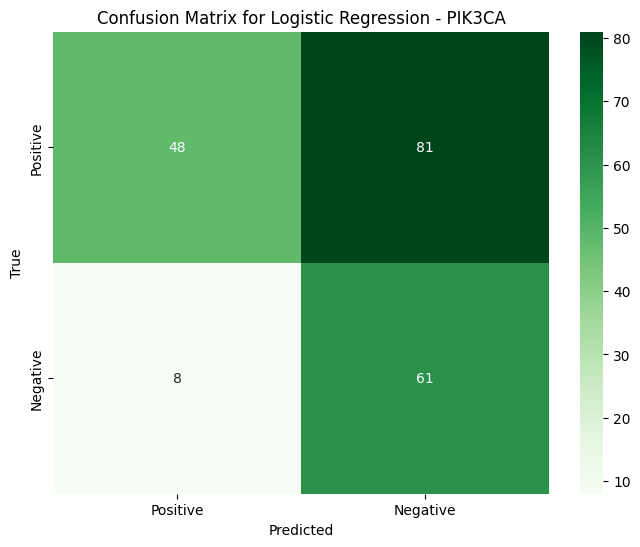

Additional Evaluation Metrics:
   Test Accuracy  Test Precision  Test Recall   Test F1  Test MCC
0       0.550505        0.429577     0.884058  0.578199  0.271005

Evaluating model: Random Forest for driver: PIK3CA
Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
           Model  CV Accuracy  CV Precision  CV Recall     CV F1    CV MCC
0  Random Forest     0.927856      0.929347   0.927856  0.925922  0.815377
Classification Report for Random Forest on driver PIK3CA:
              precision    recall  f1-score   support

           0       0.81      0.47      0.60       129
           1       0.45      0.80      0.57        69

    accuracy                           0.59       198
   macro avg       0.63      0.63      0.59       198
weighted avg       0.69      0.59      0.59       198



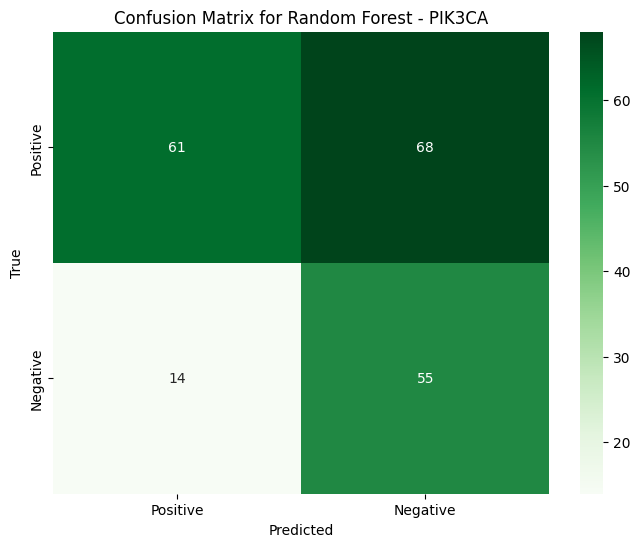

Additional Evaluation Metrics:
   Test Accuracy  Test Precision  Test Recall   Test F1  Test MCC
0       0.585859        0.447154     0.797101  0.572917  0.265186

Evaluating model: XGBoost for driver: PIK3CA


/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Hyperparameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
     Model  CV Accuracy  CV Precision  CV Recall     CV F1    CV MCC
0  XGBoost     0.925189      0.926534   0.925189  0.923077  0.808721
Classification Report for XGBoost on driver PIK3CA:
              precision    recall  f1-score   support

           0       0.81      0.52      0.63       129
           1       0.46      0.77      0.58        69

    accuracy                           0.61       198
   macro avg       0.63      0.64      0.60       198
weighted avg       0.69      0.61      0.61       198



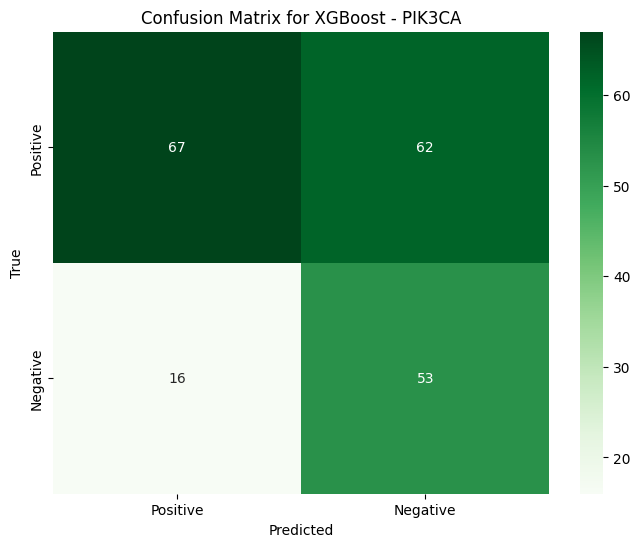

Additional Evaluation Metrics:
   Test Accuracy  Test Precision  Test Recall   Test F1  Test MCC
0       0.606061         0.46087     0.768116  0.576087  0.277628

Processing driver: TP53

Evaluating model: Logistic Regression for driver: TP53


/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

Best Hyperparameters: {'C': 1, 'l1_ratio': 1.0, 'penalty': 'elasticnet', 'solver': 'saga'}
                 Model  CV Accuracy  CV Precision  CV Recall    CV F1  \
0  Logistic Regression     0.977464      0.977507   0.977464  0.97745   

     CV MCC  
0  0.953237  
Classification Report for Logistic Regression on driver TP53:
              precision    recall  f1-score   support

           0       0.88      0.76      0.81       132
           1       0.62      0.79      0.69        66

    accuracy                           0.77       198
   macro avg       0.75      0.77      0.75       198
weighted avg       0.79      0.77      0.77       198



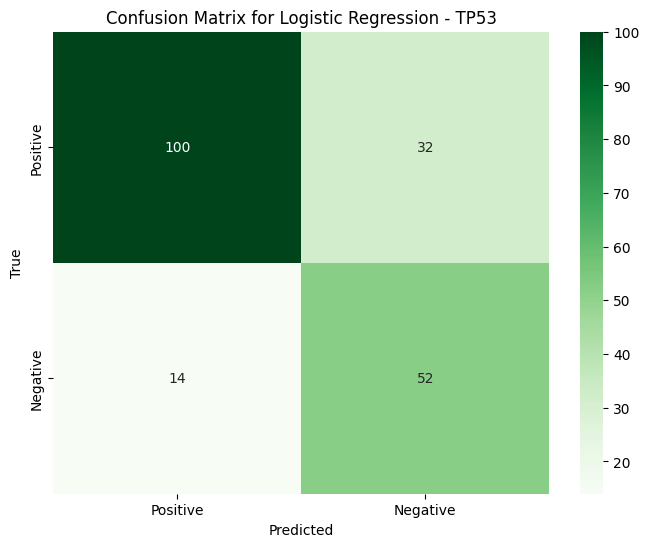

Additional Evaluation Metrics:
   Test Accuracy  Test Precision  Test Recall   Test F1  Test MCC
0       0.767677        0.619048     0.787879  0.693333  0.520266

Evaluating model: Random Forest for driver: TP53
Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
           Model  CV Accuracy  CV Precision  CV Recall     CV F1    CV MCC
0  Random Forest     0.954929      0.955703   0.954929  0.954677  0.906791
Classification Report for Random Forest on driver TP53:
              precision    recall  f1-score   support

           0       0.87      0.83      0.84       132
           1       0.68      0.74      0.71        66

    accuracy                           0.80       198
   macro avg       0.77      0.78      0.78       198
weighted avg       0.80      0.80      0.80       198



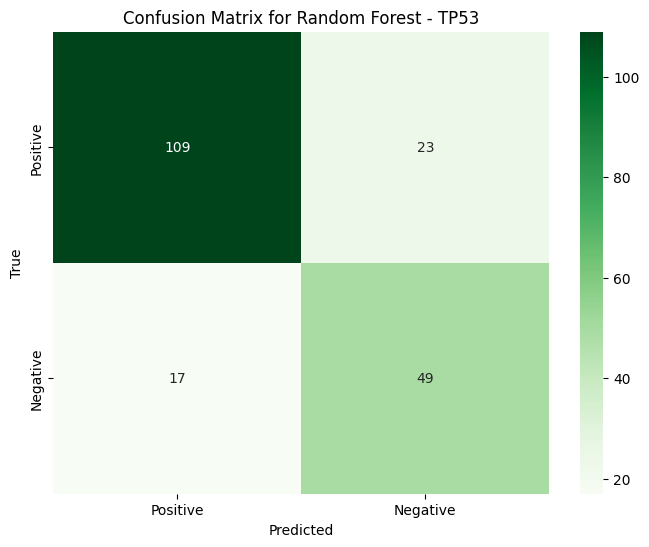

Additional Evaluation Metrics:
   Test Accuracy  Test Precision  Test Recall   Test F1  Test MCC
0        0.79798        0.680556     0.742424  0.710145  0.556794

Evaluating model: XGBoost for driver: TP53


/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Hyperparameters: {'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.7}
     Model  CV Accuracy  CV Precision  CV Recall     CV F1    CV MCC
0  XGBoost     0.964327      0.964507   0.964327  0.964223  0.925918
Classification Report for XGBoost on driver TP53:
              precision    recall  f1-score   support

           0       0.88      0.77      0.82       132
           1       0.63      0.79      0.70        66

    accuracy                           0.77       198
   macro avg       0.75      0.78      0.76       198
weighted avg       0.79      0.77      0.78       198



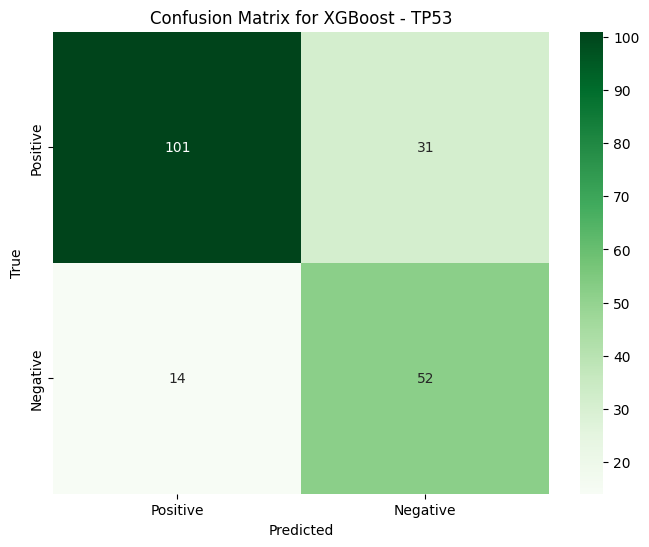

Additional Evaluation Metrics:
   Test Accuracy  Test Precision  Test Recall   Test F1  Test MCC
0       0.772727        0.626506     0.787879  0.697987  0.528348

Processing driver: CDH1

Evaluating model: Logistic Regression for driver: CDH1
Best Hyperparameters: {'C': 10, 'l1_ratio': 0.0, 'penalty': 'elasticnet', 'solver': 'saga'}
                 Model  CV Accuracy  CV Precision  CV Recall    CV F1  \
0  Logistic Regression     0.821108      0.822709   0.821108  0.81614   

     CV MCC  
0  0.608264  
Classification Report for Logistic Regression on driver CDH1:
              precision    recall  f1-score   support

           0       0.96      0.53      0.69       172
           1       0.22      0.85      0.34        26

    accuracy                           0.58       198
   macro avg       0.59      0.69      0.52       198
weighted avg       0.86      0.58      0.64       198



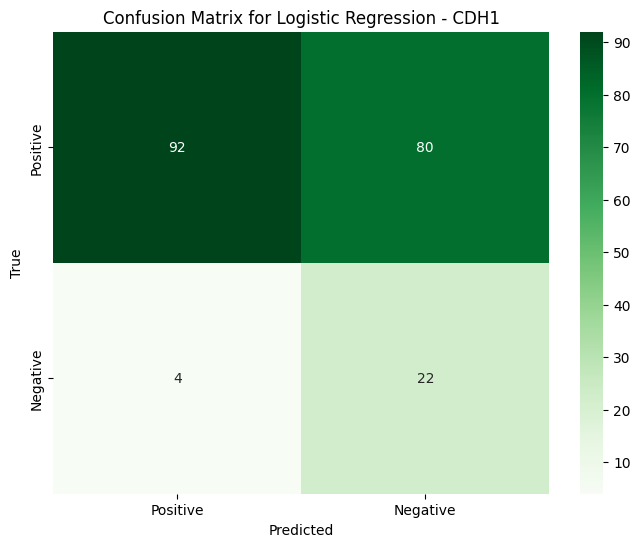

Additional Evaluation Metrics:
   Test Accuracy  Test Precision  Test Recall  Test F1  Test MCC
0       0.575758        0.215686     0.846154  0.34375  0.257503

Evaluating model: Random Forest for driver: CDH1
Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
           Model  CV Accuracy  CV Precision  CV Recall     CV F1    CV MCC
0  Random Forest     0.942051      0.944251   0.942051  0.941181  0.876051
Classification Report for Random Forest on driver CDH1:
              precision    recall  f1-score   support

           0       0.95      0.70      0.81       172
           1       0.27      0.73      0.40        26

    accuracy                           0.71       198
   macro avg       0.61      0.72      0.60       198
weighted avg       0.86      0.71      0.75       198



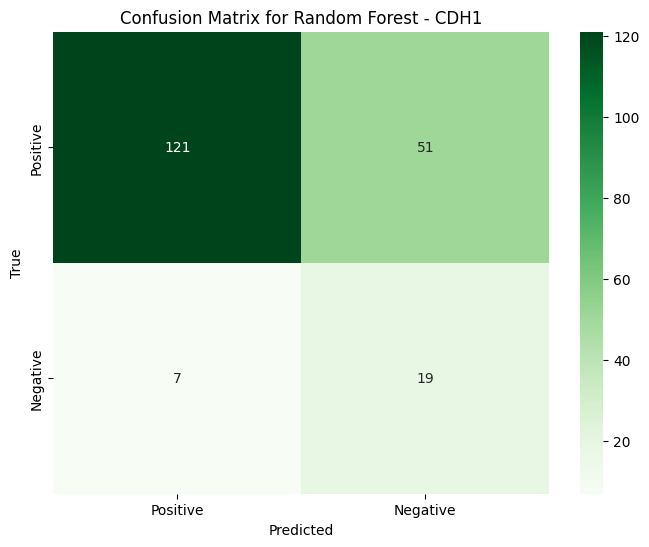

Additional Evaluation Metrics:
   Test Accuracy  Test Precision  Test Recall   Test F1  Test MCC
0       0.707071        0.271429     0.730769  0.395833  0.306792

Evaluating model: XGBoost for driver: CDH1


/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Hyperparameters: {'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.8}
     Model  CV Accuracy  CV Precision  CV Recall     CV F1    CV MCC
0  XGBoost     0.953664        0.9556   0.953664  0.953052  0.901194
Classification Report for XGBoost on driver CDH1:
              precision    recall  f1-score   support

           0       0.93      0.69      0.79       172
           1       0.24      0.65      0.35        26

    accuracy                           0.69       198
   macro avg       0.59      0.67      0.57       198
weighted avg       0.84      0.69      0.74       198



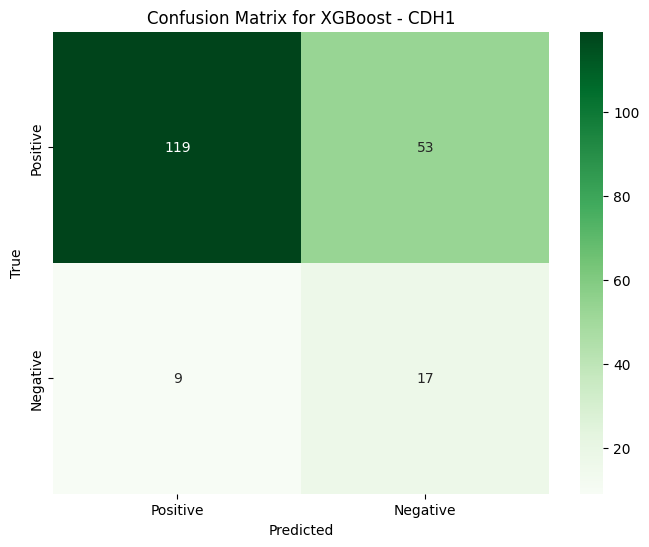

Additional Evaluation Metrics:
   Test Accuracy  Test Precision  Test Recall   Test F1  Test MCC
0       0.686869        0.242857     0.653846  0.354167  0.244233

Processing driver: GATA3

Evaluating model: Logistic Regression for driver: GATA3
Best Hyperparameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'elasticnet', 'solver': 'saga'}
                 Model  CV Accuracy  CV Precision  CV Recall     CV F1  \
0  Logistic Regression     0.851584      0.853015   0.851584  0.848137   

     CV MCC  
0  0.676569  
Classification Report for Logistic Regression on driver GATA3:
              precision    recall  f1-score   support

           0       0.95      0.45      0.61       174
           1       0.17      0.83      0.29        24

    accuracy                           0.49       198
   macro avg       0.56      0.64      0.45       198
weighted avg       0.86      0.49      0.57       198



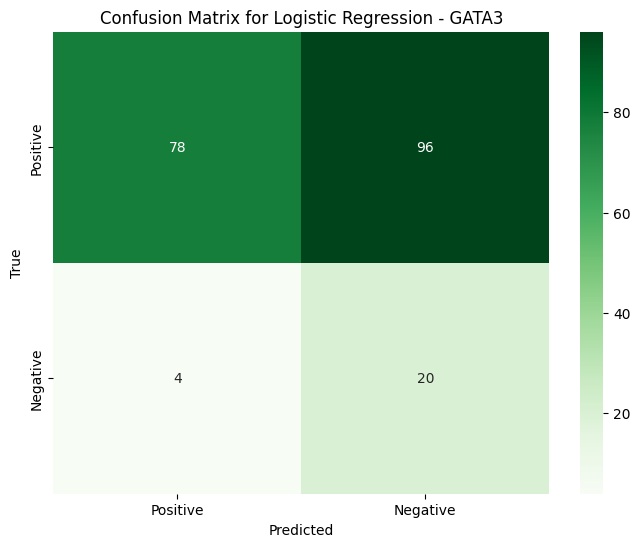

Additional Evaluation Metrics:
   Test Accuracy  Test Precision  Test Recall   Test F1  Test MCC
0       0.494949        0.172414     0.833333  0.285714  0.186591

Evaluating model: Random Forest for driver: GATA3
Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
           Model  CV Accuracy  CV Precision  CV Recall     CV F1    CV MCC
0  Random Forest     0.961328       0.96246   0.961328  0.960968  0.917393
Classification Report for Random Forest on driver GATA3:
              precision    recall  f1-score   support

           0       0.92      0.66      0.77       174
           1       0.19      0.58      0.29        24

    accuracy                           0.65       198
   macro avg       0.55      0.62      0.53       198
weighted avg       0.83      0.65      0.71       198



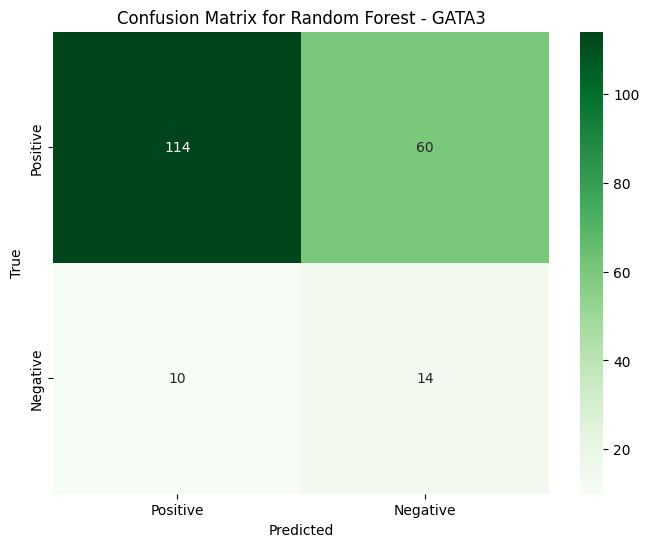

Additional Evaluation Metrics:
   Test Accuracy  Test Precision  Test Recall   Test F1  Test MCC
0       0.646465        0.189189     0.583333  0.285714  0.160899

Evaluating model: XGBoost for driver: GATA3
Best Hyperparameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.7}
     Model  CV Accuracy  CV Precision  CV Recall     CV F1    CV MCC
0  XGBoost      0.95757      0.958825    0.95757  0.957092  0.909273
Classification Report for XGBoost on driver GATA3:
              precision    recall  f1-score   support

           0       0.96      0.66      0.78       174
           1       0.24      0.79      0.37        24

    accuracy                           0.68       198
   macro avg       0.60      0.73      0.58       198
weighted avg       0.87      0.68      0.73       198



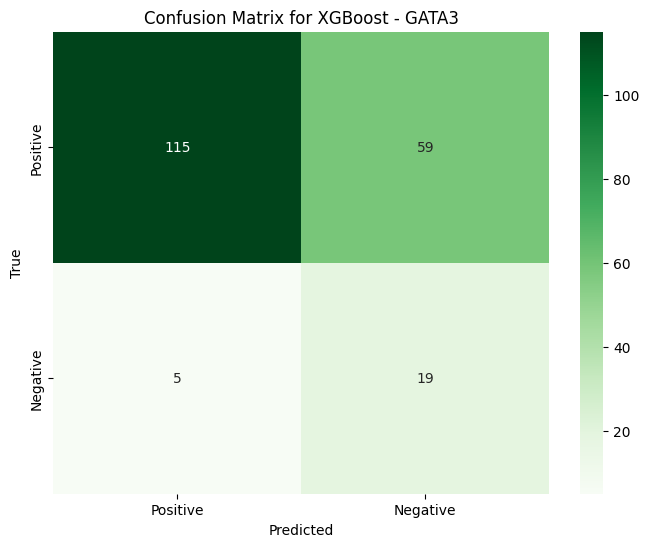

Additional Evaluation Metrics:
   Test Accuracy  Test Precision  Test Recall   Test F1  Test MCC
0       0.676768         0.24359     0.791667  0.372549  0.302304



In [23]:
# Preprocess the data for each driver
for driver, combined_df in driver_combined_dfs.items():
    print(f"Processing driver: {driver}")
    
    # Preprocess data
    preprocessed_data = preprocess_data(combined_df)
    
    # Store the preprocessed data in the results dictionary
    results[driver] = preprocessed_data
    
    # Evaluate the models on the preprocessed data
    model_results = evaluate_models(driver, preprocessed_data, models_and_params)
    
    # Store the model results in the results dictionary
    results[driver]['model_results'] = model_results

    print("\n" + "="*50)  # Separator between drivers


In [19]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import numpy as np

# Function to preprocess the data
def preprocess_data(combined_df):
    """
    Preprocesses the input dataframe by scaling the data and handling class imbalance.

    Parameters:
    combined_df (pd.DataFrame): The combined dataframe with features and labels.

    Returns:
    dict: A dictionary containing the processed training and testing data.
    """
    # Prepare the data
    X = combined_df.drop(columns=['mutated', 'cancer_type'])
    y = combined_df['mutated'].astype(int)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
    
    # Scale the data
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Handle class imbalance using SMOTEENN
    smote = SMOTEENN(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

    # Return the processed data
    return {
        'X_train_resampled': X_train_resampled,
        'y_train_resampled': y_train_resampled,
        'X_test_scaled': X_test_scaled,
        'y_test': y_test
    }

# Function to evaluate models and gather metrics
def evaluate_models(driver, preprocessed_data, models_and_params):
    """
    Evaluates the provided models on the preprocessed data and stores the results.

    Parameters:
    driver (str): The name of the driver being processed.
    preprocessed_data (dict): The preprocessed data returned from preprocess_data function.
    models_and_params (dict): A dictionary of models and their hyperparameter grids.

    Returns:
    pd.DataFrame: DataFrame containing evaluation metrics for each model.
    """
    results = []
    X_train_resampled = preprocessed_data['X_train_resampled']
    y_train_resampled = preprocessed_data['y_train_resampled']
    X_test_scaled = preprocessed_data['X_test_scaled']
    y_test = preprocessed_data['y_test']
    
    for model_name, (model, params) in models_and_params.items():
        print(f"\nEvaluating model: {model_name} for driver: {driver}")
        
        # Suprimir warnings de convergência durante a validação cruzada e treinamento
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ConvergenceWarning)
            
            best_model, eval_df, best_params = classification_scores(
                model_name, model, params, X_train_resampled, y_train_resampled, metric="f1"
            )
        
        print("Best Hyperparameters:", best_params)

        # Predict on the test set
        y_pred = best_model.predict(X_test_scaled)
        
        # Calculate evaluation metrics
        metrics = {
            'Driver': driver,
            'Model': model_name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1 Score': f1_score(y_test, y_pred),
            'MCC': matthews_corrcoef(y_test, y_pred)
        }
        
        results.append(metrics)
    
    # Return a DataFrame of all metrics
    return pd.DataFrame(results)

# Define hyperparameter grids for each model
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['elasticnet'],
    'solver': ['saga'],
    'l1_ratio': np.linspace(0, 1, 11) 
}

param_grid_rf = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_xgb = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Define models and their hyperparameter grids
models_and_params = {
    "Logistic Regression": (LogisticRegression(random_state=42), param_grid_lr),
    "Random Forest": (RandomForestClassifier(random_state=42), param_grid_rf),
    "XGBoost": (XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'), param_grid_xgb)
}

# Process data and evaluate models for each driver
all_metrics = []  # To store metrics for all drivers and models

for driver, combined_df in driver_combined_dfs.items():
    print(f"Processing driver: {driver}")
    
    # Preprocess data
    preprocessed_data = preprocess_data(combined_df)
    
    # Evaluate models and gather metrics
    driver_metrics = evaluate_models(driver, preprocessed_data, models_and_params)
    
    # Append to the final metrics list
    all_metrics.append(driver_metrics)

    print("\n" + "="*50)  # Separator between drivers

# Concatenate all metrics into one DataFrame for easier comparison
final_metrics_df = pd.concat(all_metrics, ignore_index=True)

# Display or save the final metrics DataFrame
print(final_metrics_df)


Processing driver: PIK3CA

Evaluating model: Logistic Regression for driver: PIK3CA


/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

Best Hyperparameters: {'C': 0.1, 'l1_ratio': 0.0, 'penalty': 'elasticnet', 'solver': 'saga'}

Evaluating model: Random Forest for driver: PIK3CA
Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}

Evaluating model: XGBoost for driver: PIK3CA


/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Hyperparameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}

Processing driver: TP53

Evaluating model: Logistic Regression for driver: TP53


/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

Best Hyperparameters: {'C': 1, 'l1_ratio': 1.0, 'penalty': 'elasticnet', 'solver': 'saga'}

Evaluating model: Random Forest for driver: TP53
Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}

Evaluating model: XGBoost for driver: TP53


/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Hyperparameters: {'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.7}

Processing driver: CDH1

Evaluating model: Logistic Regression for driver: CDH1
Best Hyperparameters: {'C': 10, 'l1_ratio': 0.0, 'penalty': 'elasticnet', 'solver': 'saga'}

Evaluating model: Random Forest for driver: CDH1
Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Evaluating model: XGBoost for driver: CDH1
Best Hyperparameters: {'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.8}

Processing driver: GATA3

Evaluating model: Logistic Regression for driver: GATA3
Best Hyperparameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'elasticnet', 'solver': 'saga'}

Evaluating model: Random Forest for driver: GATA3
Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}

Evaluating model: XGBoost for driver:

In [20]:
display(final_metrics_df)

Driver                Model  Accuracy  Precision    Recall  F1 Score  \
0   PIK3CA  Logistic Regression  0.550505   0.429577  0.884058  0.578199   
1   PIK3CA        Random Forest  0.585859   0.447154  0.797101  0.572917   
2   PIK3CA              XGBoost  0.606061   0.460870  0.768116  0.576087   
3     TP53  Logistic Regression  0.767677   0.619048  0.787879  0.693333   
4     TP53        Random Forest  0.797980   0.680556  0.742424  0.710145   
5     TP53              XGBoost  0.772727   0.626506  0.787879  0.697987   
6     CDH1  Logistic Regression  0.575758   0.215686  0.846154  0.343750   
7     CDH1        Random Forest  0.707071   0.271429  0.730769  0.395833   
8     CDH1              XGBoost  0.686869   0.242857  0.653846  0.354167   
9    GATA3  Logistic Regression  0.494949   0.172414  0.833333  0.285714   
10   GATA3        Random Forest  0.646465   0.189189  0.583333  0.285714   
11   GATA3              XGBoost  0.676768   0.243590  0.791667  0.372549   

         MCC  
0   0.271005  
1   0.265186  
2   0.277628  
3   0.520266  
4   0.556794  
5   0.528348  
6   0.257503  
7   0.306792  
8   0.244233  
9   0.186591  
10  0.160899  
11  0.302304

In [ ]:
import warnings
from sklearn.exceptions import ConvergenceWarning
import warnings

warnings.filterwarnings("ignore")

# Initialize the results dictionary to store evaluation results for each driver
results = {}

# Define models and their hyperparameter grids
models_and_params = {
    "Logistic Regression": (LogisticRegression(random_state=42), param_grid_lr),
    "Random Forest": (RandomForestClassifier(random_state=42), param_grid_rf),
    "XGBoost": (XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'), param_grid_xgb)
}

# Loop through each driver and its corresponding data
for driver, combined_df in driver_combined_dfs.items():
    print(f"Processing driver: {driver}")
    
    # Prepare the data
    X = combined_df.drop(columns=['mutated', 'cancer_type'])
    y = combined_df['mutated'].astype(int)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
    print(f'Training set: {X_train.shape}')
    print(f'Testing set: {X_test.shape}')

    # Scale the data
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Handle class imbalance using SMOTEENN
    smote = SMOTEENN(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

    # Store the resampled data for further use
    results[driver] = {
        'X_train_resampled': X_train_resampled,
        'y_train_resampled': y_train_resampled,
        'X_test_scaled': X_test_scaled,
        'y_test': y_test
    }
    
    # Run the classification for each model
    for model_name, (model, params) in models_and_params.items():
        print(f"\nEvaluating model: {model_name} for driver: {driver}")
        
        # Use the classification_scores function to get the best model and evaluation dataframe
        best_model, eval_df, best_params = classification_scores(model_name, model, params, X_train_resampled, y_train_resampled, metric="f1")
        
        print("Best Hyperparameters:", best_params)
        print(eval_df)

        # Predict on the test set
        y_pred = best_model.predict(X_test_scaled)
        
        # Generate and display the classification report
        print(f"Classification Report for {model_name} on driver {driver}:")
        print(classification_report(y_test, y_pred))

        # Plot the confusion matrix
        classification_plot(y_test, y_pred)

        # Calculate additional evaluation metrics
        evaluation_results = classification_evaluation(y_test, y_pred)
        print("Additional Evaluation Metrics:")
        print(evaluation_results)

        # Optionally, store the results for this model and driver combination
        results[driver][model_name] = {
            'Best_Model': best_model,
            'Evaluation_Results': evaluation_results,
            'Best_Params': best_params
        }

    print("\n" + "="*50)  # Separator between drivers


In [ ]:
logistic_regression = LogisticRegression(random_state=42)

best_model, eval_df, best_params = classification_scores("Logistic Regression", logistic_regression, param_grid_lr, X_train_resampled, y_train_resampled)

print("Best Hyperparameters:", best_params)

y_IVS_pred = best_model.predict(X_test_scaled)

print("Classification Report for IVS:")
print(classification_report(y_test, y_IVS_pred))

classification_plot(y_test, y_IVS_pred)

evaluation_results = classification_evaluation(y_test, y_IVS_pred)
print("Additional Evaluation Metrics:")
print(evaluation_results)

In [31]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [32]:
grid_search_lr = GridSearchCV(
    LogisticRegression(),
    param_grid=param_grid_lr,
    scoring='f1',  # ou 'roc_auc'
    cv=skf,
    n_jobs=-1
)
grid_search_lr.fit(X_train_resampled, y_train_resampled)


/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'penalty': ['elasticnet'], 'solver': ['saga']},
             scoring='f1')

In [ ]:
random_search_rf = RandomizedSearchCV(
    RandomForestClassifier(),
    param_distributions=param_grid_rf,
    n_iter=50,  # número de combinações para tentar
    scoring='f1',  # ou 'roc_auc'
    cv=skf,
    n_jobs=-1,
    random_state=42
)
random_search_rf.fit(X_train_resampled, y_train_resampled)


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(), n_iter=50, n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20, 30],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 500]},
                   random_state=42, scoring='f1')

In [ ]:
random_search_xgb = RandomizedSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    param_distributions=param_grid_xgb,
    n_iter=50,
    scoring='f1',  # ou 'roc_auc'
    cv=skf,
    n_jobs=-1,
    random_state=42
)
random_search_xgb.fit(X_train_resampled, y_train_resampled)


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           imp...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 0.8, 0.9],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [100, 200, 500],
                                        'subsample': [0.7, 0.8, 0.9]},
                   random_state=42, scoring='f1')

In [ ]:
best_model_lr = grid_search_lr.best_estimator_
y_pred_lr = best_model_lr.predict(X_test_scaled)
print("F1-Score Logistic Regression:", f1_score(y_test, y_pred_lr))
print("ROC-AUC Logistic Regression:", roc_auc_score(y_test, y_pred_lr))

best_model_rf = random_search_rf.best_estimator_
y_pred_rf = best_model_rf.predict(X_test_scaled)
print("F1-Score Random Forest:", f1_score(y_test, y_pred_rf))
print("ROC-AUC Random Forest:", roc_auc_score(y_test, y_pred_rf))

best_model_xgb = random_search_xgb.best_estimator_
y_pred_xgb = best_model_xgb.predict(X_test_scaled)
print("F1-Score XGBoost:", f1_score(y_test, y_pred_xgb))
print("ROC-AUC XGBoost:", roc_auc_score(y_test, y_pred_xgb))


In [18]:
""" from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score

def evaluate_model(y_true, y_pred, y_prob):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-score': f1_score(y_true, y_pred),
        'AUC-ROC': roc_auc_score(y_true, y_prob)
    }

models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42)
}

for driver, data in results.items():
    print(f"\nProcessing driver: {driver}")
    X_train = data['X_train_resampled']
    y_train = data['y_train_resampled']
    X_test = data['X_test_scaled']
    y_test = data['y_test']
    
    for model_name, model in models.items():
        print(f"\nTraining {model_name}...")
        
        # Treinar o modelo
        model.fit(X_train, y_train)
        
        # Fazer previsões
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
        
        # Avaliar o modelo
        eval_metrics = evaluate_model(y_test, y_pred, y_prob)
        
        print(f"{model_name} Performance:")
        for metric, value in eval_metrics.items():
            print(f"{metric}: {value:.4f}")
        
        # Validação cruzada
        cv_scores = cross_val_score(model, X_train, y_train, cv=5)
        print(f"Cross-validation scores: {cv_scores}")
        print(f"Mean CV score: {cv_scores.mean():.4f}")

    print("\n" + "="*50) """


Processing driver: PIK3CA

Training Logistic Regression...
Logistic Regression Performance:
Accuracy: 0.5808
Precision: 0.4521
Recall: 0.9565
F1-score: 0.6140
AUC-ROC: 0.7343
Cross-validation scores: [0.9382716  0.97530864 0.9875     0.9375     0.9625    ]
Mean CV score: 0.9602

Training Random Forest...
Random Forest Performance:
Accuracy: 0.5202
Precision: 0.4188
Recall: 0.9710
F1-score: 0.5852
AUC-ROC: 0.7208
Cross-validation scores: [0.95061728 0.95061728 0.9625     0.9375     0.95      ]
Mean CV score: 0.9502

Training XGBoost...
XGBoost Performance:
Accuracy: 0.5606
Precision: 0.4384
Recall: 0.9275
F1-score: 0.5953
AUC-ROC: 0.7121
Cross-validation scores: [0.95061728 0.9382716  0.9625     0.9625     0.9625    ]
Mean CV score: 0.9553


Processing driver: TP53

Training Logistic Regression...
Logistic Regression Performance:
Accuracy: 0.8283
Precision: 0.6860
Recall: 0.8939
F1-score: 0.7763
AUC-ROC: 0.9152
Cross-validation scores: [0.97345133 0.99107143 1.         0.98214286 0.973

In [19]:
""" from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer, average_precision_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import numpy as np

def evaluate_model(y_true, y_pred, y_prob):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-score': f1_score(y_true, y_pred),
        'AUC-ROC': roc_auc_score(y_true, y_prob),
        'AUC-PR': average_precision_score(y_true, y_prob)
    }

# Definir os modelos e seus respectivos hiperparâmetros para busca
models = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42),
        'params': {
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear', 'saga'],
            'class_weight': [None, 'balanced']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 5, 10, 15],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'class_weight': [None, 'balanced', 'balanced_subsample']
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.3],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0],
            'scale_pos_weight': [1, 5, 10]
        }
    }
}

# Definir uma métrica personalizada para otimização (F1-score e AUC-ROC)
def custom_scorer(y_true, y_pred):
    f1 = f1_score(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_pred)
    return (f1 + auc_roc) / 2 # está mal, ou uso um ou outro

custom_scorer = make_scorer(custom_scorer, greater_is_better=True)

# Definir o StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results_summary = {}

for driver, data in results.items():
    print(f"\nProcessing driver: {driver}")
    X_train = data['X_train_resampled']
    y_train = data['y_train_resampled']
    X_test = data['X_test_scaled']
    y_test = data['y_test']
    
    driver_results = {}
    
    for model_name, model_info in models.items():
        print(f"\nOptimizing {model_name}...")
        
        # Realizar busca de hiperparâmetros com StratifiedKFold
        grid_search = GridSearchCV(model_info['model'], model_info['params'], 
                                   cv=skf, scoring=custom_scorer, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        
        # Obter o melhor modelo
        best_model = grid_search.best_estimator_
        
        # Fazer previsões
        y_pred = best_model.predict(X_test)
        y_prob = best_model.predict_proba(X_test)[:, 1]
        
        # Avaliar o modelo
        eval_metrics = evaluate_model(y_test, y_pred, y_prob)
        
        print(f"{model_name} Performance:")
        for metric, value in eval_metrics.items():
            print(f"{metric}: {value:.4f}")
        
        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
        
        # Realizar validação cruzada estratificada manual para obter scores por fold
        cv_scores = []
        for train_index, val_index in skf.split(X_train, y_train):
            X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
            
            best_model.fit(X_train_fold, y_train_fold)
            y_val_pred = best_model.predict(X_val_fold)
            cv_scores.append(f1_score(y_val_fold, y_val_pred))
        
        print(f"Cross-validation F1-scores: {cv_scores}")
        print(f"Mean CV F1-score: {np.mean(cv_scores):.4f}")
        
        # Armazenar resultados
        driver_results[model_name] = {
            'best_params': grid_search.best_params_,
            'best_cv_score': grid_search.best_score_,
            'cv_scores': cv_scores,
            'test_metrics': eval_metrics
        }
    
    results_summary[driver] = driver_results
    print("\n" + "="*50)

# Imprimir um resumo dos resultados
for driver, models_results in results_summary.items():
    print(f"\nSummary for driver: {driver}")
    for model_name, model_results in models_results.items():
        print(f"\n{model_name}:")
        print(f"Best parameters: {model_results['best_params']}")
        print(f"Best CV score (F1 + AUC-ROC average): {model_results['best_cv_score']:.4f}")
        print(f"CV F1-scores: {model_results['cv_scores']}")
        print(f"Mean CV F1-score: {np.mean(model_results['cv_scores']):.4f}")
        print("Test set metrics:")
        for metric, value in model_results['test_metrics'].items():
            print(f"  {metric}: {value:.4f}")
    print("\n" + "="*50) """


Processing driver: PIK3CA

Optimizing Logistic Regression...


/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

Logistic Regression Performance:
Accuracy: 0.6061
Precision: 0.4667
Recall: 0.9130
F1-score: 0.6176
AUC-ROC: 0.7559
AUC-PR: 0.6363
Best parameters: {'C': 0.01, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation score: 0.9678
Cross-validation F1-scores: [0.9848484848484849, 0.9848484848484849, 0.9774436090225563, 0.9922480620155039, 0.9767441860465116]
Mean CV F1-score: 0.9832

Optimizing Random Forest...
Random Forest Performance:
Accuracy: 0.5303
Precision: 0.4221
Recall: 0.9420
F1-score: 0.5830
AUC-ROC: 0.6968
AUC-PR: 0.5562
Best parameters: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation score: 0.9464
Cross-validation F1-scores: [0.9777777777777777, 0.9770992366412213, 0.9774436090225563, 0.9846153846153847, 0.9701492537313433]
Mean CV F1-score: 0.9774

Optimizing XGBoost...
XGBoost Performance:
Accuracy: 0.5354
Precision: 0.4238
Recall: 0.9275
F1-score: 0.5818

/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

Logistic Regression Performance:
Accuracy: 0.8586
Precision: 0.7317
Recall: 0.9091
F1-score: 0.8108
AUC-ROC: 0.9230
AUC-PR: 0.8685
Best parameters: {'C': 10, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation score: 0.9875
Cross-validation F1-scores: [0.9777777777777777, 0.9850746268656716, 1.0, 0.9850746268656716, 1.0]
Mean CV F1-score: 0.9896

Optimizing Random Forest...
Random Forest Performance:
Accuracy: 0.8333
Precision: 0.7200
Recall: 0.8182
F1-score: 0.7660
AUC-ROC: 0.8862
AUC-PR: 0.7670
Best parameters: {'class_weight': 'balanced_subsample', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation score: 0.9780
Cross-validation F1-scores: [0.9770992366412213, 0.9924812030075187, 0.96875, 0.9846153846153847, 0.9696969696969697]
Mean CV F1-score: 0.9785

Optimizing XGBoost...
XGBoost Performance:
Accuracy: 0.7727
Precision: 0.6154
Recall: 0.8485
F1-score: 0.7134
AUC-ROC: 0.8804
AUC-PR: 0.

/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

Logistic Regression Performance:
Accuracy: 0.7929
Precision: 0.3770
Recall: 0.8846
F1-score: 0.5287
AUC-ROC: 0.9072
AUC-PR: 0.5148
Best parameters: {'C': 10, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation score: 0.9866
Cross-validation F1-scores: [0.9951219512195122, 0.9902912621359223, 1.0, 0.9856459330143541, 1.0]
Mean CV F1-score: 0.9942

Optimizing Random Forest...
Random Forest Performance:
Accuracy: 0.6515
Precision: 0.2529
Recall: 0.8462
F1-score: 0.3894
AUC-ROC: 0.8596
AUC-PR: 0.4770
Best parameters: {'class_weight': None, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation score: 0.9789
Cross-validation F1-scores: [0.9902912621359223, 0.9901960784313726, 0.9951219512195122, 0.976303317535545, 1.0]
Mean CV F1-score: 0.9904

Optimizing XGBoost...
XGBoost Performance:
Accuracy: 0.7980
Precision: 0.3906
Recall: 0.9615
F1-score: 0.5556
AUC-ROC: 0.9155
AUC-PR: 0.5671
Best parameters: 

/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

Logistic Regression Performance:
Accuracy: 0.6465
Precision: 0.2386
Recall: 0.8750
F1-score: 0.3750
AUC-ROC: 0.8185
AUC-PR: 0.4702
Best parameters: {'C': 1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'}
Best cross-validation score: 0.9636
Cross-validation F1-scores: [0.976303317535545, 0.9811320754716981, 0.9765258215962441, 0.9856459330143541, 0.9951690821256038]
Mean CV F1-score: 0.9830

Optimizing Random Forest...
Random Forest Performance:
Accuracy: 0.4899
Precision: 0.1652
Recall: 0.7917
F1-score: 0.2734
AUC-ROC: 0.7098
AUC-PR: 0.2889
Best parameters: {'class_weight': None, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation score: 0.9440
Cross-validation F1-scores: [0.9760765550239234, 0.9719626168224299, 0.9585253456221198, 0.976303317535545, 0.9856459330143541]
Mean CV F1-score: 0.9737

Optimizing XGBoost...
XGBoost Performance:
Accuracy: 0.5051
Precision: 0.1864
Recall: 0.9167
F1-score: 0.3099
AUC-ROC: 0

In [24]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from scipy.stats import randint, uniform

def nested_cv(model, params, X, y, cv_outer=5, cv_inner=3):
    outer_cv = StratifiedKFold(n_splits=cv_outer, shuffle=True, random_state=42)
    inner_cv = StratifiedKFold(n_splits=cv_inner, shuffle=True, random_state=42)
    
    outer_scores = []

    for train_idx, val_idx in outer_cv.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Apply SMOTE to handle class imbalance
        smote = SMOTEENN(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
        
        # Randomized search with cross-validation
        search = RandomizedSearchCV(model, params, n_iter=50, cv=inner_cv, scoring='f1', n_jobs=-1, random_state=42)
        search.fit(X_train_resampled, y_train_resampled)
        
        # Get the best model
        best_model = search.best_estimator_
        
        # Evaluate on validation set
        y_pred = best_model.predict(X_val)
        outer_scores.append(f1_score(y_val, y_pred))
    
    return np.mean(outer_scores), np.std(outer_scores)

# Define models with regularization and complexity control
log_reg = LogisticRegression(random_state=42, max_iter=1000)
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)

# Define parameter grids for each model
log_reg_params = {
    'C': np.logspace(-4, 4, 20),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'class_weight': [None, 'balanced']
}

rf_params = {
    'n_estimators': randint(50, 500),
    'max_depth': [None] + list(randint(5, 50).rvs(10)),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'class_weight': [None, 'balanced', 'balanced_subsample']
}

xgb_params = {
    'n_estimators': randint(50, 500),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 5),
    'min_child_weight': randint(1, 10),
    'scale_pos_weight': uniform(1, 10)
}

models = [
    ('Logistic Regression', log_reg, log_reg_params),
    ('Random Forest', rf, rf_params),
    ('XGBoost', xgb, xgb_params)
]

for driver, data in results.items():
    print(f"\nProcessing driver: {driver}")
    X_train = data['X_train_resampled']
    y_train = data['y_train_resampled']
    X_test = data['X_test_scaled']
    y_test = data['y_test']
    
    for name, model, params in models:
        mean_score, std_score = nested_cv(model, params, X_train, y_train)
        print(f"{name} - Mean F1: {mean_score:.3f} (+/- {std_score:.3f})")

    # Train final models using the entire training set
    final_models = {}
    for name, model, params in models:
        search = RandomizedSearchCV(model, params, n_iter=100, cv=5, scoring='f1', n_jobs=-1, random_state=42)
        search.fit(X_train, y_train)
        final_models[name] = search.best_estimator_

    # Create a voting classifier
    voting_clf = VotingClassifier(
        estimators=[(name, model) for name, model in final_models.items()],
        voting='soft'
    )
    voting_clf.fit(X_train, y_train)

    # Evaluate all models on the test set
    for name, model in final_models.items():
        y_pred = model.predict(X_test)
        print(f"\n{name} Test Results:")
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
        print(f"F1 Score: {f1_score(y_test, y_pred):.3f}")
        print(f"ROC AUC: {roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]):.3f}")
        print("Confusion Matrix:")
        print(confusion_matrix(y_test, y_pred))

    # Evaluate the voting classifier
    y_pred_voting = voting_clf.predict(X_test)
    print("\nVoting Classifier Test Results:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_voting):.3f}")
    print(f"F1 Score: {f1_score(y_test, y_pred_voting):.3f}")
    print(f"ROC AUC: {roc_auc_score(y_test, voting_clf.predict_proba(X_test)[:, 1]):.3f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred_voting))

    # Analyze misclassifications
    def analyze_misclassifications(X, y_true, y_pred):
        misclassified = X[y_true != y_pred]
        misclassified_true = y_true[y_true != y_pred]
        misclassified_pred = y_pred[y_true != y_pred]
        
        print("Misclassification Analysis:")
        print("Number of misclassifications:", len(misclassified))
        print("\nMost common misclassifications:")
        print(np.unique(list(zip(misclassified_true, misclassified_pred)), return_counts=True))

    analyze_misclassifications(X_test, y_test, y_pred_voting)

    print("\n" + "="*50)


Processing driver: PIK3CA


/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

Logistic Regression - Mean F1: 0.979 (+/- 0.010)
Random Forest - Mean F1: 0.979 (+/- 0.009)
XGBoost - Mean F1: 0.978 (+/- 0.009)


/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User


Logistic Regression Test Results:
Accuracy: 0.596
F1 Score: 0.608
ROC AUC: 0.725
Confusion Matrix:
[[56 73]
 [ 7 62]]

Random Forest Test Results:
Accuracy: 0.530
F1 Score: 0.583
ROC AUC: 0.703
Confusion Matrix:
[[40 89]
 [ 4 65]]

XGBoost Test Results:
Accuracy: 0.520
F1 Score: 0.574
ROC AUC: 0.706
Confusion Matrix:
[[39 90]
 [ 5 64]]

Voting Classifier Test Results:
Accuracy: 0.576
F1 Score: 0.607
ROC AUC: 0.713
Confusion Matrix:
[[49 80]
 [ 4 65]]
Misclassification Analysis:
Number of misclassifications: 84

Most common misclassifications:
(array([0, 1]), array([84, 84]))


Processing driver: TP53


/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

Logistic Regression - Mean F1: 0.987 (+/- 0.009)
Random Forest - Mean F1: 0.975 (+/- 0.010)
XGBoost - Mean F1: 0.978 (+/- 0.010)


/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User


Logistic Regression Test Results:
Accuracy: 0.854
F1 Score: 0.803
ROC AUC: 0.923
Confusion Matrix:
[[110  22]
 [  7  59]]

Random Forest Test Results:
Accuracy: 0.818
F1 Score: 0.753
ROC AUC: 0.885
Confusion Matrix:
[[107  25]
 [ 11  55]]

XGBoost Test Results:
Accuracy: 0.788
F1 Score: 0.724
ROC AUC: 0.900
Confusion Matrix:
[[101  31]
 [ 11  55]]

Voting Classifier Test Results:
Accuracy: 0.833
F1 Score: 0.776
ROC AUC: 0.905
Confusion Matrix:
[[108  24]
 [  9  57]]
Misclassification Analysis:
Number of misclassifications: 33

Most common misclassifications:
(array([0, 1]), array([33, 33]))


Processing driver: CDH1


/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

Logistic Regression - Mean F1: 0.989 (+/- 0.009)
Random Forest - Mean F1: 0.991 (+/- 0.009)
XGBoost - Mean F1: 0.990 (+/- 0.008)


/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User


Logistic Regression Test Results:
Accuracy: 0.697
F1 Score: 0.455
ROC AUC: 0.896
Confusion Matrix:
[[113  59]
 [  1  25]]

Random Forest Test Results:
Accuracy: 0.652
F1 Score: 0.389
ROC AUC: 0.854
Confusion Matrix:
[[107  65]
 [  4  22]]

XGBoost Test Results:
Accuracy: 0.737
F1 Score: 0.490
ROC AUC: 0.919
Confusion Matrix:
[[121  51]
 [  1  25]]

Voting Classifier Test Results:
Accuracy: 0.717
F1 Score: 0.472
ROC AUC: 0.912
Confusion Matrix:
[[117  55]
 [  1  25]]
Misclassification Analysis:
Number of misclassifications: 56

Most common misclassifications:
(array([0, 1]), array([56, 56]))


Processing driver: GATA3


/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

Logistic Regression - Mean F1: 0.980 (+/- 0.005)
Random Forest - Mean F1: 0.980 (+/- 0.010)
XGBoost - Mean F1: 0.976 (+/- 0.011)


/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcia/miniconda3/envs/tese/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User


Logistic Regression Test Results:
Accuracy: 0.646
F1 Score: 0.375
ROC AUC: 0.822
Confusion Matrix:
[[107  67]
 [  3  21]]

Random Forest Test Results:
Accuracy: 0.485
F1 Score: 0.282
ROC AUC: 0.693
Confusion Matrix:
[[76 98]
 [ 4 20]]

XGBoost Test Results:
Accuracy: 0.465
F1 Score: 0.284
ROC AUC: 0.702
Confusion Matrix:
[[ 71 103]
 [  3  21]]

Voting Classifier Test Results:
Accuracy: 0.520
F1 Score: 0.307
ROC AUC: 0.800
Confusion Matrix:
[[82 92]
 [ 3 21]]
Misclassification Analysis:
Number of misclassifications: 95

Most common misclassifications:
(array([0, 1]), array([95, 95]))


Processing driver: MUC16
Logistic Regression - Mean F1: 0.782 (+/- 0.022)
Random Forest - Mean F1: 0.967 (+/- 0.007)
XGBoost - Mean F1: 0.949 (+/- 0.006)

Logistic Regression Test Results:
Accuracy: 0.232
F1 Score: 0.174
ROC AUC: 0.582
Confusion Matrix:
[[ 30 148]
 [  4  16]]

Random Forest Test Results:
Accuracy: 0.571
F1 Score: 0.141
ROC AUC: 0.517
Confusion Matrix:
[[106  72]
 [ 13   7]]

XGBoost Test

Métricas de avaliação:

O primeiro código usa apenas F1-score e ROC AUC.
O segundo código utiliza mais métricas: Accuracy, Precision, Recall, F1-score, AUC-ROC e AUC-PR.


Método de busca de hiperparâmetros:

O primeiro código usa RandomizedSearchCV.
O segundo código usa GridSearchCV, que é mais exaustivo.


Definição de parâmetros:

O primeiro código usa distribuições para alguns parâmetros (ex: randint, uniform).
O segundo código usa listas específicas de valores para todos os parâmetros.


Métrica de otimização:

O primeiro código otimiza para F1-score.
O segundo código usa uma métrica personalizada que combina F1-score e AUC-ROC.


Validação cruzada:

O primeiro código usa nested cross-validation.
O segundo código usa uma única camada de validação cruzada com GridSearchCV.


Tratamento de dados:

O primeiro código aplica SMOTE para lidar com o desbalanceamento de classes.
O segundo código não menciona tratamento de desbalanceamento.


Ensemble:

O primeiro código inclui um Voting Classifier.
O segundo código não utiliza ensemble methods.


Análise de resultados:

O primeiro código inclui análise de misclassificações.
O segundo código fornece um resumo mais detalhado dos resultados por driver e modelo.


Paralelização:

O segundo código especifica n_jobs=-1 para paralelização.
O primeiro código não menciona paralelização explicitamente.


Impressão de resultados:

O segundo código fornece um resumo mais detalhado e estruturado dos resultados.

## Logistic Regression

In [44]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
from sklearn.preprocessing import RobustScaler
from imblearn.combine import SMOTEENN

# Função de perda F1
def f1_loss(y_true, y_pred):
    y_pred = tf.cast(tf.greater(y_pred, 0.5), tf.float32)
    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))
    
    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())
    
    f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
    return 1 - f1

# Função para criar o modelo
def create_model(units1=32, units2=16, activation='relu'):
    model = keras.Sequential([
        keras.layers.Dense(units1, activation=activation, input_shape=(X_train_resampled.shape[1],)),
        keras.layers.Dense(units2, activation=activation),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

# Função principal de classificação
def classification_scores(model_builder, parameters, X_train, y_train, custom_loss, n_splits=3, epochs=50, batch_size=32):
    skf = StratifiedKFold(n_splits=n_splits)
    
    best_score = -np.inf
    best_params = None
    best_model = None
    
    scores = {
        'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'mcc': []
    }
    
    for params in parameters:
        fold_scores = {metric: [] for metric in scores.keys()}
        
        for train_index, val_index in skf.split(X_train, y_train):
            X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
            
            model = model_builder(**params)
            model.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])
            
            early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
            
            history = model.fit(X_train_fold, y_train_fold, 
                                epochs=epochs, batch_size=batch_size, 
                                validation_data=(X_val_fold, y_val_fold), 
                                callbacks=[early_stop],
                                verbose=0)
            
            y_pred = model.predict(X_val_fold).round()
            
            fold_scores['accuracy'].append(accuracy_score(y_val_fold, y_pred))
            fold_scores['precision'].append(precision_score(y_val_fold, y_pred, average='weighted'))
            fold_scores['recall'].append(recall_score(y_val_fold, y_pred, average='weighted'))
            fold_scores['f1'].append(f1_score(y_val_fold, y_pred, average='weighted'))
            fold_scores['mcc'].append(matthews_corrcoef(y_val_fold, y_pred))
        
        for metric in scores.keys():
            scores[metric].append(np.mean(fold_scores[metric]))
        
        mean_score = np.mean(scores['mcc'][-1])
        if mean_score > best_score:
            best_score = mean_score
            best_params = params
            best_model = model_builder(**params)
            best_model.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])
            best_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
    
    eval_dict = {
        'Model': ['Custom Keras Model'],
        'CV Accuracy': [np.mean(scores['accuracy'])],
        'CV Precision': [np.mean(scores['precision'])],
        'CV Recall': [np.mean(scores['recall'])],
        'CV F1': [np.mean(scores['f1'])],
        'CV MCC': [np.mean(scores['mcc'])]
    }
    
    eval_df = pd.DataFrame(eval_dict)
    
    return best_model, eval_df, best_params

# Código principal
results = {}
for driver, combined_df in driver_combined_dfs.items():
    X = combined_df.drop(columns=['mutated', 'cancer_type'])
    y = combined_df['mutated'].astype(int)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
    
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    smote = SMOTEENN(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
    
    # Reduzimos o número de combinações de parâmetros
    parameters = [
        {'units1': 32, 'units2': 16, 'activation': 'relu'},
        {'units1': 64, 'units2': 32, 'activation': 'relu'}
    ]
    
    best_model, eval_df, best_params = classification_scores(
        create_model, parameters, X_train_resampled, y_train_resampled, f1_loss,
        n_splits=3, epochs=50, batch_size=32
    )
    
    results[driver] = {
        'best_model': best_model,
        'eval_df': eval_df,
        'best_params': best_params,
        'X_test_scaled': X_test_scaled,
        'y_test': y_test
    }
    
    print(f"Finished processing {driver}")
    print(eval_df)
    print("Best parameters:", best_params)
    print("\n" + "="*50 + "\n")

ValueError: No gradients provided for any variable.

In [45]:
from tensorflow import keras
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
import numpy as np
import pandas as pd

def classification_scores(model_builder, parameters, X_train, y_train, custom_loss, n_splits=5, epochs=100, batch_size=32):
    skf = StratifiedKFold(n_splits=n_splits)
    
    best_score = -np.inf
    best_params = None
    best_model = None
    
    scores = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'mcc': []
    }
    
    for params in parameters:
        fold_scores = {metric: [] for metric in scores.keys()}
        
        for train_index, val_index in skf.split(X_train, y_train):
            X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
            
            model = model_builder(**params)
            model.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])
            
            history = model.fit(X_train_fold, y_train_fold, 
                                epochs=epochs, batch_size=batch_size, 
                                validation_data=(X_val_fold, y_val_fold), 
                                verbose=0)
            
            y_pred = model.predict(X_val_fold).round()
            
            fold_scores['accuracy'].append(accuracy_score(y_val_fold, y_pred))
            fold_scores['precision'].append(precision_score(y_val_fold, y_pred, average='weighted'))
            fold_scores['recall'].append(recall_score(y_val_fold, y_pred, average='weighted'))
            fold_scores['f1'].append(f1_score(y_val_fold, y_pred, average='weighted'))
            fold_scores['mcc'].append(matthews_corrcoef(y_val_fold, y_pred))
        
        for metric in scores.keys():
            scores[metric].append(np.mean(fold_scores[metric]))
        
        mean_score = np.mean(scores['mcc'][-1])  # Usando MCC como métrica principal
        if mean_score > best_score:
            best_score = mean_score
            best_params = params
            best_model = model_builder(**params)
            best_model.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])
            best_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
    
    eval_dict = {
        'Model': ['Custom Keras Model'],
        'CV Accuracy': [np.mean(scores['accuracy'])],
        'CV Precision': [np.mean(scores['precision'])],
        'CV Recall': [np.mean(scores['recall'])],
        'CV F1': [np.mean(scores['f1'])],
        'CV MCC': [np.mean(scores['mcc'])]
    }
    
    eval_df = pd.DataFrame(eval_dict)
    
    return best_model, eval_df, best_params

In [46]:
def create_model(units1=64, units2=32, activation='relu'):
    model = keras.Sequential([
        keras.layers.Dense(units1, activation=activation, input_shape=(X_train_resampled.shape[1],)),
        keras.layers.Dense(units2, activation=activation),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

In [47]:
import tensorflow as tf

def f1_loss(y_true, y_pred):
    tp = tf.reduce_sum(y_true * y_pred, axis=0)
    fp = tf.reduce_sum((1 - y_true) * y_pred, axis=0)
    fn = tf.reduce_sum(y_true * (1 - y_pred), axis=0)
    
    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())
    
    f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
    return 1 - tf.reduce_mean(f1)

In [48]:
results_evaluation = {}

for driver, data in results.items():
    print(f"\nProcessando driver: {driver}")
    
    X_train_resampled = data['X_train_resampled']
    y_train_resampled = data['y_train_resampled']
    X_test_scaled = data['X_test_scaled']
    y_test = data['y_test']
    
    parameters = [
        {'units1': 32, 'units2': 16, 'activation': 'relu'},
        {'units1': 64, 'units2': 32, 'activation': 'relu'},
        {'units1': 128, 'units2': 64, 'activation': 'relu'},
    ]
    
    best_model, eval_df, best_params = classification_scores(
        create_model, 
        parameters, 
        X_train_resampled, 
        y_train_resampled, 
        f1_loss,
        n_splits=5, 
        epochs=100, 
        batch_size=32
    )
    
    print("Best Hyperparameters:", best_params)
    y_pred = best_model.predict(X_test_scaled).round()
    
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    classification_plot(y_test, y_pred)
    evaluation_results = classification_evaluation(y_test, y_pred)
    print("Additional Evaluation Metrics:")
    print(evaluation_results)
    
    results_evaluation[driver] = {
        'best_model': best_model,
        'eval_df': eval_df,
        'best_params': best_params,
        'classification_report': classification_report(y_test, y_pred),
        'evaluation_results': evaluation_results
    }

for driver, result in results_evaluation.items():
    print(f"\nResultados para {driver}:")
    print(f"Melhores parâmetros: {result['best_params']}")
    print(f"Avaliação:\n{result['eval_df']}")
    print(f"Relatório de classificação:\n{result['classification_report']}")
    print(f"Métricas adicionais:\n{result['evaluation_results']}")

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import pandas as pd

results_evaluation = {}

for driver, data in results.items():
    print(f"\nProcessando driver: {driver}")
    
    X_train_resampled = data['X_train_resampled']
    y_train_resampled = data['y_train_resampled']
    X_test_scaled = data['X_test_scaled']
    y_test = data['y_test']

    logistic_regression = LogisticRegression()
    parameters_log_reg = {'C': [0.001, 0.01, 0.1, 1.0, 10], 'penalty': ['l2']}
    
    best_model, eval_df, best_params = classification_scores("Logistic Regression", 
                                                             logistic_regression, 
                                                             parameters_log_reg, 
                                                             X_train_resampled, 
                                                             y_train_resampled)
    
    print("Best Hyperparameters:", best_params)
    y_pred = best_model.predict(X_test_scaled)

    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    classification_plot(y_test, y_pred)
    evaluation_results = classification_evaluation(y_test, y_pred)
    print("Additional Evaluation Metrics:")
    print(evaluation_results)

    results_evaluation[driver] = {
        'best_model': best_model,
        'eval_df': eval_df,
        'best_params': best_params,
        'classification_report': classification_report(y_test, y_pred),
        'evaluation_results': evaluation_results
    }

for driver, result in results_evaluation.items():
    print(f"\nResultados para {driver}:")
    print(f"Melhores parâmetros: {result['best_params']}")
    print(f"Avaliação:\n{result['eval_df']}")
    print(f"Relatório de classificação:\n{result['classification_report']}")
    print(f"Métricas adicionais:\n{result['evaluation_results']}")

In [50]:
results_evaluation = {}

for driver, data in results.items():
    print(f"\nProcessando driver: {driver}")
    
    X_train_resampled = data['X_train_resampled']
    y_train_resampled = data['y_train_resampled']
    X_test_scaled = data['X_test_scaled']
    y_test = data['y_test']

    logistic_regression = LogisticRegression(solver='saga', max_iter=1000)
    parameters_log_reg = {
        'C': [0.001, 0.01, 0.1, 1.0, 10],
        'penalty': ['elasticnet'],
        'l1_ratio': np.linspace(0, 1, 11)  # 0 é L2, 1 é L1, valores entre são ElasticNet
    }
    
    best_model, eval_df, best_params = classification_scores("Logistic Regression", 
                                                             logistic_regression, 
                                                             parameters_log_reg, 
                                                             X_train_resampled, 
                                                             y_train_resampled)
    
    print("Best Hyperparameters:", best_params)
    y_pred = best_model.predict(X_test_scaled)

    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    classification_plot(y_test, y_pred)
    evaluation_results = classification_evaluation(y_test, y_pred)
    print("Additional Evaluation Metrics:")
    print(evaluation_results)

    results_evaluation[driver] = {
        'best_model': best_model,
        'eval_df': eval_df,
        'best_params': best_params,
        'classification_report': classification_report(y_test, y_pred),
        'evaluation_results': evaluation_results
    }

for driver, result in results_evaluation.items():
    print(f"\nResultados para {driver}:")
    print(f"Melhores parâmetros: {result['best_params']}")
    print(f"Avaliação:\n{result['eval_df']}")
    print(f"Relatório de classificação:\n{result['classification_report']}")
    print(f"Métricas adicionais:\n{result['evaluation_results']}")

In [51]:
logistic_regression = LogisticRegression()

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}

In [52]:
logistic_regression = LogisticRegression()

parameters_log_reg = {'C': [0.001, 0.01, 0.1, 1.0, 10], 'penalty': ['l2']} #'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']

best_model, eval_df, best_params = classification_scores("Logistic Regression", logistic_regression, parameters_log_reg, X_train_resampled, y_train_resampled)

print("Best Hyperparameters:", best_params)

TypeError: 'LogisticRegression' object is not iterable

In [159]:
logistic_regression = LogisticRegression(random_state=23)

parameters_log_reg = {'C': [0.001, 0.01, 0.1, 1.0, 10], 'tol': [1e-6, 1e-4, 1e-2]} #'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'] 'penalty': ['l2']

best_model, eval_df, best_params = classification_scores("Logistic Regression", logistic_regression, parameters_log_reg, X_train_resampled, y_train_resampled)

print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'C': 1.0, 'tol': 1e-06}


In [110]:
best_params

{'C': 1.0, 'penalty': 'l2'}

In [111]:
best_model

LogisticRegression()

In [193]:
eval_df

Model  CV Accuracy  CV Precision  CV Recall    CV F1  \
0  Logistic Regression     0.980363      0.981135   0.980363  0.98012   

     CV MCC  
0  0.955859

Classification Report for IVS:
              precision    recall  f1-score   support

         0.0       0.95      0.74      0.83       105
         1.0       0.41      0.83      0.55        23

    accuracy                           0.76       128
   macro avg       0.68      0.78      0.69       128
weighted avg       0.85      0.76      0.78       128



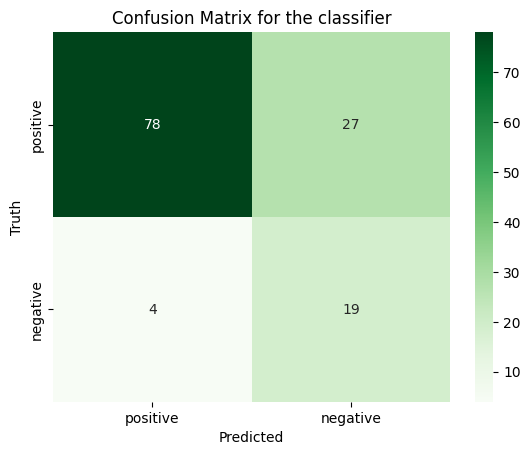

In [194]:
y_IVS_pred = best_model.predict(X_test_scaled)

print("Classification Report for IVS:")
print(classification_report(y_test, y_IVS_pred))

classification_plot(y_test, y_IVS_pred)

In [195]:
evaluation_results = classification_evaluation(y_test, y_IVS_pred)
print("Additional Evaluation Metrics:")
print(evaluation_results)

#Additional Evaluation Metrics:
#   Test Accuracy  Test Precision  Test Recall   Test F1  Test MCC
#0       0.681994        0.037607     0.666667  0.071197  0.099883


#Additional Evaluation Metrics:
#   Test Accuracy  Test Precision  Test Recall   Test F1  Test MCC
#0       0.710938        0.365385     0.826087  0.506667  0.400084     COM A JUNÇÃO DAS REDES

#COM A JUNÇÃO DE MUTATION E MRNA

Additional Evaluation Metrics:
   Test Accuracy  Test Precision  Test Recall   Test F1  Test MCC
0       0.757812        0.413043     0.826087  0.550725  0.455242


## Random Forests

Best Hyperparameters: {'criterion': 'gini', 'max_depth': None, 'n_estimators': 100, 'n_jobs': -1}
Classification Report for IVS:
              precision    recall  f1-score   support

           0       0.93      0.75      0.83       105
           1       0.40      0.74      0.52        23

    accuracy                           0.75       128
   macro avg       0.66      0.75      0.67       128
weighted avg       0.83      0.75      0.77       128



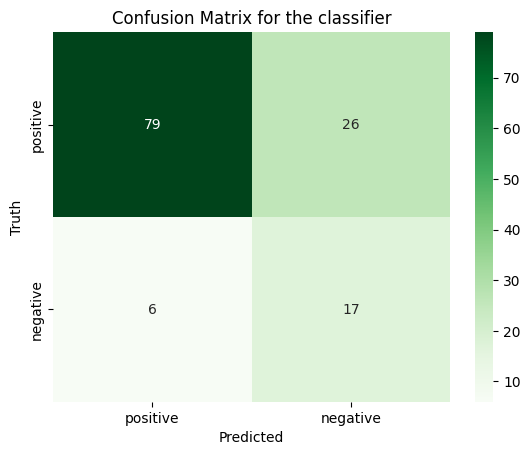

Additional Evaluation Metrics:
   Test Accuracy  Test Precision  Test Recall   Test F1  Test MCC
0           0.75        0.395349      0.73913  0.515152  0.399529


In [163]:
from sklearn.ensemble import RandomForestClassifier
parameters = {'n_estimators': (10, 100, 500), 
              'criterion': ('gini', 'entropy'),
              'ma'
              'max_depth': (None, 2, 3, 4), 
              'n_jobs': [-1]}
rfc_model = RandomForestClassifier(random_state=42)
rfc_model, eval_df, best_params = classification_scores("Random Forest", rfc_model, parameters, X_train_resampled, y_train_resampled)

print("Best Hyperparameters:", best_params)


y_IVS_pred = rfc_model.predict(X_test_scaled)

print("Classification Report for IVS:")
print(classification_report(y_test, y_IVS_pred))

classification_plot(y_test, y_IVS_pred)

evaluation_results = classification_evaluation(y_test, y_IVS_pred)
print("Additional Evaluation Metrics:")
print(evaluation_results)


Classification Report for IVS:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90       105
           1       0.00      0.00      0.00        23

    accuracy                           0.82       128
   macro avg       0.41      0.50      0.45       128
weighted avg       0.67      0.82      0.74       128



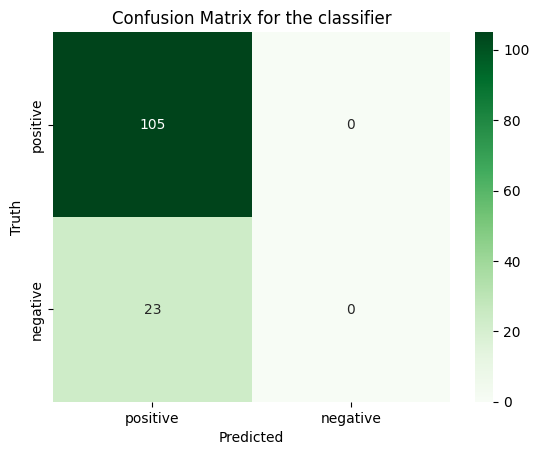

Additional Evaluation Metrics:
   Test Accuracy  Test Precision  Test Recall  Test F1  Test MCC
0       0.820312             0.0          0.0      0.0       0.0


In [164]:
# Evaluate the best model on the independent validation set (IVS)
y_IVS_pred = best_model.predict(X_test)

# Print classification report
print("Classification Report for IVS:")
print(classification_report(y_test, y_IVS_pred))

# Use your classification_plot function to visualize the confusion matrix
classification_plot(y_test, y_IVS_pred)

# Use your classification_evaluation function to get additional evaluation metrics
evaluation_results = classification_evaluation(y_test, y_IVS_pred)
print("Additional Evaluation Metrics:")
print(evaluation_results)

In [165]:
Cs = np.logspace(-4, 4, 15)
parameters_log_reg = {'C': Cs}
log_reg = LogisticRegression(random_state=23)
best_log_reg = classification_scores("Logistic Regression", log_reg, parameters_log_reg, X_train_resampled, y_train_resampled)
print("Best Logistic Regression parameters:")
display(pd.DataFrame(best_log_reg[2], index=[0]))

Best Logistic Regression parameters:


C
0  13.894955

In [166]:
best_results_clf = pd.concat([best_log_reg[1]], axis=0)
best_results_clf.reset_index(drop=True, inplace=True)
display(best_results_clf)

Model  CV Accuracy  CV Precision  CV Recall    CV F1   CV MCC
0  Logistic Regression     0.978723      0.979655   0.978723  0.97849  0.95386

In [ ]:
best_log_reg_model = best_log_reg[0]
best_log_reg_model.fit(X_train_resampled, y_train_resampled)

predictions_IVS = best_log_reg_model.predict(X_IVS)

classification_report_IVS = classification_report(y_IVS, predictions_IVS)
print("Classification Report on IVS:\n", classification_report_IVS)

classification_plot(y_IVS, predictions_IVS)

evaluation_results_IVS = classification_evaluation(y_IVS, predictions_IVS)
print("Evaluation Metrics on IVS:\n", evaluation_results_IVS)

In [ ]:
logistic_regression = LogisticRegression()

# Define hyperparameters for grid search
parameters_log_reg = {'C': [0.001, 0.01, 0.1], 'tol': [1e-6, 1e-4, 1e-2], 'penalty': ['l1', 'l2'], 'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']}

best_model, eval_df, best_params = classification_scores("Logistic Regression", logistic_regression, parameters_log_reg, X_train_resampled, y_train_resampled)

print("Best Hyperparameters:", best_params)

In [ ]:
y_IVS_pred = best_model.predict(X_IVS)

print("Classification Report for IVS:")
print(classification_report(y_IVS, y_IVS_pred))

classification_plot(y_IVS, y_IVS_pred)

In [ ]:
evaluation_results = classification_evaluation(y_IVS, y_IVS_pred)
print("Additional Evaluation Metrics:")
print(evaluation_results)

## Comparison

In [ ]:
best_model_clf = DecisionTreeClassifier(max_depth=None, min_samples_leaf=2, min_samples_split=5)
not_so_good_model_clf = LogisticRegression(C=0.1, tol=1e-6)
results_confidence(best_model_clf, not_so_good_model_clf, "classification", X_train_clf, X_IVS_clf, y_train_clf, y_IVS_clf)

## XGBoost

In [298]:
import xgboost as xgb
from sklearn.metrics import classification_report
import pandas as pd

results_evaluation = {}

for driver, data in results.items():
    print(f"\nProcessando driver: {driver}")
    
    X_train_resampled = data['X_train_resampled']
    y_train_resampled = data['y_train_resampled']
    X_test_scaled = data['X_test_scaled']
    y_test = data['y_test']

    parameters = {
        'gamma': [0, 10, 25],
        'max_depth': [2, 4, 6],
        'subsample': [0.1, 0.5, 1],
        'learning_rate': [0.01, 0.1, 0.3],  # adicionado para melhor ajuste
        'n_estimators': [100, 200, 300]  # adicionado para melhor ajuste
    }
    
    xgb_model = xgb.XGBClassifier(random_state=42)
    
    best_model, eval_df, best_params = classification_scores("XGBoost", 
                                                             xgb_model, 
                                                             parameters, 
                                                             X_train_resampled, 
                                                             y_train_resampled)
    
    print("Best Hyperparameters:", best_params)
    y_pred = best_model.predict(X_test_scaled)

    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    classification_plot(y_test, y_pred)
    evaluation_results = classification_evaluation(y_test, y_pred)
    print("Additional Evaluation Metrics:")
    print(evaluation_results)

    results_evaluation[driver] = {
        'best_model': best_model,
        'eval_df': eval_df,
        'best_params': best_params,
        'classification_report': classification_report(y_test, y_pred),
        'evaluation_results': evaluation_results
    }

for driver, result in results_evaluation.items():
    print(f"\nResultados para {driver}:")
    print(f"Melhores parâmetros: {result['best_params']}")
    print(f"Avaliação:\n{result['eval_df']}")
    print(f"Relatório de classificação:\n{result['classification_report']}")
    print(f"Métricas adicionais:\n{result['evaluation_results']}")


Processando driver: TP53


PicklingError: Could not pickle the task to send it to the workers.

In [82]:
import xgboost as xgb
parameters = {'gamma':(0, 10, 25),
              'max_depth':(2, 4, 6),
              'subsample':(0.1, 0.5, 1)}

xgb_model = xgb.XGBClassifier(random_state=42)  
xgb_model, eval_df, best_params = classification_scores("XGBoost", xgb_model, parameters, X_train_resampled, y_train_resampled)
print("Best Hyperparameters:", best_params)

y_IVS_pred = xgb_model.predict(X_test_scaled)

print("Classification Report for IVS:")
print(classification_report(y_test, y_IVS_pred))

classification_plot(y_test, y_IVS_pred)

evaluation_results = classification_evaluation(y_test, y_IVS_pred)
print("Additional Evaluation Metrics:")
print(evaluation_results)

KeyboardInterrupt: 